In [3]:
from ultralytics import YOLO
import cv2
from IPython.display import Image as Im
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
train_no = 44
model_path = f'runs15Jan/train{train_no}/weights/best.pt'
import torch
device = torch.device('cpu')
model = YOLO(model_path)  # Or 'path/to/best.pt'
model.to(device)

YOLO(
  (model): PoseModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=

In [4]:
csv_path = "csv/New_test_2.csv"
df = pd.read_csv(csv_path)

In [5]:
def findValue(filename , folder_path , label_path , model):
        image_path = os.path.join(folder_path, filename)
        keypoints_path = os.path.join(label_path, filename.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))
        if not os.path.exists(keypoints_path):
            print(f"Keypoints file not found for {filename}. Skipping...")
            return "Not"
        results = model(image_path)[0]
        
        keypoints_model = results.keypoints.xy[0].numpy()
        img = cv2.imread(image_path)

        print(filename)
        with open(keypoints_path, 'r') as file:
            lines = file.readlines()
        keypoints_data = list(map(float, lines[0].split(" ")))
        keypoints = np.array(keypoints_data[5:]).reshape(-1, 3)
        if not results.keypoints.xy[0].any():
            # Handle the case where no keypoints are detected
            print(f"No keypoints detected in {filename}")
            return "Not"
        
        # print(keypoints)
        height, width, _ = img.shape
        keypoints_model[:,0]/=width
        keypoints_model[:,1]/=height
        distances = np.linalg.norm(keypoints[:, :2] - keypoints_model, axis=1)

        not_visible_keypoints_model = [i for i, keypoint in enumerate(keypoints[:, :2]) if np.all(keypoint == [0, 0])]
        not_visible_keypoints_label = [i for i, keypoint in enumerate(keypoints_model) if np.all(keypoint == [0, 0])]

        # Filter out distances for not visible points
        visible_distances = [distance for i, distance in enumerate(distances) if i not in not_visible_keypoints_model and i not in not_visible_keypoints_label]

        # Calculate statistics only for visible points
        if visible_distances:
            average_distance = np.mean(visible_distances)
            max_closeness = np.max(visible_distances)
            min_closeness = np.min(visible_distances)
        else:
            average_distance = 0
            max_closeness = 0
            min_closeness = 0
        return average_distance , max_closeness , min_closeness , not_visible_keypoints_model , not_visible_keypoints_label

In [6]:
def check_avg_dis(model):
    count = 0 
    sum = 0 
    def update_row(row, filename, folder_path, label_path , model):
        new_values = findValue(filename, folder_path, label_path ,model)
        if new_values != "Not":  # Check if keypoints were detected
            row['Average Distance'] = new_values[0]
            row['Max Closeness'] = new_values[1]
            row['Min Closeness'] = new_values[2]
            row['Not Visible Points Model'] = new_values[3]
            row['Not Visible Points Label'] = new_values[4]
        return row
    folder_path = 'New_test_img_2/images'
    label_path = 'New_test_img_2/labels'
    # Iterate through the DataFrame and update values
    for index, row in df.iterrows():
        filename = row['Image']  # Assuming filename is in the 'Image' column
        df.loc[index] = update_row(row, filename, folder_path, label_path , model)
        sum+=df.loc[index]['Average Distance']
        count+=1
    return sum/count



In [7]:
from ultralytics import settings
import dagshub
dagshub.init(repo_owner='ishant', repo_name='test2', mlflow=True)
# Update a setting
settings.update({'mlflow': True})

Initialized MLflow to track repo "ishant/test2"

Repository ishant/test2 initialized!

In [13]:
import mlflow.pytorch
import mlflow
# mlflow.set_tracking_uri("https://dagshub.com/ishant/test2.mlflow")
# mlflow.set_experiment("keypoint_test_New")

train_no = 38
model_path = f'runs15Jan/train{train_no}/weights/best.pt'
import torch
device = torch.device('cpu')
model = YOLO(model_path)  # Or 'path/to/best.pt'
model.to(device)
dis = check_avg_dis(model)
# print(dis)
name = f"Train_No_{train_no}"
wandb.init(project='keypoint_test', name=name)
# Log the PyTorch model with MLflow





image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230108161822.jpeg: 480x640 1 car, 78.5ms
Speed: 2.8ms preprocess, 78.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230822192008.jpeg: 480x640 1 car, 91.3ms
Speed: 3.3ms preprocess, 91.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230108161822.jpeg
right_side_view-20230822192008.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221223114144.jpeg: 480x640 1 car, 102.6ms
Speed: 6.6ms preprocess, 102.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230113131454.jpeg: 480x640 1 car, 109.2ms
Speed: 3.0ms preprocess, 109.2ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20221223114144.jpeg
rear_left_view-20230113131454.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230424151412.jpg: 512x640 1 car, 128.8ms
Speed: 4.2ms preprocess, 128.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231202151813.jpeg: 480x640 1 car, 98.0ms
Speed: 3.4ms preprocess, 98.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230424151412.jpg
rear_right_view-20231202151813.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230524174344.jpeg: 384x640 1 car, 68.5ms
Speed: 3.0ms preprocess, 68.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230505154931.jpg: 480x640 1 car, 81.7ms
Speed: 2.7ms preprocess, 81.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230524174344.jpeg
left_side_view-20230505154931.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230122230748.jpeg: 480x640 1 car, 74.5ms
Speed: 2.5ms preprocess, 74.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221210190446.jpeg: 480x640 1 car, 89.2ms
Speed: 3.5ms preprocess, 89.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230122230748.jpeg
cover_image-20221210190446.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240103184831.jpg: 480x640 1 car, 71.4ms
Speed: 3.2ms preprocess, 71.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230113131505.jpeg: 480x640 1 car, 79.9ms
Speed: 3.4ms preprocess, 79.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20240103184831.jpg
front_right_view-20230113131505.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230113131528.jpeg: 480x640 1 car, 73.2ms
Speed: 3.3ms preprocess, 73.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230612171611.jpeg: 480x640 1 car, 86.6ms
Speed: 4.2ms preprocess, 86.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230113131528.jpeg
front_right_view-20230612171611.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230424151425.jpg: 512x640 1 car, 105.8ms
Speed: 2.8ms preprocess, 105.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230819134348.jpg: 480x640 1 car, 84.8ms
Speed: 10.8ms preprocess, 84.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20230424151425.jpg
rear_left_view-20230819134348.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230612171512.jpeg: 480x640 1 car, 91.6ms
Speed: 6.4ms preprocess, 91.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230221182625.jpeg: 480x640 1 car, 78.3ms
Speed: 2.5ms preprocess, 78.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230612171512.jpeg
front_right_view-20230221182625.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230822192036.jpeg: 480x640 1 car, 79.1ms
Speed: 2.2ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221223114154.jpeg: 480x640 1 car, 77.0ms
Speed: 3.4ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230822192036.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230819134335.jpg: 480x640 1 car, 111.2ms
Speed: 3.2ms preprocess, 111.2ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20221223114154.jpeg
right_side_view-20230819134335.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221210190639.jpeg: 480x640 1 car, 127.7ms
Speed: 2.9ms preprocess, 127.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230505154952.jpg: 480x640 1 car, 115.0ms
Speed: 5.4ms preprocess, 115.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20221210190639.jpeg
rear_right_view-20230505154952.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230819134319.jpg: 480x640 1 car, 122.9ms
Speed: 3.7ms preprocess, 122.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240103184802.jpg: 480x640 1 car, 112.3ms
Speed: 4.1ms preprocess, 112.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230819134319.jpg
cover_image-20240103184802.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230122230818.jpeg: 480x640 1 car, 109.6ms
Speed: 5.8ms preprocess, 109.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230302145907.jpg: 512x640 1 car, 116.2ms
Speed: 3.3ms preprocess, 116.2ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)



rear_left_view-20230122230818.jpeg
left_side_view-20230302145907.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221210190629.jpeg: 480x640 1 car, 121.5ms
Speed: 3.5ms preprocess, 121.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231202151725.jpeg: 480x640 1 car, 104.3ms
Speed: 4.0ms preprocess, 104.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20221210190629.jpeg


cover_image-20231202151725.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230927134157.jpeg: 640x480 1 car, 140.0ms
Speed: 5.6ms preprocess, 140.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230108161943.jpeg: 480x640 1 car, 99.5ms
Speed: 3.5ms preprocess, 99.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230927134157.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230705185128.jpeg: 480x640 1 car, 102.5ms
Speed: 4.1ms preprocess, 102.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230108161943.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230822192017.jpeg: 480x640 1 car, 110.9ms
Speed: 4.8ms preprocess, 110.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20230705185128.jpeg
rear_left_view-20230822192017.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230524174418.jpeg: 384x640 1 car, 113.8ms
Speed: 4.3ms preprocess, 113.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230307161432.jpg: 384x640 1 car, 87.8ms
Speed: 2.4ms preprocess, 87.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230524174418.jpeg
right_side_view-20230307161432.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230302145940.jpg: 512x640 1 car, 130.6ms
Speed: 4.1ms preprocess, 130.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230201172302.jpg: 480x640 1 car, 98.2ms
Speed: 6.0ms preprocess, 98.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230302145940.jpg
left_side_view-20230201172302.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230302155603.jpeg: 384x640 1 car, 76.9ms
Speed: 2.6ms preprocess, 76.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230927134142.jpeg: 480x640 1 car, 82.8ms
Speed: 2.6ms preprocess, 82.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230302155603.jpeg
left_side_view-20230927134142.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230612171440.jpeg: 480x640 1 car, 75.3ms
Speed: 2.2ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221223114117.jpeg: 480x640 1 car, 80.1ms
Speed: 2.5ms preprocess, 80.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230612171440.jpeg
rear_left_view-20221223114117.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231214125357.jpeg: 480x640 1 car, 86.9ms
Speed: 2.5ms preprocess, 86.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230201172332.jpg: 480x640 1 car, 72.0ms
Speed: 2.6ms preprocess, 72.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20231214125357.jpeg
rear_left_view-20230201172332.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230819134257.jpg: 480x640 1 car, 81.6ms
Speed: 4.0ms preprocess, 81.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231202151746.jpeg: 480x640 1 car, 87.0ms
Speed: 2.9ms preprocess, 87.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230819134257.jpg
right_side_view-20231202151746.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230108161859.jpeg: 480x640 1 car, 80.1ms
Speed: 3.1ms preprocess, 80.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221210190611.jpeg: 480x640 1 car, 81.5ms
Speed: 2.7ms preprocess, 81.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230108161859.jpeg
right_side_view-20221210190611.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230108161928.jpeg: 480x640 1 car, 77.7ms
Speed: 3.0ms preprocess, 77.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221223114019.jpeg: 480x640 1 car, 71.8ms
Speed: 2.4ms preprocess, 71.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230108161928.jpeg
cover_image-20221223114019.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230705185120.jpeg: 512x640 1 car, 96.4ms
Speed: 5.6ms preprocess, 96.4ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230524174509.jpeg: 384x640 1 car, 59.4ms
Speed: 2.0ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20230705185120.jpeg
rear_right_view-20230524174509.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230221182537.jpeg: 480x640 1 car, 84.9ms
Speed: 2.7ms preprocess, 84.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230108161912.jpeg: 480x640 1 car, 72.0ms
Speed: 3.3ms preprocess, 72.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230221182537.jpeg
right_side_view-20230108161912.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230307161424.jpg: 384x640 1 car, 71.1ms
Speed: 2.0ms preprocess, 71.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230302155640.jpeg: 384x640 1 car, 57.7ms
Speed: 2.3ms preprocess, 57.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230307161424.jpg
left_side_view-20230302155640.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230307161515.jpg: 384x640 1 car, 71.5ms
Speed: 2.0ms preprocess, 71.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230221182558.jpeg: 480x640 1 car, 69.0ms
Speed: 3.2ms preprocess, 69.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230307161515.jpg
left_side_view-20230221182558.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230705185101.jpeg: 480x640 1 car, 72.7ms
Speed: 3.2ms preprocess, 72.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221223114105.jpeg: 480x640 1 car, 73.7ms
Speed: 2.4ms preprocess, 73.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230705185101.jpeg
right_side_view-20221223114105.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230705185042.jpeg: 480x640 2 cars, 111.8ms
Speed: 18.5ms preprocess, 111.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230505154942.jpg: 480x640 1 car, 76.9ms
Speed: 3.2ms preprocess, 76.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230705185042.jpeg
front_right_view-20230505154942.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230505154937.jpg: 480x640 1 car, 63.0ms
Speed: 3.9ms preprocess, 63.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231205165549.jpeg: 480x640 1 car, 73.7ms
Speed: 3.3ms preprocess, 73.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230505154937.jpg
rear_right_view-20231205165549.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230302145917.jpg: 512x640 1 car, 88.2ms
Speed: 2.8ms preprocess, 88.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230424151441.jpg: 512x640 1 car, 84.7ms
Speed: 4.2ms preprocess, 84.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)



rear_left_view-20230302145917.jpg
rear_right_view-20230424151441.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221223114100.jpeg: 480x640 1 car, 82.9ms
Speed: 2.5ms preprocess, 82.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231214125444.jpeg: 480x640 1 car, 71.0ms
Speed: 3.3ms preprocess, 71.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20221223114100.jpeg
front_right_view-20231214125444.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230822191933.jpeg: 480x640 1 car, 67.6ms
Speed: 3.7ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231205165445.jpeg: 480x640 1 car, 75.6ms
Speed: 3.3ms preprocess, 75.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230822191933.jpeg
cover_image-20231205165445.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230424151433.jpg: 512x640 1 car, 92.1ms
Speed: 2.6ms preprocess, 92.1ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240103184824.jpg: 480x640 1 car, 84.4ms
Speed: 3.5ms preprocess, 84.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230424151433.jpg
left_side_view-20240103184824.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230302145952.jpg: 512x640 1 car, 95.0ms
Speed: 2.6ms preprocess, 95.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230705185113.jpeg: 480x640 1 car, 79.4ms
Speed: 2.6ms preprocess, 79.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230302145952.jpg
right_side_view-20230705185113.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230524174353.jpeg: 384x640 1 car, 70.5ms
Speed: 2.5ms preprocess, 70.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231214125428.jpeg: 480x640 1 car, 95.1ms
Speed: 3.2ms preprocess, 95.1ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230524174353.jpeg
right_side_view-20231214125428.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230524174505.jpeg: 384x640 1 car, 85.8ms
Speed: 3.2ms preprocess, 85.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230201172323.jpg: 480x640 1 car, 99.8ms
Speed: 2.7ms preprocess, 99.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230524174505.jpeg
front_right_view-20230201172323.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230302145830.jpg: 512x640 1 car, 114.1ms
Speed: 3.9ms preprocess, 114.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230201172315.jpg: 480x640 1 car, 91.1ms
Speed: 3.7ms preprocess, 91.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230302145830.jpg
right_side_view-20230201172315.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230302150003.jpg: 512x640 1 car, 106.9ms
Speed: 2.5ms preprocess, 106.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230822192049.jpeg: 480x640 1 car, 123.0ms
Speed: 21.0ms preprocess, 123.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230302150003.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231214125416.jpeg: 480x640 1 car, 147.3ms
Speed: 4.7ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230822192049.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20230612171643.jpeg: 480x640 1 car, 84.4ms
Speed: 8.0ms preprocess, 84.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20231214125416.jpeg
wheels_tyres-20230612171643.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231205165505.jpeg: 480x640 1 car, 88.1ms
Speed: 3.3ms preprocess, 88.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231214125451.jpeg: 480x640 2 cars, 89.6ms
Speed: 9.5ms preprocess, 89.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20231205165505.jpeg
rear_right_view-20231214125451.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240103184924.jpg: 480x640 1 car, 115.3ms
Speed: 2.6ms preprocess, 115.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231202151756.jpeg: 480x640 1 car, 95.9ms
Speed: 3.7ms preprocess, 95.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20240103184924.jpg
rear_left_view-20231202151756.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240103184914.jpg: 480x640 1 car, 107.5ms
Speed: 3.4ms preprocess, 107.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231214125438.jpeg: 480x640 1 car, 122.1ms
Speed: 8.3ms preprocess, 122.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20240103184914.jpg
rear_left_view-20231214125438.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230122230433.jpeg: 480x640 1 car, 240.8ms
Speed: 12.3ms preprocess, 240.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230113131436.jpeg: 480x640 1 car, 97.1ms
Speed: 5.4ms preprocess, 97.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230122230433.jpeg
right_side_view-20230113131436.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230612171549.jpeg: 480x640 1 car, 118.7ms
Speed: 3.1ms preprocess, 118.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240103184839.jpg: 480x640 1 car, 135.2ms
Speed: 5.3ms preprocess, 135.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230612171549.jpeg
front_right_view-20240103184839.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231205165530.jpeg: 480x640 1 car, 135.5ms
Speed: 17.6ms preprocess, 135.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221210190605.jpeg: 480x640 1 car, 137.4ms
Speed: 4.2ms preprocess, 137.4ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20231205165530.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230612171532.jpeg: 480x640 1 car, 143.1ms
Speed: 6.8ms preprocess, 143.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20221210190605.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230927134206.jpeg: 640x480 1 car, 141.2ms
Speed: 5.3ms preprocess, 141.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


right_side_view-20230612171532.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230612171623.jpeg: 480x640 1 car, 144.6ms
Speed: 7.5ms preprocess, 144.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230927134206.jpeg


rear_right_view-20230612171623.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230505154915.jpg: 480x640 1 car, 201.9ms
Speed: 31.9ms preprocess, 201.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230822191952.jpeg: 480x640 1 car, 130.6ms
Speed: 5.5ms preprocess, 130.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230505154915.jpg
left_side_view-20230822191952.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230927134120.jpeg: 640x480 1 car, 143.3ms
Speed: 5.4ms preprocess, 143.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230201172212.jpg: 480x640 1 car, 154.3ms


cover_image-20230927134120.jpeg


Speed: 5.8ms preprocess, 154.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230221182634.jpeg: 480x640 1 car, 155.1ms
Speed: 5.5ms preprocess, 155.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230201172212.jpg


rear_right_view-20230221182634.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231205165516.jpeg: 480x640 1 car, 141.2ms
Speed: 6.6ms preprocess, 141.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20231205165516.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230705185137.jpeg: 512x640 1 car, 147.0ms
Speed: 4.7ms preprocess, 147.0ms inference, 10.9ms postprocess per image at shape (1, 3, 512, 640)



rear_right_view-20230705185137.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221210190621.jpeg: 480x640 1 car, 247.6ms
Speed: 4.0ms preprocess, 247.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231205165540.jpeg: 480x640 1 car, 89.4ms
Speed: 3.1ms preprocess, 89.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20221210190621.jpeg
front_right_view-20231205165540.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230221182606.jpeg: 480x640 1 car, 99.9ms
Speed: 3.3ms preprocess, 99.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230201172342.jpg: 480x640 1 car, 100.9ms
Speed: 4.6ms preprocess, 100.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230221182606.jpeg
rear_right_view-20230201172342.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230819134354.jpg: 480x640 1 car, 101.6ms
Speed: 4.3ms preprocess, 101.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230122230340.jpeg: 480x640 1 car, 96.5ms
Speed: 3.5ms preprocess, 96.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230819134354.jpg
cover_image-20230122230340.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230424151418.jpg: 512x640 1 car, 109.8ms
Speed: 4.0ms preprocess, 109.8ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230221182616.jpeg: 480x640 1 car, 80.6ms
Speed: 3.1ms preprocess, 80.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230424151418.jpg
rear_left_view-20230221182616.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231202151806.jpeg: 480x640 1 car, 82.7ms
Speed: 2.3ms preprocess, 82.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230113131414.jpeg: 480x640 1 car, 84.7ms
Speed: 2.3ms preprocess, 84.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20231202151806.jpeg
left_side_view-20230113131414.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230307161503.jpg: 384x640 1 car, 68.3ms
Speed: 2.0ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230122230835.jpeg: 480x640 1 car, 81.0ms
Speed: 3.3ms preprocess, 81.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230307161503.jpg
front_right_view-20230122230835.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230424151340.jpg: 512x640 1 car, 90.6ms
Speed: 3.5ms preprocess, 90.6ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230505154947.jpg: 480x640 1 car, 93.7ms
Speed: 2.3ms preprocess, 93.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230424151340.jpg
rear_left_view-20230505154947.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231202151741.jpeg: 480x640 1 car, 111.9ms
Speed: 2.9ms preprocess, 111.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230927134215.jpeg: 640x480 1 car, 96.5ms
Speed: 3.3ms preprocess, 96.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)



left_side_view-20231202151741.jpeg
rear_right_view-20230927134215.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230927134146.jpeg: 480x640 1 car, 98.1ms
Speed: 2.7ms preprocess, 98.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477528098494460.jpg: 384x640 1 car, 83.3ms
Speed: 2.8ms preprocess, 83.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230927134146.jpeg
PART_1477528098494460.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477534685641985.jpg: 480x640 1 car, 89.5ms
Speed: 2.8ms preprocess, 89.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-3.jpg: 384x640 1 car, 71.9ms
Speed: 2.1ms preprocess, 71.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



PART_1477534685641985.jpg
in642120231213085757-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481212012786903.jpg: 448x640 1 car, 87.4ms
Speed: 3.0ms preprocess, 87.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-2.jpg: 384x640 1 car, 67.0ms
Speed: 2.1ms preprocess, 67.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



PART_1481212012786903.jpg
in214320231205082545-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477281278514983.jpg: 480x640 1 car, 80.6ms
Speed: 3.0ms preprocess, 80.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in301020231219125953-2.jpg: 384x640 1 car, 81.9ms
Speed: 1.9ms preprocess, 81.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



PART_1477281278514983.jpg
in301020231219125953-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-2.jpg: 384x640 1 car, 83.1ms
Speed: 2.4ms preprocess, 83.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481583051684227.jpg: 480x640 1 car, 89.0ms
Speed: 2.2ms preprocess, 89.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



in502720231123120621-2.jpg
PART_1481583051684227.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477441913947488.jpg: 480x640 1 car, 102.1ms
Speed: 2.4ms preprocess, 102.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-3.jpg: 384x640 1 car, 94.4ms
Speed: 2.3ms preprocess, 94.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



PART_1477441913947488.jpg
in826820231213123248-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478534944389907.jpg: 480x640 1 car, 135.8ms
Speed: 33.1ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-2.jpg: 384x640 1 car, 92.8ms
Speed: 4.7ms preprocess, 92.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



PART_1478534944389907.jpg
in873320231124095011-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016857709169136791652.jpg: 480x640 1 car, 106.4ms
Speed: 2.3ms preprocess, 106.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477426201017406.jpg: 480x640 1 car, 80.9ms
Speed: 2.5ms preprocess, 80.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



part160016857709169136791652.jpg
PART_1477426201017406.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168907093361914891819.jpg: 480x640 1 car, 107.0ms
Speed: 2.7ms preprocess, 107.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-9.jpg: 384x640 1 car, 79.1ms
Speed: 2.0ms preprocess, 79.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



part1600168907093361914891819.jpg
in243120231121121717-9.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016897900455272268222.jpg: 480x640 1 car, 100.7ms
Speed: 2.7ms preprocess, 100.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-7.jpg: 384x640 1 car, 72.0ms
Speed: 2.0ms preprocess, 72.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)



part160016897900455272268222.jpg
in975420231211105726-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-6.jpg: 384x640 1 car, 82.9ms
Speed: 1.7ms preprocess, 82.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-4.jpg: 384x640 1 car, 103.1ms
Speed: 5.7ms preprocess, 103.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in214320231205082545-6.jpg
in745620231211145159-4.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481745169403126.jpg: 640x480 1 car, 92.0ms
Speed: 2.4ms preprocess, 92.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-1.jpg: 384x640 1 car, 80.1ms
Speed: 2.5ms preprocess, 80.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481723760991902.jpg: 384x640 1 car, 57.4ms
Speed: 3.2ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


PART_1481745169403126.jpg
in214320231205082545-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477934840240950.jpg: 480x640 1 car, 106.0ms
Speed: 2.6ms preprocess, 106.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



PART_1481723760991902.jpg
PART_1477934840240950.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479184799422426.jpg: 480x640 1 car, 105.4ms
Speed: 2.8ms preprocess, 105.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-1.jpg: 384x640 1 car, 63.0ms
Speed: 1.6ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



PART_1479184799422426.jpg
in265220231119103239-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-1.jpg: 384x640 1 car, 81.0ms
Speed: 1.7ms preprocess, 81.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-6.jpg: 384x640 1 car, 71.4ms
Speed: 2.1ms preprocess, 71.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in799620231218081737-1.jpg
in411620231220133737-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-3.jpg: 384x640 1 car, 77.9ms
Speed: 3.1ms preprocess, 77.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-7.jpg: 384x640 1 car, 80.3ms
Speed: 2.4ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



in646920231218133357-3.jpg
in873320231124095011-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482487534261722.jpg: 480x640 1 car, 91.4ms
Speed: 3.1ms preprocess, 91.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482852216802389.jpg: 480x640 1 car, 87.1ms
Speed: 3.4ms preprocess, 87.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



PART_1482487534261722.jpg
PART_1482852216802389.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168252609604631156929.jpg: 480x640 1 car, 91.4ms
Speed: 3.3ms preprocess, 91.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-2.jpg: 384x640 1 car, 77.3ms
Speed: 2.4ms preprocess, 77.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



part1600168252609604631156929.jpg
in292820231124100518-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-2.jpg: 384x640 1 car, 83.1ms
Speed: 2.4ms preprocess, 83.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483803963334515.jpg: 384x640 1 car, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



in161920231119111435-2.jpg
PART_1483803963334515.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-5.jpg: 384x640 1 car, 76.6ms
Speed: 2.9ms preprocess, 76.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168662435360421798415.jpg: 480x640 1 car, 90.5ms
Speed: 3.3ms preprocess, 90.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



in642120231213085757-5.jpg
part1600168662435360421798415.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482366796132742.jpg: 480x640 1 car, 152.8ms
Speed: 23.7ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3558863405494105.jpg: 480x640 1 car, 91.1ms
Speed: 3.2ms preprocess, 91.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



PART_1482366796132742.jpg
PART_3558863405494105.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-7.jpg: 384x640 1 car, 74.0ms
Speed: 3.0ms preprocess, 74.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481545463689331.jpg: 480x640 1 car, 102.5ms
Speed: 3.0ms preprocess, 102.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



in547220231123124841-7.jpg
PART_1481545463689331.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168283154369834518600.jpg: 480x640 1 car, 98.5ms
Speed: 3.9ms preprocess, 98.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-1.jpg: 384x640 1 car, 83.5ms
Speed: 2.6ms preprocess, 83.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



part1600168283154369834518600.jpg
in411620231220133737-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477167228078692.jpg: 384x640 1 car, 91.7ms
Speed: 2.2ms preprocess, 91.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-2.jpg: 384x640 1 car, 82.4ms
Speed: 2.1ms preprocess, 82.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



PART_1477167228078692.jpg
in547220231123124841-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479768679758253.jpg: 480x640 1 car, 110.1ms
Speed: 3.7ms preprocess, 110.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168923838974728586003.jpg: 480x640 1 car, 99.1ms
Speed: 4.0ms preprocess, 99.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



PART_1479768679758253.jpg
part1600168923838974728586003.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482595858580953.jpg: 480x640 1 car, 98.2ms
Speed: 3.3ms preprocess, 98.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169062422420571213895.jpg: 480x640 1 car, 92.9ms
Speed: 3.2ms preprocess, 92.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)



PART_1482595858580953.jpg
part1600169062422420571213895.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-9.jpg: 384x640 1 car, 66.3ms
Speed: 1.7ms preprocess, 66.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483788146793608.jpg: 480x640 1 car, 71.6ms
Speed: 2.4ms preprocess, 71.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-3.jpg: 384x640 1 car, 71.6ms
Speed: 1.6ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in646920231218133357-9.jpg
PART_1483788146793608.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479382118154593.jpg: 480x640 1 car, 73.9ms
Speed: 2.9ms preprocess, 73.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



in975420231211105726-3.jpg
PART_1479382118154593.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482640794032106.jpg: 480x640 1 car, 91.6ms
Speed: 2.4ms preprocess, 91.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016837502979981204271.jpg: 480x640 1 car, 90.8ms
Speed: 21.9ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



PART_1482640794032106.jpg
part160016837502979981204271.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-2.jpg: 384x640 1 car, 83.0ms
Speed: 2.0ms preprocess, 83.0ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478464287971743.jpg: 480x640 1 car, 131.9ms
Speed: 6.8ms preprocess, 131.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



in821820231219130304-2.jpg
PART_1478464287971743.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-5.jpg: 384x640 1 car, 107.9ms
Speed: 5.1ms preprocess, 107.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482847017922559.jpg: 480x640 1 car, 97.4ms
Speed: 2.4ms preprocess, 97.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



in821820231219130304-5.jpg
PART_1482847017922559.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-4.jpg: 384x640 1 car, 76.0ms
Speed: 1.8ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480002566827727.jpg: 480x640 1 car, 79.6ms
Speed: 2.8ms preprocess, 79.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



in646920231218133357-4.jpg
PART_1480002566827727.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481908693906672.jpg: 480x640 1 car, 112.1ms
Speed: 3.9ms preprocess, 112.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-3.jpg: 384x640 1 car, 66.9ms
Speed: 2.3ms preprocess, 66.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-5.jpg: 384x640 1 car, 71.2ms
Speed: 2.1ms preprocess, 71.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


PART_1481908693906672.jpg
in214320231205082545-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-7.jpg: 384x640 2 cars, 112.4ms
Speed: 3.6ms preprocess, 112.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



in745620231211145159-5.jpg
in292820231124100518-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478058867586331.jpg: 480x640 1 car, 159.5ms
Speed: 6.5ms preprocess, 159.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)



PART_1478058867586331.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-6.jpg: 384x640 1 car, 285.3ms
Speed: 3.0ms preprocess, 285.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479466445456510.jpg: 480x640 1 car, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-7.jpg: 384x640 1 car, 66.0ms
Speed: 1.9ms preprocess, 66.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-6.jpg
PART_1479466445456510.jpg
in411620231220133737-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3562436545529405.jpg: 480x640 1 car, 63.9ms
Speed: 2.6ms preprocess, 63.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478189478050087.jpg: 480x640 1 car, 73.4ms
Speed: 2.4ms preprocess, 73.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478299856204165.jpg: 480x640 1 car, 79.6ms
Speed: 2.4ms preprocess, 79.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_3562436545529405.jpg
PART_1478189478050087.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-2.jpg: 384x640 1 car, 51.1ms
Speed: 2.2ms preprocess, 51.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168588606433457854332.jpg: 480x640 1 car, 72.3ms
Speed: 2.2ms preprocess, 72.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



PART_1478299856204165.jpg
in535020231211135109-2.jpg
part1600168588606433457854332.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-1.jpg: 384x640 1 car, 101.5ms
Speed: 2.1ms preprocess, 101.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-3.jpg: 384x640 1 car, 49.3ms
Speed: 2.0ms preprocess, 49.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477405746854617.jpg: 480x640 1 car, 58.8ms
Speed: 2.3ms preprocess, 58.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



in502720231123120621-1.jpg
in755420231116153659-3.jpg
PART_1477405746854617.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168350220297825094927.jpg: 480x640 1 car, 79.7ms
Speed: 2.4ms preprocess, 79.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-2.jpg: 384x640 1 car, 67.5ms
Speed: 1.5ms preprocess, 67.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-7.jpg: 384x640 1 car, 63.7ms
Speed: 2.2ms preprocess, 63.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



part1600168350220297825094927.jpg
in763620231121114511-2.jpg
in957620231218121623-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-6.jpg: 384x640 1 car, 65.5ms
Speed: 1.8ms preprocess, 65.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559764612050941.jpg: 480x640 1 car, 66.4ms
Speed: 2.2ms preprocess, 66.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480738532743538.jpg: 512x640 1 car, 61.4ms
Speed: 2.6ms preprocess, 61.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)



in535020231211135109-6.jpg
PART_3559764612050941.jpg
PART_1480738532743538.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016877186097642093317.jpg: 480x640 1 car, 82.4ms
Speed: 2.4ms preprocess, 82.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168293598191588001496.jpg: 480x640 1 car, 70.0ms
Speed: 2.2ms preprocess, 70.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480453911124456.jpg: 480x640 1 car, 59.0ms
Speed: 2.4ms preprocess, 59.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part160016877186097642093317.jpg
part1600168293598191588001496.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-6.jpg: 384x640 1 car, 67.1ms
Speed: 2.5ms preprocess, 67.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-7.jpg: 384x640 1 car, 64.5ms
Speed: 2.0ms preprocess, 64.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_1480453911124456.jpg
in265220231119103239-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-6.jpg: 384x640 1 car, 52.5ms
Speed: 1.9ms preprocess, 52.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-3.jpg: 384x640 1 car, 50.4ms
Speed: 1.7ms preprocess, 50.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



in836320231214150909-7.jpg
in161920231119111435-6.jpg
in502720231123120621-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part16001690477971644463261.jpg: 480x640 1 car, 63.0ms
Speed: 2.6ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-7.jpg: 384x640 1 car, 49.7ms
Speed: 1.7ms preprocess, 49.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4395181456302878.jpg: 480x640 1 car, 57.2ms
Speed: 1.9ms preprocess, 57.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



part16001690477971644463261.jpg
in265220231119103239-7.jpg
PART_4395181456302878.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478870985931474.jpg: 480x640 1 car, 61.2ms
Speed: 2.1ms preprocess, 61.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-6.jpg: 384x640 2 cars, 94.5ms
Speed: 5.0ms preprocess, 94.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



PART_1478870985931474.jpg
in957620231218121623-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-5.jpg: 384x640 1 car, 70.9ms
Speed: 2.0ms preprocess, 70.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1484079026295772.jpg: 480x640 1 car, 67.6ms
Speed: 2.8ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168224745465570190870.jpg: 640x480 1 car, 64.8ms
Speed: 3.1ms preprocess, 64.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


in763620231121114511-5.jpg
PART_1484079026295772.jpg
part1600168224745465570190870.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478441604224371.jpg: 384x640 1 car, 50.0ms
Speed: 2.0ms preprocess, 50.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-2.jpg: 384x640 1 car, 63.6ms
Speed: 1.8ms preprocess, 63.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-2.jpg: 384x640 1 car, 55.2ms
Speed: 2.0ms preprocess, 55.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



PART_1478441604224371.jpg
in642120231213085757-2.jpg
in799620231218081737-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477785823946919.jpg: 480x640 1 car, 78.0ms
Speed: 2.6ms preprocess, 78.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481910397927490.jpg: 480x640 1 car, 57.2ms
Speed: 2.6ms preprocess, 57.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-7.jpg: 384x640 1 car, 57.9ms
Speed: 2.0ms preprocess, 57.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



PART_1477785823946919.jpg
PART_1481910397927490.jpg
in646920231218133357-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479255219713006.jpg: 480x640 1 car, 67.6ms
Speed: 2.3ms preprocess, 67.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-7.jpg: 384x640 1 car, 55.3ms
Speed: 2.4ms preprocess, 55.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4495593076167055.jpg: 480x640 1 car, 86.7ms
Speed: 2.5ms preprocess, 86.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1479255219713006.jpg
in821820231219130304-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-3.jpg: 384x640 1 car, 51.3ms
Speed: 2.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479952879597662.jpg: 480x640 1 car, 61.6ms
Speed: 2.5ms preprocess, 61.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



PART_4495593076167055.jpg
in411620231220133737-3.jpg
PART_1479952879597662.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-5.jpg: 384x640 1 car, 67.1ms
Speed: 2.4ms preprocess, 67.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-2.jpg: 384x640 1 car, 48.5ms
Speed: 1.7ms preprocess, 48.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168487347574271567380.jpg: 480x640 1 car, 59.8ms
Speed: 2.7ms preprocess, 59.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



in547220231123124841-5.jpg
in928020231220093827-2.jpg
part1600168487347574271567380.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560588209651776.jpg: 352x640 1 car, 65.8ms
Speed: 1.9ms preprocess, 65.8ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478411529869910.jpg: 480x640 1 car, 73.9ms
Speed: 1.9ms preprocess, 73.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



PART_3560588209651776.jpg
PART_1478411529869910.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-2.jpg: 384x640 1 car, 65.7ms
Speed: 3.3ms preprocess, 65.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-5.jpg: 384x640 1 car, 64.1ms
Speed: 2.0ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-2.jpg: 384x640 1 car, 65.8ms
Speed: 2.0ms preprocess, 65.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



in957620231218121623-2.jpg
in836320231214150909-5.jpg
in755420231116153659-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-1.jpg: 384x640 1 car, 69.0ms
Speed: 1.9ms preprocess, 69.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168263144558438189588.jpg: 480x640 1 car, 57.7ms
Speed: 2.5ms preprocess, 57.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479354265937997.jpg: 480x640 1 car, 78.4ms
Speed: 2.5ms preprocess, 78.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


in292820231124100518-1.jpg
part1600168263144558438189588.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482606483220424.jpg: 384x640 1 car, 70.5ms
Speed: 2.6ms preprocess, 70.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483210320995706.jpg: 512x640 1 car, 61.8ms
Speed: 2.4ms preprocess, 61.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


PART_1479354265937997.jpg
PART_1482606483220424.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-5.jpg: 384x640 1 car, 48.1ms
Speed: 1.4ms preprocess, 48.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483841811166102.jpg: 320x640 1 car, 56.1ms
Speed: 2.2ms preprocess, 56.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)



PART_1483210320995706.jpg
in799620231218081737-5.jpg
PART_1483841811166102.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559628291981744.jpg: 480x640 1 car, 76.8ms
Speed: 2.4ms preprocess, 76.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483616823760075.jpg: 384x640 1 car, 62.6ms
Speed: 1.6ms preprocess, 62.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560577313968785.jpg: 480x640 1 car, 79.5ms
Speed: 2.2ms preprocess, 79.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


PART_3559628291981744.jpg
PART_1483616823760075.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4408179695317297.jpg: 480x640 1 car, 57.8ms
Speed: 2.5ms preprocess, 57.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4394079952521361.jpg: 384x640 1 car, 66.6ms
Speed: 1.9ms preprocess, 66.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


PART_3560577313968785.jpg
PART_4408179695317297.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-7.jpg: 384x640 1 car, 54.8ms
Speed: 2.0ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168470297537621523720.jpg: 480x640 1 car, 57.6ms
Speed: 2.7ms preprocess, 57.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



PART_4394079952521361.jpg
in502720231123120621-7.jpg
part1600168470297537621523720.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-3.jpg: 384x640 2 cars, 76.5ms
Speed: 1.9ms preprocess, 76.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479475397923700.jpg: 480x640 1 car, 57.2ms
Speed: 2.0ms preprocess, 57.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-7.jpg: 384x640 1 car, 71.8ms
Speed: 1.6ms preprocess, 71.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


in873320231124095011-3.jpg
PART_1479475397923700.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-6.jpg: 384x640 1 car, 45.4ms
Speed: 1.9ms preprocess, 45.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-5.jpg: 384x640 1 car, 60.8ms
Speed: 2.0ms preprocess, 60.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



in214320231205082545-7.jpg
in975420231211105726-6.jpg
in646920231218133357-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-1.jpg: 384x640 1 car, 49.4ms
Speed: 1.5ms preprocess, 49.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168340251687826694940.jpg: 480x640 1 car, 70.9ms
Speed: 2.5ms preprocess, 70.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-5.jpg: 384x640 1 car, 44.4ms
Speed: 1.4ms preprocess, 44.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



in836320231214150909-1.jpg
part1600168340251687826694940.jpg
in502720231123120621-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483248120468209.jpg: 480x640 1 car, 76.9ms
Speed: 2.0ms preprocess, 76.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478558445769340.jpg: 480x640 1 car, 58.4ms
Speed: 2.1ms preprocess, 58.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482225318351645.jpg: 320x640 1 car, 49.5ms
Speed: 1.4ms preprocess, 49.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)



PART_1483248120468209.jpg
PART_1478558445769340.jpg
PART_1482225318351645.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-3.jpg: 384x640 1 car, 47.7ms
Speed: 1.6ms preprocess, 47.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483496885531519.jpg: 480x640 1 car, 67.6ms
Speed: 2.3ms preprocess, 67.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3561229220430928.jpg: 384x640 1 car, 43.7ms
Speed: 1.5ms preprocess, 43.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



in799620231218081737-3.jpg
PART_1483496885531519.jpg
PART_3561229220430928.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168535186414285141985.jpg: 480x640 1 car, 58.3ms
Speed: 2.3ms preprocess, 58.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016883371158994760719.jpg: 384x640 1 car, 43.6ms
Speed: 1.8ms preprocess, 43.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478134314872619.jpg: 480x640 1 car, 51.8ms
Speed: 1.8ms preprocess, 51.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



part1600168535186414285141985.jpg
part160016883371158994760719.jpg
PART_1478134314872619.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3496373593011785.jpg: 320x640 1 car, 47.0ms
Speed: 1.9ms preprocess, 47.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477414637212916.jpg: 480x640 1 car, 52.4ms
Speed: 2.1ms preprocess, 52.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



PART_3496373593011785.jpg
PART_1477414637212916.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168313507412441456967.jpg: 480x640 1 car, 105.3ms
Speed: 31.9ms preprocess, 105.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481117392640398.jpg: 480x640 1 car, 77.8ms
Speed: 5.5ms preprocess, 77.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480147557590644.jpg: 384x640 1 car, 44.6ms
Speed: 1.7ms preprocess, 44.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



part1600168313507412441456967.jpg
PART_1481117392640398.jpg
PART_1480147557590644.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4411723625968720.jpg: 480x640 1 car, 86.2ms
Speed: 1.9ms preprocess, 86.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479099483545485.jpg: 480x640 1 car, 96.3ms
Speed: 3.7ms preprocess, 96.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



PART_4411723625968720.jpg
PART_1479099483545485.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483923120256926.jpg: 512x640 1 car, 85.1ms
Speed: 3.0ms preprocess, 85.1ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-7.jpg: 384x640 1 car, 58.5ms
Speed: 1.6ms preprocess, 58.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016863579581974467775.jpg: 480x640 1 car, 84.6ms
Speed: 3.2ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1483923120256926.jpg
in161920231119111435-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480786645946999.jpg: 384x640 1 car, 60.7ms
Speed: 2.3ms preprocess, 60.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1484033936623199.jpg: 480x640 1 car, 56.3ms
Speed: 2.0ms preprocess, 56.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



part160016863579581974467775.jpg
PART_1480786645946999.jpg
PART_1484033936623199.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478701545065743.jpg: 480x640 1 car, 109.4ms
Speed: 4.8ms preprocess, 109.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4396074210422407.jpg: 320x640 1 car, 81.5ms
Speed: 8.6ms preprocess, 81.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)



PART_1478701545065743.jpg
PART_4396074210422407.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-3.jpg: 384x640 1 car, 55.4ms
Speed: 5.9ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-7.jpg: 384x640 1 car, 65.4ms
Speed: 2.0ms preprocess, 65.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-3.jpg: 384x640 1 car, 46.5ms
Speed: 2.5ms preprocess, 46.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



in292820231124100518-3.jpg
in799620231218081737-7.jpg
in957620231218121623-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481724691739913.jpg: 480x640 1 car, 56.6ms
Speed: 1.9ms preprocess, 56.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478705006293172.jpg: 448x640 1 car, 50.2ms
Speed: 1.9ms preprocess, 50.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478630273066489.jpg: 480x640 1 car, 53.2ms
Speed: 2.4ms preprocess, 53.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



PART_1481724691739913.jpg
PART_1478705006293172.jpg
PART_1478630273066489.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481478716227158.jpg: 480x640 1 car, 64.6ms
Speed: 2.8ms preprocess, 64.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-2.jpg: 384x640 1 car, 60.3ms
Speed: 2.1ms preprocess, 60.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559026759844316.jpg: 480x640 1 car, 71.2ms
Speed: 2.9ms preprocess, 71.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



PART_1481478716227158.jpg
in836320231214150909-2.jpg
PART_3559026759844316.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-6.jpg: 384x640 1 car, 51.2ms
Speed: 1.9ms preprocess, 51.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-3.jpg: 384x640 1 car, 50.0ms
Speed: 1.8ms preprocess, 50.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-6.jpg: 384x640 1 car, 57.3ms
Speed: 1.8ms preprocess, 57.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



in799620231218081737-6.jpg
in821820231219130304-3.jpg
in873320231124095011-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482832106532585.jpg: 480x640 1 car, 75.3ms
Speed: 2.1ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-7.jpg: 384x640 1 car, 60.9ms
Speed: 1.7ms preprocess, 60.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-7.jpg: 384x640 1 car, 58.0ms
Speed: 1.5ms preprocess, 58.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



PART_1482832106532585.jpg
in642120231213085757-7.jpg
in745620231211145159-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477607400418254.jpg: 448x640 1 car, 51.3ms
Speed: 2.4ms preprocess, 51.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4397024580852166.jpg: 480x640 1 car, 76.0ms
Speed: 2.3ms preprocess, 76.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3558690236844843.jpg: 384x640 1 car, 43.8ms
Speed: 2.0ms preprocess, 43.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



PART_1477607400418254.jpg
PART_4397024580852166.jpg
PART_3558690236844843.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-6.jpg: 384x640 1 car, 45.5ms
Speed: 1.6ms preprocess, 45.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479759940598498.jpg: 480x640 1 car, 64.6ms
Speed: 2.4ms preprocess, 64.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-2.jpg: 384x640 1 car, 42.4ms
Speed: 2.1ms preprocess, 42.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



in502720231123120621-6.jpg
PART_1479759940598498.jpg
in975420231211105726-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-3.jpg: 384x640 1 car, 49.2ms
Speed: 1.4ms preprocess, 49.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-8.jpg: 384x640 1 car, 43.4ms
Speed: 2.2ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-8.jpg: 384x640 1 car, 54.2ms
Speed: 1.5ms preprocess, 54.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



in763620231121114511-3.jpg
in957620231218121623-8.jpg
in646920231218133357-8.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-6.jpg: 384x640 1 car, 49.8ms
Speed: 1.8ms preprocess, 49.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-1.jpg: 384x640 1 car, 71.6ms
Speed: 1.4ms preprocess, 71.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in928020231220093827-6.jpg
in821820231219130304-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168555366341865634231.jpg: 320x640 1 car, 141.2ms
Speed: 35.8ms preprocess, 141.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479562395975901.jpg: 480x640 1 car, 131.3ms
Speed: 4.0ms preprocess, 131.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



part1600168555366341865634231.jpg
PART_1479562395975901.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-6.jpg: 384x640 1 car, 90.5ms
Speed: 5.2ms preprocess, 90.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168503074404727423169.jpg: 480x640 1 car, 77.4ms
Speed: 2.4ms preprocess, 77.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



in779120231119152124-6.jpg
part1600168503074404727423169.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-5.jpg: 384x640 1 car, 71.0ms
Speed: 2.1ms preprocess, 71.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in755420231116153659-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481672883470520.jpg: 480x640 1 car, 363.5ms
Speed: 50.6ms preprocess, 363.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478486328015152.jpg: 480x640 1 car, 72.2ms
Speed: 2.3ms preprocess, 72.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



PART_1481672883470520.jpg
PART_1478486328015152.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-7.jpg: 384x640 1 car, 58.1ms
Speed: 1.8ms preprocess, 58.1ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-1.jpg: 384x640 1 car, 136.9ms
Speed: 2.8ms preprocess, 136.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in779120231119152124-7.jpg
in928020231220093827-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-6.jpg: 384x640 1 car, 120.4ms
Speed: 4.2ms preprocess, 120.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-1.jpg: 384x640 1 car, 138.6ms
Speed: 3.1ms preprocess, 138.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


in292820231124100518-6.jpg
in642120231213085757-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-3.jpg: 384x640 1 car, 142.6ms
Speed: 9.3ms preprocess, 142.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



in265220231119103239-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016850320663952748547.jpg: 480x640 1 car, 181.9ms
Speed: 14.6ms preprocess, 181.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



part160016850320663952748547.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-2.jpg: 384x640 1 car, 357.3ms
Speed: 18.2ms preprocess, 357.3ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-7.jpg: 384x640 1 car, 99.6ms
Speed: 3.1ms preprocess, 99.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



in826820231213123248-2.jpg
in755420231116153659-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483040902570112.jpg: 512x640 1 car, 141.1ms
Speed: 5.9ms preprocess, 141.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168748451614186364646.jpg: 480x640 1 car, 135.1ms
Speed: 4.0ms preprocess, 135.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



PART_1483040902570112.jpg
part1600168748451614186364646.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4409875392172994.jpg: 480x640 1 car, 71.4ms
Speed: 2.3ms preprocess, 71.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481902021627340.jpg: 480x640 1 car, 67.9ms
Speed: 2.1ms preprocess, 67.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



PART_4409875392172994.jpg
PART_1481902021627340.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3564205062841876.jpg: 480x640 1 car, 82.2ms
Speed: 2.9ms preprocess, 82.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480211880582672.jpg: 480x640 1 car, 52.4ms
Speed: 2.4ms preprocess, 52.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-8.jpg: 384x640 1 car, 45.1ms
Speed: 2.2ms preprocess, 45.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



PART_3564205062841876.jpg
PART_1480211880582672.jpg
in243120231121121717-8.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-5.jpg: 384x640 1 car, 61.4ms
Speed: 1.7ms preprocess, 61.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-6.jpg: 384x640 1 car, 61.0ms
Speed: 1.7ms preprocess, 61.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016854286321624513875.jpg: 480x640 1 car, 74.4ms
Speed: 2.2ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



in292820231124100518-5.jpg
in826820231213123248-6.jpg
part160016854286321624513875.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479059081086908.jpg: 480x640 1 car, 110.8ms
Speed: 2.6ms preprocess, 110.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168366004084637756878.jpg: 480x640 1 car, 87.8ms
Speed: 4.6ms preprocess, 87.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



PART_1479059081086908.jpg
part1600168366004084637756878.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-6.jpg: 384x640 1 car, 60.7ms
Speed: 1.7ms preprocess, 60.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-6.jpg: 384x640 1 car, 103.4ms
Speed: 3.7ms preprocess, 103.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



in755420231116153659-6.jpg
in821820231219130304-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481593495821827.jpg: 480x640 1 car, 113.1ms
Speed: 5.2ms preprocess, 113.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-5.jpg: 384x640 1 car, 111.5ms
Speed: 2.3ms preprocess, 111.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



PART_1481593495821827.jpg
in411620231220133737-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478329502958288.jpg: 480x640 1 car, 102.0ms
Speed: 4.0ms preprocess, 102.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



PART_1478329502958288.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560027113760653.jpg: 480x640 1 car, 186.2ms
Speed: 38.6ms preprocess, 186.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-7.jpg: 384x640 1 car, 57.9ms
Speed: 1.8ms preprocess, 57.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-5.jpg: 384x640 1 car, 53.1ms
Speed: 1.5ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



PART_3560027113760653.jpg
in763620231121114511-7.jpg
in826820231213123248-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480293754514517.jpg: 480x640 1 car, 125.3ms
Speed: 3.4ms preprocess, 125.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-6.jpg: 384x640 1 car, 62.9ms
Speed: 1.9ms preprocess, 62.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



PART_1480293754514517.jpg
in836320231214150909-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481446473131123.jpg: 480x640 1 car, 120.7ms
Speed: 2.3ms preprocess, 120.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-2.jpg: 384x640 1 car, 100.6ms
Speed: 6.7ms preprocess, 100.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



PART_1481446473131123.jpg
in265220231119103239-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478141726362045.jpg: 480x640 1 car, 148.9ms
Speed: 28.2ms preprocess, 148.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-6.jpg: 384x640 1 car, 57.5ms
Speed: 1.8ms preprocess, 57.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-7.jpg: 384x640 1 car, 50.0ms
Speed: 1.4ms preprocess, 50.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



PART_1478141726362045.jpg
in763620231121114511-6.jpg
in535020231211135109-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-4.jpg: 384x640 1 car, 47.5ms
Speed: 1.9ms preprocess, 47.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168372784216486895332.jpg: 448x640 1 car, 78.4ms
Speed: 2.2ms preprocess, 78.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-3.jpg: 384x640 1 car, 62.6ms
Speed: 2.2ms preprocess, 62.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-4.jpg
part1600168372784216486895332.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477472546470809.jpg: 480x640 1 car, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



in535020231211135109-3.jpg
PART_1477472546470809.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-4.jpg: 384x640 1 car, 121.7ms
Speed: 3.5ms preprocess, 121.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483643331452636.jpg: 384x640 1 car, 108.4ms
Speed: 2.9ms preprocess, 108.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



in243120231121121717-4.jpg
PART_1483643331452636.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479515160134545.jpg: 480x640 1 car, 129.9ms
Speed: 3.2ms preprocess, 129.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482641886229208.jpg: 480x640 1 car, 83.4ms
Speed: 3.0ms preprocess, 83.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



PART_1479515160134545.jpg
PART_1482641886229208.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-2.jpg: 384x640 2 cars, 133.2ms
Speed: 2.5ms preprocess, 133.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477786870210365.jpg: 480x640 1 car, 133.7ms
Speed: 5.1ms preprocess, 133.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


in779120231119152124-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-5.jpg: 384x640 1 car, 75.4ms
Speed: 2.3ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



PART_1477786870210365.jpg
in214320231205082545-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481664768556479.jpg: 448x640 1 car, 84.3ms
Speed: 2.7ms preprocess, 84.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483441612726530.jpg: 320x640 1 car, 99.0ms
Speed: 3.0ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)



PART_1481664768556479.jpg
PART_1483441612726530.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-3.jpg: 384x640 1 car, 96.3ms
Speed: 3.1ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169077456680518725884.jpg: 480x640 1 car, 84.6ms
Speed: 3.0ms preprocess, 84.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



in836320231214150909-3.jpg
part1600169077456680518725884.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483108249233619.jpg: 512x640 1 car, 60.1ms
Speed: 3.1ms preprocess, 60.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169090973281685103148.jpg: 480x640 1 car, 61.3ms
Speed: 2.6ms preprocess, 61.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169008038940490818014.jpg: 480x640 1 car, 61.6ms
Speed: 2.5ms preprocess, 61.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


PART_1483108249233619.jpg
part1600169090973281685103148.jpg
part1600169008038940490818014.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230803123236.jpeg: 384x640 1 car, 48.0ms
Speed: 1.6ms preprocess, 48.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231008101255.jpg: 384x640 1 car, 43.7ms
Speed: 1.9ms preprocess, 43.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230808130147.jpeg: 384x640 1 car, 60.8ms
Speed: 2.8ms preprocess, 60.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230803123236.jpeg
cover_image-20231008101255.jpg
cover_image-20230808130147.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230922181923.jpeg: 384x640 1 car, 82.2ms
Speed: 6.5ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231129110435.jpg: 384x640 1 car, 72.8ms
Speed: 2.1ms preprocess, 72.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230922181923.jpeg
front_right_view-20231129110435.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230811143949.jpeg: 384x640 1 car, 108.4ms
Speed: 3.4ms preprocess, 108.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231010184313.jpg: 384x640 1 car, 156.0ms


rear_right_view-20230811143949.jpeg


Speed: 13.8ms preprocess, 156.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231214103426.jpg: 384x640 1 car, 113.8ms
Speed: 4.4ms preprocess, 113.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20231010184313.jpg
rear_left_view-20231214103426.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230808130415.jpeg: 384x640 1 car, 144.7ms
Speed: 3.8ms preprocess, 144.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230611142129.jpg: 384x640 1 car, 126.4ms
Speed: 4.5ms preprocess, 126.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230808130415.jpeg
rear_right_view-20230611142129.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230910101658.jpg: 384x640 1 car, 73.9ms
Speed: 2.8ms preprocess, 73.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231006135947.jpeg: 384x640 1 car, 62.1ms
Speed: 1.8ms preprocess, 62.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231016185751.jpg: 384x640 1 car, 51.4ms
Speed: 1.5ms preprocess, 51.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20230910101658.jpg
cover_image-20231006135947.jpeg
rear_left_view-20231016185751.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240103130714.jpg: 384x640 1 car, 48.3ms
Speed: 1.5ms preprocess, 48.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230929231239.jpg: 384x640 1 car, 63.6ms
Speed: 2.3ms preprocess, 63.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230522160751.jpg: 384x640 1 car, 54.0ms
Speed: 1.8ms preprocess, 54.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20240103130714.jpg
rear_right_view-20230929231239.jpg
rear_right_view-20230522160751.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231010184240.jpg: 384x640 1 car, 66.8ms
Speed: 2.6ms preprocess, 66.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231005124746.jpeg: 384x640 1 car, 53.2ms
Speed: 2.0ms preprocess, 53.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230331174028.jpg: 384x640 1 car, 60.1ms
Speed: 1.9ms preprocess, 60.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231010184240.jpg
cover_image-20231005124746.jpeg
rear_left_view-20230331174028.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231121170009.jpg: 384x640 1 car, 59.9ms
Speed: 1.9ms preprocess, 59.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230611142059.jpg: 384x640 1 car, 65.4ms
Speed: 1.7ms preprocess, 65.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231121170009.jpg
right_side_view-20230611142059.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231129104249.jpg: 384x640 1 car, 77.9ms
Speed: 29.9ms preprocess, 77.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230519173548.jpeg: 384x640 1 car, 50.6ms
Speed: 2.2ms preprocess, 50.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230215190012.jpeg: 384x640 1 car, 44.7ms
Speed: 1.6ms preprocess, 44.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231129104249.jpg
right_side_view-20230519173548.jpeg
rear_left_view-20230215190012.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221104130948.jpeg: 384x640 1 car, 59.4ms
Speed: 1.5ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231219133353.jpeg: 384x640 1 car, 59.0ms
Speed: 2.1ms preprocess, 59.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231229091312.jpg: 384x640 1 car, 68.9ms
Speed: 1.8ms preprocess, 68.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20221104130948.jpeg
cover_image-20231219133353.jpeg
left_side_view-20231229091312.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231129110404.jpg: 384x640 1 car, 64.3ms
Speed: 2.3ms preprocess, 64.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230526143323.jpeg: 384x640 1 car, 70.0ms
Speed: 1.8ms preprocess, 70.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240109213150.jpg: 384x640 1 car, 67.4ms
Speed: 1.9ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231129110404.jpg
rear_right_view-20230526143323.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231229091423.jpg: 384x640 1 car, 69.9ms
Speed: 2.1ms preprocess, 69.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230623143227.jpg: 384x640 1 car, 68.2ms
Speed: 1.9ms preprocess, 68.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20240109213150.jpg
rear_left_view-20231229091423.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230903153432.jpg: 384x640 1 car, 78.7ms
Speed: 1.7ms preprocess, 78.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230623143227.jpg
left_side_view-20230903153432.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230922182127.jpeg: 384x640 1 car, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231016185803.jpg: 384x640 1 car, 77.6ms
Speed: 2.2ms preprocess, 77.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20230922182127.jpeg
rear_right_view-20231016185803.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231008101347.jpg: 384x640 1 car, 71.7ms
Speed: 1.6ms preprocess, 71.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230929231204.jpg: 384x640 1 car, 49.7ms
Speed: 2.0ms preprocess, 49.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221221130716.jpg: 384x640 1 car, 52.7ms
Speed: 1.9ms preprocess, 52.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231008101347.jpg
right_side_view-20230929231204.jpg
rear_right_view-20221221130716.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230307161432.jpg: 384x640 1 car, 67.8ms
Speed: 2.1ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230611142123.jpg: 384x640 1 car, 64.7ms
Speed: 1.7ms preprocess, 64.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230111141846.jpeg: 384x640 1 car, 65.9ms
Speed: 1.9ms preprocess, 65.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230307161432.jpg
rear_left_view-20230611142123.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230215190023.jpeg: 384x640 1 car, 90.3ms
Speed: 3.7ms preprocess, 90.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230111141846.jpeg
front_right_view-20230215190023.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240111121000.jpg: 384x640 1 car, 75.8ms
Speed: 2.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231129104342.jpg: 384x640 1 car, 58.1ms
Speed: 1.7ms preprocess, 58.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230331173829.jpg: 384x640 1 car, 67.6ms
Speed: 1.5ms preprocess, 67.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20240111121000.jpg
rear_right_view-20231129104342.jpg
cover_image-20230331173829.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20230808130429.jpeg: 384x640 1 car, 69.8ms
Speed: 1.9ms preprocess, 69.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230808130406.jpeg: 384x640 1 car, 42.5ms
Speed: 1.4ms preprocess, 42.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240109213019.jpg: 384x640 1 car, 60.0ms
Speed: 1.9ms preprocess, 60.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



wheels_tyres-20230808130429.jpeg
front_right_view-20230808130406.jpeg
cover_image-20240109213019.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230623143216.jpg: 384x640 1 car, 59.5ms
Speed: 1.8ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240103130638.jpg: 384x640 1 car, 45.1ms
Speed: 1.9ms preprocess, 45.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230111141859.jpeg: 384x640 1 car, 53.7ms
Speed: 1.5ms preprocess, 53.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230623143216.jpg
cover_image-20240103130638.jpg
rear_left_view-20230111141859.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231129104301.jpg: 384x640 1 car, 72.7ms
Speed: 1.7ms preprocess, 72.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240103130705.jpg: 384x640 1 car, 51.9ms
Speed: 1.7ms preprocess, 51.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231010184204.jpg: 384x640 1 car, 42.4ms
Speed: 2.3ms preprocess, 42.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231129104301.jpg
right_side_view-20240103130705.jpg
cover_image-20231010184204.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20220502122645.jpg: 384x640 1 car, 61.1ms
Speed: 1.7ms preprocess, 61.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231129110445.jpg: 384x640 1 car, 48.4ms
Speed: 1.7ms preprocess, 48.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231129104327.jpg: 384x640 1 car, 44.8ms
Speed: 1.5ms preprocess, 44.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20220502122645.jpg
rear_left_view-20231129110445.jpg
rear_left_view-20231129104327.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230331173917.jpg: 384x640 1 car, 102.7ms
Speed: 3.9ms preprocess, 102.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231008101403.jpg: 384x640 1 car, 61.2ms
Speed: 1.8ms preprocess, 61.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230811143930.jpeg: 384x640 1 car, 47.5ms
Speed: 1.5ms preprocess, 47.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20230331173917.jpg
rear_left_view-20231008101403.jpg
rear_left_view-20230811143930.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230522160726.jpg: 384x640 1 car, 47.9ms
Speed: 1.6ms preprocess, 47.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221224131311.jpeg: 384x640 1 car, 59.4ms
Speed: 1.6ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230519173630.jpeg: 384x640 1 car, 63.4ms
Speed: 1.7ms preprocess, 63.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230522160726.jpg
right_side_view-20221224131311.jpeg
rear_left_view-20230519173630.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230922182114.jpeg: 384x640 1 car, 45.4ms
Speed: 1.7ms preprocess, 45.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230522160746.jpg: 384x640 1 car, 43.8ms
Speed: 1.4ms preprocess, 43.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230531180130.jpg: 384x640 1 car, 46.2ms
Speed: 1.5ms preprocess, 46.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230922182114.jpeg
rear_left_view-20230522160746.jpg
rear_left_view-20230531180130.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230803123121.jpeg: 384x640 1 car, 43.5ms
Speed: 2.0ms preprocess, 43.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230331155119.jpeg: 384x640 2 cars, 60.0ms
Speed: 1.9ms preprocess, 60.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20210922134927.jpg: 384x640 1 car, 51.7ms
Speed: 1.7ms preprocess, 51.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230803123121.jpeg
rear_left_view-20230331155119.jpeg
cover_image-20210922134927.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231008101326.jpg: 384x640 1 car, 63.1ms
Speed: 1.7ms preprocess, 63.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231229091358.jpg: 384x640 1 car, 49.3ms
Speed: 1.4ms preprocess, 49.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230531180105.jpg: 384x640 1 car, 45.1ms
Speed: 1.6ms preprocess, 45.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231008101326.jpg
front_right_view-20231229091358.jpg
left_side_view-20230531180105.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230307161424.jpg: 384x640 1 car, 52.7ms
Speed: 1.5ms preprocess, 52.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231219133604.jpeg: 384x640 1 car, 65.4ms
Speed: 15.9ms preprocess, 65.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230331155111.jpeg: 384x640 1 car, 49.4ms
Speed: 1.6ms preprocess, 49.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230307161424.jpg
rear_left_view-20231219133604.jpeg
front_right_view-20230331155111.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230522160738.jpg: 384x640 1 car, 46.8ms
Speed: 1.6ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231129104316.jpg: 384x640 1 car, 60.4ms
Speed: 1.5ms preprocess, 60.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231214103357.jpg: 384x640 1 car, 43.7ms
Speed: 1.4ms preprocess, 43.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20230522160738.jpg
front_right_view-20231129104316.jpg
right_side_view-20231214103357.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230307161515.jpg: 384x640 1 car, 63.1ms
Speed: 1.9ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231121170053.jpg: 384x640 1 car, 45.5ms
Speed: 1.6ms preprocess, 45.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230803123208.jpeg: 384x640 1 car, 55.0ms
Speed: 1.5ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230307161515.jpg
rear_right_view-20231121170053.jpg
rear_left_view-20230803123208.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20220502122742.jpg: 384x640 1 car, 50.9ms
Speed: 1.5ms preprocess, 50.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240103130659.jpg: 384x640 1 car, 58.2ms
Speed: 1.9ms preprocess, 58.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221104130944.jpeg: 384x640 1 car, 44.8ms
Speed: 1.5ms preprocess, 44.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20220502122742.jpg
left_side_view-20240103130659.jpg
left_side_view-20221104130944.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231219133614.jpeg: 384x640 1 car, 62.5ms
Speed: 1.6ms preprocess, 62.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240103130737.jpg: 384x640 1 car, 52.2ms
Speed: 1.6ms preprocess, 52.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230215185956.jpeg: 384x640 1 car, 50.1ms
Speed: 1.5ms preprocess, 50.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20231219133614.jpeg
rear_right_view-20240103130737.jpg
left_side_view-20230215185956.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221104130902.jpeg: 384x640 1 car, 51.8ms
Speed: 2.0ms preprocess, 51.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221221130641.jpg: 384x640 1 car, 59.5ms
Speed: 2.2ms preprocess, 59.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231214103315.jpg: 384x640 1 car, 58.2ms
Speed: 1.7ms preprocess, 58.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20221104130902.jpeg
rear_left_view-20221221130641.jpg
cover_image-20231214103315.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230526143234.jpeg: 384x640 1 car, 55.5ms
Speed: 1.7ms preprocess, 55.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230803123157.jpeg: 384x640 1 car, 62.7ms
Speed: 2.4ms preprocess, 62.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230910101650.jpg: 384x640 1 car, 47.4ms
Speed: 1.7ms preprocess, 47.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230526143234.jpeg
right_side_view-20230803123157.jpeg
front_right_view-20230910101650.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230611142105.jpg: 384x640 1 car, 56.6ms
Speed: 1.9ms preprocess, 56.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20231219133652.jpeg: 384x640 1 car, 44.5ms
Speed: 1.4ms preprocess, 44.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221224131231.jpeg: 384x640 1 car, 57.2ms
Speed: 1.7ms preprocess, 57.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20230611142105.jpg
wheels_tyres-20231219133652.jpeg
cover_image-20221224131231.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230903153500.jpg: 384x640 1 car, 53.9ms
Speed: 1.9ms preprocess, 53.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240111120936.jpg: 384x640 1 car, 44.1ms
Speed: 2.1ms preprocess, 44.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230922182100.jpeg: 384x640 1 car, 52.6ms
Speed: 1.5ms preprocess, 52.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20230903153500.jpg
cover_image-20240111120936.jpg
left_side_view-20230922182100.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231102120437.jpg: 384x640 1 car, 62.7ms
Speed: 1.7ms preprocess, 62.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230111141949.jpeg: 384x640 1 car, 53.7ms
Speed: 1.6ms preprocess, 53.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230903153516.jpg: 384x640 1 car, 58.1ms
Speed: 2.3ms preprocess, 58.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231102120437.jpg
rear_right_view-20230111141949.jpeg
rear_left_view-20230903153516.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231006140120.jpeg: 384x640 1 car, 61.2ms
Speed: 1.5ms preprocess, 61.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231121170028.jpg: 384x640 1 car, 43.2ms
Speed: 2.3ms preprocess, 43.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230611142028.jpg: 384x640 1 car, 45.9ms
Speed: 2.0ms preprocess, 45.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20231006140120.jpeg
rear_left_view-20231121170028.jpg
cover_image-20230611142028.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221221130554.jpg: 384x640 1 car, 48.4ms
Speed: 1.4ms preprocess, 48.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231010184251.jpg: 384x640 1 car, 71.2ms
Speed: 17.7ms preprocess, 71.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231102120441.jpg: 384x640 1 car, 47.2ms
Speed: 1.7ms preprocess, 47.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20221221130554.jpg
right_side_view-20231010184251.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230623143209.jpg: 384x640 1 car, 61.4ms
Speed: 1.7ms preprocess, 61.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231229091334.jpg: 384x640 1 car, 56.9ms
Speed: 1.6ms preprocess, 56.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231102120441.jpg
left_side_view-20230623143209.jpg
right_side_view-20231229091334.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231005125331.jpeg: 384x640 1 car, 53.1ms
Speed: 1.5ms preprocess, 53.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230903153523.jpg: 384x640 1 car, 47.8ms
Speed: 1.5ms preprocess, 47.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240109213118.jpg: 384x640 1 car, 50.2ms
Speed: 2.2ms preprocess, 50.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231005125331.jpeg
rear_right_view-20230903153523.jpg
left_side_view-20240109213118.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231219133450.jpeg: 384x640 1 car, 45.4ms
Speed: 1.5ms preprocess, 45.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231129110331.jpg: 384x640 1 car, 53.0ms
Speed: 1.4ms preprocess, 53.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230929231222.jpg: 384x640 1 car, 88.3ms
Speed: 1.8ms preprocess, 88.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231219133450.jpeg
cover_image-20231129110331.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230811143939.jpeg: 384x640 1 car, 99.0ms
Speed: 5.4ms preprocess, 99.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20230929231222.jpg
front_right_view-20230811143939.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20220502122711.jpg: 384x640 1 car, 117.1ms
Speed: 4.9ms preprocess, 117.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230611142053.jpg: 384x640 1 car, 96.5ms
Speed: 2.1ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20220502122711.jpg
left_side_view-20230611142053.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231006140051.jpeg: 384x640 1 car, 75.4ms
Speed: 2.1ms preprocess, 75.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230811143924.jpeg: 384x640 1 car, 49.0ms
Speed: 1.8ms preprocess, 49.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231006140031.jpeg: 384x640 1 car, 68.1ms
Speed: 2.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231006140051.jpeg
right_side_view-20230811143924.jpeg
right_side_view-20231006140031.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231102120451.jpg: 384x640 1 car, 47.5ms
Speed: 1.7ms preprocess, 47.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231214103340.jpg: 384x640 1 car, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230215185935.jpeg: 384x640 1 car, 67.5ms
Speed: 1.7ms preprocess, 67.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20231102120451.jpg
left_side_view-20231214103340.jpg
cover_image-20230215185935.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230215190038.jpeg: 384x640 1 car, 61.6ms
Speed: 2.1ms preprocess, 61.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230922182140.jpeg: 384x640 1 car, 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231129104222.jpg: 384x640 1 car, 68.2ms
Speed: 2.1ms preprocess, 68.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230215190038.jpeg
front_right_view-20230922182140.jpeg
cover_image-20231129104222.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230526143254.jpeg: 384x640 1 car, 94.3ms
Speed: 2.6ms preprocess, 94.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240111121050.jpg: 384x640 1 car, 67.4ms
Speed: 1.9ms preprocess, 67.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230526143254.jpeg
rear_right_view-20240111121050.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230526143302.jpeg: 384x640 1 car, 127.0ms
Speed: 3.8ms preprocess, 127.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230623143127.jpg: 384x640 1 car, 86.7ms
Speed: 1.9ms preprocess, 86.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20230526143302.jpeg
cover_image-20230623143127.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221224131334.jpeg: 384x640 1 car, 110.3ms
Speed: 1.8ms preprocess, 110.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240109213215.jpg: 384x640 1 car, 81.7ms
Speed: 2.1ms preprocess, 81.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20221224131334.jpeg
rear_right_view-20240109213215.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230808130237.jpeg: 384x640 1 car, 94.7ms
Speed: 3.3ms preprocess, 94.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221104130944.jpeg: 384x640 1 car, 141.3ms
Speed: 2.8ms preprocess, 141.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230808130237.jpeg
right_side_view-20221104130944.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230910101708.jpg: 384x640 1 car, 59.8ms
Speed: 1.9ms preprocess, 59.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221104131019.jpeg: 384x640 1 car, 51.5ms
Speed: 1.5ms preprocess, 51.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230910101643.jpg: 384x640 1 car, 76.0ms
Speed: 1.5ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230910101708.jpg
rear_right_view-20221104131019.jpeg
right_side_view-20230910101643.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230910101613.jpg: 384x640 1 car, 92.2ms
Speed: 1.9ms preprocess, 92.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231016185726.jpg: 384x640 1 car, 72.6ms
Speed: 2.0ms preprocess, 72.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230910101613.jpg
right_side_view-20231016185726.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240109213133.jpg: 384x640 1 car, 80.2ms
Speed: 3.4ms preprocess, 80.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231102120422.jpg: 384x640 1 car, 71.5ms
Speed: 2.3ms preprocess, 71.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240111121017.jpg: 384x640 1 car, 58.0ms
Speed: 1.7ms preprocess, 58.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20240109213133.jpg
cover_image-20231102120422.jpg
front_right_view-20240111121017.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231008101414.jpg: 384x640 1 car, 53.3ms
Speed: 2.1ms preprocess, 53.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230111141916.jpeg: 384x640 1 car, 55.0ms
Speed: 1.9ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_view-20230903153427.jpg: 384x640 1 car, 55.7ms
Speed: 1.5ms preprocess, 55.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20231008101414.jpg
front_right_view-20230111141916.jpeg
rear_view-20230903153427.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240111121008.jpg: 384x640 1 car, 47.7ms
Speed: 1.6ms preprocess, 47.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231005125343.jpeg: 384x640 1 car, 60.3ms
Speed: 2.0ms preprocess, 60.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20240111121008.jpg
rear_left_view-20231005125343.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231102120457.jpg: 384x640 1 car, 119.4ms
Speed: 2.3ms preprocess, 119.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231010184301.jpg: 384x640 1 car, 59.1ms
Speed: 3.8ms preprocess, 59.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231129110422.jpg: 384x640 1 car, 66.8ms
Speed: 1.7ms preprocess, 66.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231102120457.jpg
rear_left_view-20231010184301.jpg
right_side_view-20231129110422.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231005125356.jpeg: 384x640 1 car, 111.7ms
Speed: 2.8ms preprocess, 111.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230215190002.jpeg: 384x640 1 car, 71.1ms
Speed: 1.7ms preprocess, 71.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230922182154.jpeg: 384x640 1 car, 53.7ms
Speed: 2.1ms preprocess, 53.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20231005125356.jpeg
right_side_view-20230215190002.jpeg
rear_right_view-20230922182154.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231006140020.jpeg: 384x640 1 car, 56.1ms
Speed: 2.1ms preprocess, 56.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230929231153.jpg: 384x640 1 car, 65.7ms
Speed: 1.8ms preprocess, 65.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221221130603.jpg: 384x640 1 car, 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231006140020.jpeg
left_side_view-20230929231153.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230910101636.jpg: 384x640 1 car, 84.8ms
Speed: 2.5ms preprocess, 84.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20221221130603.jpg
left_side_view-20230910101636.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231121165959.jpg: 384x640 1 car, 116.3ms
Speed: 1.8ms preprocess, 116.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231016185738.jpg: 384x640 1 car, 125.1ms
Speed: 4.9ms preprocess, 125.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231121165959.jpg
front_right_view-20231016185738.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231129110454.jpg: 384x640 1 car, 119.0ms
Speed: 3.0ms preprocess, 119.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230531180122.jpg: 384x640 1 car, 105.8ms
Speed: 2.1ms preprocess, 105.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20231129110454.jpg
front_right_view-20230531180122.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230526143246.jpeg: 384x640 1 car, 201.4ms
Speed: 3.3ms preprocess, 201.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230903153440.jpg: 384x640 1 car, 105.3ms
Speed: 2.7ms preprocess, 105.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230526143246.jpeg
right_side_view-20230903153440.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230811143910.jpeg: 384x640 1 car, 128.1ms
Speed: 1.9ms preprocess, 128.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231219133504.jpeg: 384x640 1 car, 96.1ms
Speed: 2.4ms preprocess, 96.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230811143910.jpeg
right_side_view-20231219133504.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230522160731.jpg: 384x640 1 car, 121.3ms
Speed: 3.8ms preprocess, 121.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231005125319.jpeg: 384x640 1 car, 94.1ms
Speed: 2.3ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230522160731.jpg
left_side_view-20231005125319.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221224131258.jpeg: 384x640 1 car, 74.3ms
Speed: 8.0ms preprocess, 74.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221221130635.jpg: 384x640 1 car, 88.7ms
Speed: 2.1ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20221224131258.jpeg
front_right_view-20221221130635.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230111141706.jpeg: 384x640 1 car, 59.7ms
Speed: 1.9ms preprocess, 59.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230331173857.jpg: 384x640 1 car, 61.4ms
Speed: 1.6ms preprocess, 61.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231006140106.jpeg: 384x640 1 car, 50.8ms
Speed: 1.8ms preprocess, 50.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230111141706.jpeg
left_side_view-20230331173857.jpg
front_right_view-20231006140106.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231016185638.jpg: 384x640 1 car, 66.5ms
Speed: 1.4ms preprocess, 66.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230803123230.jpeg: 384x640 1 car, 66.7ms
Speed: 1.7ms preprocess, 66.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230929231111.jpg: 384x640 1 car, 56.7ms
Speed: 2.1ms preprocess, 56.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231016185638.jpg
front_right_view-20230803123230.jpeg
cover_image-20230929231111.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230531180111.jpg: 384x640 1 car, 92.5ms
Speed: 2.0ms preprocess, 92.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20220502122718.jpg: 384x640 1 car, 113.0ms
Speed: 2.4ms preprocess, 113.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230531180111.jpg
right_side_view-20220502122718.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230519172809.jpeg: 384x640 1 car, 140.5ms
Speed: 6.0ms preprocess, 140.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230307161503.jpg: 384x640 1 car, 71.5ms
Speed: 2.4ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230519172809.jpeg
rear_left_view-20230307161503.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230803123021.jpeg: 384x640 1 car, 142.6ms
Speed: 2.6ms preprocess, 142.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231016185714.jpg: 384x640 1 car, 63.4ms
Speed: 4.2ms preprocess, 63.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240109213214.jpg: 384x640 1 car, 54.2ms
Speed: 2.3ms preprocess, 54.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230803123021.jpeg
left_side_view-20231016185714.jpg
front_right_view-20240109213214.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230811143856.jpeg: 384x640 1 car, 61.9ms
Speed: 1.6ms preprocess, 61.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231005125408.jpeg: 384x640 1 car, 57.0ms
Speed: 1.9ms preprocess, 57.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221224131323.jpeg: 384x640 1 car, 47.9ms
Speed: 1.4ms preprocess, 47.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230811143856.jpeg
rear_right_view-20231005125408.jpeg
rear_left_view-20221224131323.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230331173906.jpg: 384x640 1 car, 62.5ms
Speed: 2.5ms preprocess, 62.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20220502122727.jpg: 384x640 1 car, 64.5ms
Speed: 1.8ms preprocess, 64.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221224131344.jpeg: 384x640 1 car, 46.7ms
Speed: 1.6ms preprocess, 46.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230331173906.jpg
front_right_view-20220502122727.jpg
rear_right_view-20221224131344.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230522160657.jpg: 384x640 1 car, 61.4ms
Speed: 2.1ms preprocess, 61.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230526143309.jpeg: 384x640 1 car, 69.6ms
Speed: 23.8ms preprocess, 69.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230522160657.jpg
front_right_view-20230526143309.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240103130723.jpg: 384x640 1 car, 96.7ms
Speed: 1.9ms preprocess, 96.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230331174019.jpg: 384x640 1 car, 135.0ms
Speed: 3.3ms preprocess, 135.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20240103130723.jpg
rear_right_view-20230331174019.jpg


105_avg_distance,▁
120_avg_distance,▁
135_avg_distance,▁
150_avg_distance,▁
210_avg_distance,▁
225_avg_distance,▁
240_avg_distance,▁
255_avg_distance,▁
270_avg_distance,▁
285_avg_distance,▁
300_avg_distance,▁


In [17]:
print(dis)

0.015620127866140934


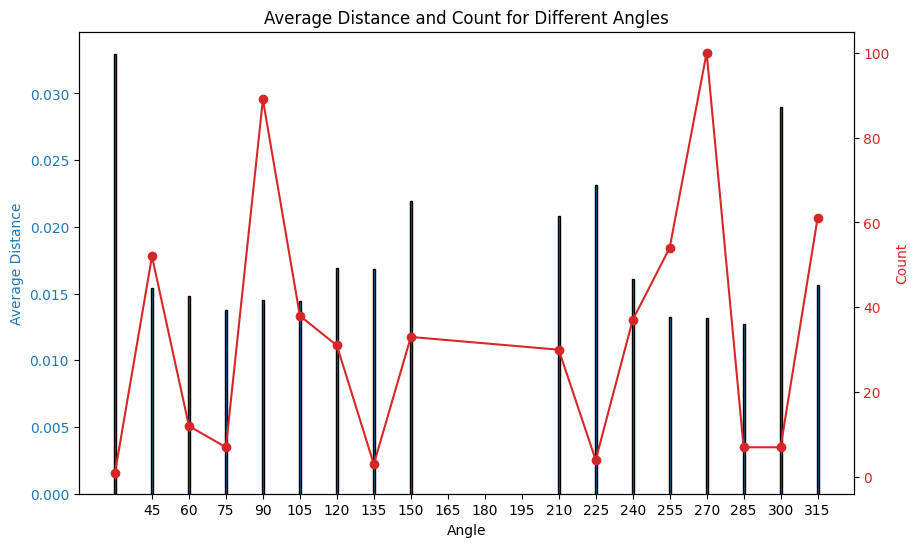

In [18]:
custom_ticks = list(range(45, 361, 15))

with mlflow.start_run(run_name=name):
    # Log model parameters if needed
    # Log the PyTorch model
    mlflow.pytorch.log_model(model, "keypoint_model")
    
    mlflow.log_metrics({
        "test_avg_distance":dis 
    })

    # Your plotting code
    summary_data = df.groupby('Angle')['Average Distance'].agg(['mean', 'count'])

    custom_ticks = list(range(45, 361, 15))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Angle')
    ax1.set_ylabel('Average Distance', color=color)
    ax1.bar(summary_data.index, summary_data['mean'], color=color, edgecolor='black')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(custom_ticks)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Count', color=color)
    ax2.plot(summary_data.index, summary_data['count'], color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Average Distance and Count for Different Angles')

    # Save the figure
    plt.savefig('plot.png')

    # Log the figure
    mlflow.log_artifact('plot.png')

    for angle, values in summary_data.iterrows():
        mlflow.log_metrics({
            f"mean_{angle}": values['mean']
        })

In [10]:
train_no = 44
model_path = f'runs15Jan/train{train_no}/weights/best.pt'
import torch
device = torch.device('cpu')
model = YOLO(model_path)  # Or 'path/to/best.pt'
model.to(device)
dis = check_avg_dis(model)
name = f"Train_No_{train_no}"
# Log the PyTorch model with MLflow
with mlflow.start_run(run_name=name):
    # Log model parameters if needed
    # Log the PyTorch model
    mlflow.pytorch.log_model(model, "keypoint_model")
   
    mlflow.log_metrics({
        "test_avg_distance":dis 
    })


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230108161822.jpeg: 480x640 4 cars, 104.0ms
Speed: 5.8ms preprocess, 104.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230822192008.jpeg: 480x640 3 cars, 116.4ms
Speed: 7.1ms preprocess, 116.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230108161822.jpeg
right_side_view-20230822192008.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221223114144.jpeg: 480x640 2 cars, 122.3ms
Speed: 10.5ms preprocess, 122.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230113131454.jpeg: 480x640 2 cars, 90.3ms
Speed: 3.9ms preprocess, 90.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20221223114144.jpeg
rear_left_view-20230113131454.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230424151412.jpg: 512x640 1 car, 124.7ms
Speed: 4.4ms preprocess, 124.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231202151813.jpeg: 480x640 3 cars, 119.9ms
Speed: 4.3ms preprocess, 119.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230424151412.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230524174344.jpeg: 384x640 3 cars, 98.5ms
Speed: 3.6ms preprocess, 98.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20231202151813.jpeg
cover_image-20230524174344.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230505154931.jpg: 480x640 2 cars, 135.2ms
Speed: 5.2ms preprocess, 135.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230505154931.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230122230748.jpeg: 480x640 2 cars, 145.0ms
Speed: 5.2ms preprocess, 145.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221210190446.jpeg: 480x640 4 cars, 151.4ms
Speed: 5.2ms preprocess, 151.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230122230748.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240103184831.jpg: 480x640 2 cars, 119.4ms
Speed: 5.4ms preprocess, 119.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20221210190446.jpeg
right_side_view-20240103184831.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230113131505.jpeg: 480x640 3 cars, 123.5ms
Speed: 4.5ms preprocess, 123.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230113131528.jpeg: 480x640 2 cars, 121.1ms
Speed: 8.2ms preprocess, 121.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20230113131505.jpeg
rear_right_view-20230113131528.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230612171611.jpeg: 480x640 3 cars, 148.7ms
Speed: 40.8ms preprocess, 148.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230424151425.jpg: 512x640 2 cars, 127.5ms
Speed: 3.9ms preprocess, 127.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)



front_right_view-20230612171611.jpeg
No keypoints detected in front_right_view-20230612171611.jpeg
front_right_view-20230424151425.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230819134348.jpg: 480x640 1 car, 108.5ms
Speed: 4.8ms preprocess, 108.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230612171512.jpeg: 480x640 2 cars, 113.0ms
Speed: 4.9ms preprocess, 113.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230819134348.jpg
left_side_view-20230612171512.jpeg
No keypoints detected in left_side_view-20230612171512.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230221182625.jpeg: 480x640 4 cars, 120.9ms
Speed: 6.0ms preprocess, 120.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230822192036.jpeg: 480x640 5 cars, 106.5ms
Speed: 2.6ms preprocess, 106.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20230221182625.jpeg
front_right_view-20230822192036.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221223114154.jpeg: 480x640 3 cars, 108.6ms
Speed: 4.8ms preprocess, 108.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230819134335.jpg: 480x640 2 cars, 130.3ms
Speed: 4.2ms preprocess, 130.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20221223114154.jpeg
right_side_view-20230819134335.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221210190639.jpeg: 480x640 1 car, 114.2ms
Speed: 3.3ms preprocess, 114.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230505154952.jpg: 480x640 2 cars, 100.2ms
Speed: 3.9ms preprocess, 100.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20221210190639.jpeg
rear_right_view-20230505154952.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230819134319.jpg: 480x640 3 cars, 128.5ms
Speed: 4.3ms preprocess, 128.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240103184802.jpg: 480x640 1 car, 152.0ms
Speed: 3.8ms preprocess, 152.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230819134319.jpg


cover_image-20240103184802.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230122230818.jpeg: 480x640 2 cars, 343.8ms
Speed: 6.9ms preprocess, 343.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230302145907.jpg: 512x640 1 car, 120.5ms
Speed: 4.4ms preprocess, 120.5ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)



rear_left_view-20230122230818.jpeg
left_side_view-20230302145907.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221210190629.jpeg: 480x640 1 car, 131.6ms
Speed: 4.2ms preprocess, 131.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20221210190629.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231202151725.jpeg: 480x640 1 car, 124.8ms
Speed: 5.4ms preprocess, 124.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230927134157.jpeg: 640x480 3 cars, 129.6ms
Speed: 5.3ms preprocess, 129.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


cover_image-20231202151725.jpeg


rear_left_view-20230927134157.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230108161943.jpeg: 480x640 3 cars, 143.1ms
Speed: 6.3ms preprocess, 143.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20230108161943.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230705185128.jpeg: 480x640 4 cars, 127.3ms
Speed: 3.8ms preprocess, 127.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230822192017.jpeg: 480x640 2 cars, 121.4ms
Speed: 3.3ms preprocess, 121.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20230705185128.jpeg
rear_left_view-20230822192017.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230524174418.jpeg: 384x640 1 car, 137.8ms
Speed: 4.6ms preprocess, 137.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230307161432.jpg: 384x640 1 car, 100.9ms
Speed: 3.4ms preprocess, 100.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230524174418.jpeg
right_side_view-20230307161432.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230302145940.jpg: 512x640 3 cars, 131.8ms
Speed: 4.8ms preprocess, 131.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230201172302.jpg: 480x640 4 cars, 99.4ms
Speed: 3.8ms preprocess, 99.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230302145940.jpg
left_side_view-20230201172302.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230302155603.jpeg: 384x640 1 car, 120.2ms
Speed: 4.0ms preprocess, 120.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230927134142.jpeg: 480x640 3 cars, 148.7ms


cover_image-20230302155603.jpeg


Speed: 11.9ms preprocess, 148.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230612171440.jpeg: 480x640 5 cars, 148.6ms
Speed: 4.6ms preprocess, 148.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230927134142.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221223114117.jpeg: 480x640 3 cars, 127.2ms
Speed: 4.1ms preprocess, 127.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230612171440.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231214125357.jpeg: 480x640 4 cars, 125.8ms
Speed: 5.8ms preprocess, 125.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20221223114117.jpeg
cover_image-20231214125357.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230201172332.jpg: 480x640 1 car, 183.6ms
Speed: 4.2ms preprocess, 183.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230819134257.jpg: 480x640 1 car, 125.9ms
Speed: 4.3ms preprocess, 125.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230201172332.jpg
cover_image-20230819134257.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231202151746.jpeg: 480x640 3 cars, 125.9ms
Speed: 3.2ms preprocess, 125.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230108161859.jpeg: 480x640 3 cars, 90.6ms
Speed: 3.4ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20231202151746.jpeg
left_side_view-20230108161859.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221210190611.jpeg: 480x640 1 car, 105.3ms
Speed: 3.2ms preprocess, 105.3ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230108161928.jpeg: 480x640 2 cars, 120.5ms
Speed: 3.0ms preprocess, 120.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20221210190611.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221223114019.jpeg: 480x640 4 cars, 122.2ms
Speed: 4.6ms preprocess, 122.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230108161928.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230705185120.jpeg: 512x640 2 cars, 139.6ms
Speed: 3.7ms preprocess, 139.6ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


cover_image-20221223114019.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230524174509.jpeg: 384x640 4 cars, 89.7ms
Speed: 2.7ms preprocess, 89.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20230705185120.jpeg
rear_right_view-20230524174509.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230221182537.jpeg: 480x640 5 cars, 94.5ms
Speed: 2.7ms preprocess, 94.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230108161912.jpeg: 480x640 2 cars, 104.8ms
Speed: 4.4ms preprocess, 104.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230221182537.jpeg
right_side_view-20230108161912.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230307161424.jpg: 384x640 1 car, 95.7ms
Speed: 2.6ms preprocess, 95.7ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230302155640.jpeg: 384x640 1 car, 73.7ms
Speed: 3.8ms preprocess, 73.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230307161424.jpg
left_side_view-20230302155640.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230307161515.jpg: 384x640 1 car, 98.7ms
Speed: 2.7ms preprocess, 98.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230221182558.jpeg: 480x640 2 cars, 112.4ms
Speed: 4.8ms preprocess, 112.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230307161515.jpg
left_side_view-20230221182558.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230705185101.jpeg: 480x640 4 cars, 105.0ms
Speed: 4.0ms preprocess, 105.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221223114105.jpeg: 480x640 3 cars, 128.9ms
Speed: 4.0ms preprocess, 128.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230705185101.jpeg


right_side_view-20221223114105.jpeg
No keypoints detected in right_side_view-20221223114105.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230705185042.jpeg: 480x640 4 cars, 127.3ms
Speed: 5.2ms preprocess, 127.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230505154942.jpg: 480x640 1 car, 114.9ms
Speed: 4.9ms preprocess, 114.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230705185042.jpeg
front_right_view-20230505154942.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230505154937.jpg: 480x640 3 cars, 117.9ms
Speed: 3.7ms preprocess, 117.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231205165549.jpeg: 480x640 1 car, 108.7ms
Speed: 4.1ms preprocess, 108.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230505154937.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230302145917.jpg: 512x640 3 cars, 117.2ms
Speed: 3.8ms preprocess, 117.2ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)



rear_right_view-20231205165549.jpeg
rear_left_view-20230302145917.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230424151441.jpg: 512x640 2 cars, 119.4ms
Speed: 3.8ms preprocess, 119.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221223114100.jpeg: 480x640 2 cars, 94.6ms
Speed: 4.7ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230424151441.jpg
left_side_view-20221223114100.jpeg
No keypoints detected in left_side_view-20221223114100.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231214125444.jpeg: 480x640 3 cars, 78.4ms
Speed: 3.9ms preprocess, 78.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230822191933.jpeg: 480x640 3 cars, 91.2ms
Speed: 3.2ms preprocess, 91.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20231214125444.jpeg
cover_image-20230822191933.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231205165445.jpeg: 480x640 3 cars, 79.0ms
Speed: 3.0ms preprocess, 79.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230424151433.jpg: 512x640 3 cars, 98.8ms
Speed: 4.0ms preprocess, 98.8ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)



cover_image-20231205165445.jpeg
rear_left_view-20230424151433.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240103184824.jpg: 480x640 1 car, 94.2ms
Speed: 2.6ms preprocess, 94.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230302145952.jpg: 512x640 2 cars, 95.6ms
Speed: 3.2ms preprocess, 95.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)



left_side_view-20240103184824.jpg
right_side_view-20230302145952.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230705185113.jpeg: 480x640 2 cars, 102.7ms
Speed: 3.5ms preprocess, 102.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230705185113.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230524174353.jpeg: 384x640 2 cars, 470.2ms
Speed: 2.9ms preprocess, 470.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231214125428.jpeg: 480x640 2 cars, 103.5ms
Speed: 3.8ms preprocess, 103.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20230524174353.jpeg
right_side_view-20231214125428.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230524174505.jpeg: 384x640 5 cars, 86.0ms
Speed: 3.5ms preprocess, 86.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230201172323.jpg: 480x640 1 car, 92.3ms
Speed: 3.6ms preprocess, 92.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230524174505.jpeg
front_right_view-20230201172323.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230302145830.jpg: 512x640 3 cars, 177.2ms
Speed: 5.8ms preprocess, 177.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230201172315.jpg: 480x640 2 cars, 96.1ms
Speed: 4.1ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230302145830.jpg
right_side_view-20230201172315.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230302150003.jpg: 512x640 2 cars, 103.9ms
Speed: 5.4ms preprocess, 103.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230822192049.jpeg: 480x640 1 car, 87.6ms
Speed: 2.9ms preprocess, 87.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20230302150003.jpg
rear_right_view-20230822192049.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231214125416.jpeg: 480x640 3 cars, 123.0ms
Speed: 2.7ms preprocess, 123.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20230612171643.jpeg: 480x640 2 cars, 94.3ms
Speed: 4.6ms preprocess, 94.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20231214125416.jpeg
wheels_tyres-20230612171643.jpeg
No keypoints detected in wheels_tyres-20230612171643.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231205165505.jpeg: 480x640 2 cars, 114.3ms
Speed: 3.4ms preprocess, 114.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231214125451.jpeg: 480x640 3 cars, 83.5ms
Speed: 2.7ms preprocess, 83.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20231205165505.jpeg
rear_right_view-20231214125451.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240103184924.jpg: 480x640 1 car, 95.0ms
Speed: 2.4ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231202151756.jpeg: 480x640 3 cars, 100.8ms
Speed: 3.1ms preprocess, 100.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20240103184924.jpg
rear_left_view-20231202151756.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240103184914.jpg: 480x640 1 car, 90.9ms
Speed: 3.7ms preprocess, 90.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231214125438.jpeg: 480x640 2 cars, 81.7ms
Speed: 2.3ms preprocess, 81.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20240103184914.jpg
rear_left_view-20231214125438.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230122230433.jpeg: 480x640 4 cars, 76.7ms
Speed: 2.7ms preprocess, 76.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230113131436.jpeg: 480x640 3 cars, 142.3ms
Speed: 6.9ms preprocess, 142.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230122230433.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230612171549.jpeg: 480x640 3 cars, 96.2ms
Speed: 2.9ms preprocess, 96.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230113131436.jpeg
rear_left_view-20230612171549.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240103184839.jpg: 480x640 1 car, 246.0ms
Speed: 37.2ms preprocess, 246.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231205165530.jpeg: 480x640 2 cars, 85.4ms
Speed: 3.2ms preprocess, 85.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20240103184839.jpg
rear_left_view-20231205165530.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221210190605.jpeg: 480x640 2 cars, 78.1ms
Speed: 2.7ms preprocess, 78.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230612171532.jpeg: 480x640 2 cars, 84.8ms
Speed: 3.1ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



left_side_view-20221210190605.jpeg
right_side_view-20230612171532.jpeg
No keypoints detected in right_side_view-20230612171532.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230927134206.jpeg: 640x480 3 cars, 97.1ms
Speed: 2.6ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230612171623.jpeg: 480x640 3 cars, 148.5ms
Speed: 3.8ms preprocess, 148.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230927134206.jpeg
No keypoints detected in front_right_view-20230927134206.jpeg
rear_right_view-20230612171623.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230505154915.jpg: 480x640 1 car, 73.7ms
Speed: 2.6ms preprocess, 73.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230822191952.jpeg: 480x640 4 cars, 75.5ms
Speed: 2.5ms preprocess, 75.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230505154915.jpg
left_side_view-20230822191952.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230927134120.jpeg: 640x480 2 cars, 79.3ms
Speed: 3.1ms preprocess, 79.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230201172212.jpg: 480x640 2 cars, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



cover_image-20230927134120.jpeg
cover_image-20230201172212.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230221182634.jpeg: 480x640 1 car, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231205165516.jpeg: 480x640 2 cars, 64.8ms
Speed: 2.9ms preprocess, 64.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230221182634.jpeg
right_side_view-20231205165516.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230705185137.jpeg: 512x640 2 cars, 69.4ms
Speed: 2.4ms preprocess, 69.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221210190621.jpeg: 480x640 2 cars, 68.6ms
Speed: 2.2ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230705185137.jpeg
rear_left_view-20221210190621.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231205165540.jpeg: 480x640 3 cars, 59.8ms
Speed: 2.9ms preprocess, 59.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230221182606.jpeg: 480x640 3 cars, 72.6ms
Speed: 2.3ms preprocess, 72.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



front_right_view-20231205165540.jpeg
right_side_view-20230221182606.jpeg
No keypoints detected in right_side_view-20230221182606.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230201172342.jpg: 480x640 1 car, 67.3ms
Speed: 2.6ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230819134354.jpg: 480x640 1 car, 82.9ms
Speed: 8.7ms preprocess, 82.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



rear_right_view-20230201172342.jpg
rear_right_view-20230819134354.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230122230340.jpeg: 480x640 4 cars, 69.4ms
Speed: 2.7ms preprocess, 69.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230424151418.jpg: 512x640 1 car, 117.7ms
Speed: 2.3ms preprocess, 117.7ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)



cover_image-20230122230340.jpeg
right_side_view-20230424151418.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230221182616.jpeg: 480x640 3 cars, 135.8ms
Speed: 5.7ms preprocess, 135.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231202151806.jpeg: 480x640 1 car, 86.2ms
Speed: 2.9ms preprocess, 86.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



rear_left_view-20230221182616.jpeg
front_right_view-20231202151806.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230113131414.jpeg: 480x640 4 cars, 72.9ms
Speed: 2.4ms preprocess, 72.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230307161503.jpg: 384x640 1 car, 54.7ms
Speed: 2.6ms preprocess, 54.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230122230835.jpeg: 480x640 1 car, 71.8ms
Speed: 2.9ms preprocess, 71.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230113131414.jpeg
rear_left_view-20230307161503.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230424151340.jpg: 512x640 1 car, 73.3ms
Speed: 2.4ms preprocess, 73.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)



front_right_view-20230122230835.jpeg
cover_image-20230424151340.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230505154947.jpg: 480x640 2 cars, 80.3ms
Speed: 2.3ms preprocess, 80.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231202151741.jpeg: 480x640 2 cars, 139.7ms
Speed: 4.9ms preprocess, 139.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230505154947.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230927134215.jpeg: 640x480 5 cars, 90.1ms
Speed: 2.4ms preprocess, 90.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)



left_side_view-20231202151741.jpeg
rear_right_view-20230927134215.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230927134146.jpeg: 480x640 4 cars, 66.7ms
Speed: 2.3ms preprocess, 66.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477528098494460.jpg: 384x640 1 car, 57.4ms
Speed: 2.4ms preprocess, 57.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477534685641985.jpg: 480x640 3 cars, 60.2ms
Speed: 2.2ms preprocess, 60.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



right_side_view-20230927134146.jpeg
No keypoints detected in right_side_view-20230927134146.jpeg
PART_1477528098494460.jpg
PART_1477534685641985.jpg
No keypoints detected in PART_1477534685641985.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-3.jpg: 384x640 3 cars, 59.5ms
Speed: 1.5ms preprocess, 59.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481212012786903.jpg: 448x640 1 car, 65.2ms
Speed: 3.4ms preprocess, 65.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-2.jpg: 384x640 1 car, 71.0ms
Speed: 1.8ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-3.jpg
PART_1481212012786903.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477281278514983.jpg: 480x640 4 cars, 73.5ms
Speed: 2.4ms preprocess, 73.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in301020231219125953-2.jpg: 384x640 1 car, 66.6ms
Speed: 1.7ms preprocess, 66.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in214320231205082545-2.jpg
PART_1477281278514983.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-2.jpg: 384x640 3 cars, 61.4ms
Speed: 1.8ms preprocess, 61.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481583051684227.jpg: 480x640 3 cars, 82.9ms
Speed: 2.7ms preprocess, 82.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


in301020231219125953-2.jpg
in502720231123120621-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477441913947488.jpg: 480x640 1 car, 70.5ms
Speed: 2.6ms preprocess, 70.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-3.jpg: 384x640 1 car, 68.8ms
Speed: 2.0ms preprocess, 68.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_1481583051684227.jpg
PART_1477441913947488.jpg
in826820231213123248-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478534944389907.jpg: 480x640 2 cars, 123.6ms
Speed: 2.4ms preprocess, 123.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-2.jpg: 384x640 1 car, 74.4ms
Speed: 2.4ms preprocess, 74.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016857709169136791652.jpg: 480x640 3 cars, 63.6ms
Speed: 2.7ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1478534944389907.jpg
in873320231124095011-2.jpg
part160016857709169136791652.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477426201017406.jpg: 480x640 2 cars, 80.0ms
Speed: 2.0ms preprocess, 80.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168907093361914891819.jpg: 480x640 1 car, 64.3ms
Speed: 3.7ms preprocess, 64.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-9.jpg: 384x640 1 car, 60.3ms
Speed: 1.8ms preprocess, 60.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



PART_1477426201017406.jpg
part1600168907093361914891819.jpg
in243120231121121717-9.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016897900455272268222.jpg: 480x640 3 cars, 62.7ms
Speed: 2.1ms preprocess, 62.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-7.jpg: 384x640 1 car, 68.9ms
Speed: 1.6ms preprocess, 68.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-6.jpg: 384x640 1 car, 48.4ms
Speed: 1.6ms preprocess, 48.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



part160016897900455272268222.jpg
in975420231211105726-7.jpg
in214320231205082545-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-4.jpg: 384x640 2 cars, 64.5ms
Speed: 1.8ms preprocess, 64.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481745169403126.jpg: 640x480 2 cars, 72.5ms
Speed: 3.5ms preprocess, 72.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-1.jpg: 384x640 1 car, 62.7ms
Speed: 1.9ms preprocess, 62.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


in745620231211145159-4.jpg
No keypoints detected in in745620231211145159-4.jpg
PART_1481745169403126.jpg
No keypoints detected in PART_1481745169403126.jpg
in214320231205082545-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481723760991902.jpg: 384x640 1 car, 69.0ms
Speed: 1.8ms preprocess, 69.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477934840240950.jpg: 480x640 2 cars, 108.0ms
Speed: 9.2ms preprocess, 108.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



PART_1481723760991902.jpg
PART_1477934840240950.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479184799422426.jpg: 480x640 3 cars, 97.5ms
Speed: 2.4ms preprocess, 97.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-1.jpg: 384x640 5 cars, 49.6ms
Speed: 1.6ms preprocess, 49.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-1.jpg: 384x640 1 car, 54.4ms
Speed: 2.1ms preprocess, 54.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



PART_1479184799422426.jpg
in265220231119103239-1.jpg
in799620231218081737-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-6.jpg: 384x640 1 car, 70.0ms
Speed: 1.9ms preprocess, 70.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-3.jpg: 384x640 1 car, 44.9ms
Speed: 1.6ms preprocess, 44.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-7.jpg: 384x640 1 car, 42.7ms
Speed: 1.6ms preprocess, 42.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



in411620231220133737-6.jpg
in646920231218133357-3.jpg
in873320231124095011-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482487534261722.jpg: 480x640 2 cars, 72.8ms
Speed: 2.7ms preprocess, 72.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482852216802389.jpg: 480x640 4 cars, 69.8ms
Speed: 2.6ms preprocess, 69.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168252609604631156929.jpg: 480x640 4 cars, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1482487534261722.jpg
PART_1482852216802389.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-2.jpg: 384x640 1 car, 65.8ms
Speed: 2.3ms preprocess, 65.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-2.jpg: 384x640 1 car, 51.1ms
Speed: 1.8ms preprocess, 51.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



part1600168252609604631156929.jpg
No keypoints detected in part1600168252609604631156929.jpg
in292820231124100518-2.jpg
in161920231119111435-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483803963334515.jpg: 384x640 2 cars, 64.6ms
Speed: 1.8ms preprocess, 64.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-5.jpg: 384x640 2 cars, 59.6ms
Speed: 1.7ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168662435360421798415.jpg: 480x640 1 car, 76.3ms
Speed: 4.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1483803963334515.jpg
in642120231213085757-5.jpg
part1600168662435360421798415.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482366796132742.jpg: 480x640 2 cars, 91.0ms
Speed: 2.3ms preprocess, 91.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3558863405494105.jpg: 480x640 3 cars, 149.3ms
Speed: 7.1ms preprocess, 149.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


PART_1482366796132742.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-7.jpg: 384x640 3 cars, 117.6ms
Speed: 2.9ms preprocess, 117.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



PART_3558863405494105.jpg
in547220231123124841-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481545463689331.jpg: 480x640 2 cars, 126.3ms
Speed: 7.2ms preprocess, 126.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168283154369834518600.jpg: 480x640 2 cars, 101.3ms
Speed: 34.6ms preprocess, 101.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



PART_1481545463689331.jpg
part1600168283154369834518600.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-1.jpg: 384x640 3 cars, 66.5ms
Speed: 2.2ms preprocess, 66.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477167228078692.jpg: 384x640 1 car, 48.3ms
Speed: 1.5ms preprocess, 48.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-2.jpg: 384x640 2 cars, 44.8ms
Speed: 1.4ms preprocess, 44.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



in411620231220133737-1.jpg
PART_1477167228078692.jpg
in547220231123124841-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479768679758253.jpg: 480x640 2 cars, 212.6ms
Speed: 4.6ms preprocess, 212.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168923838974728586003.jpg: 480x640 4 cars, 53.1ms
Speed: 2.3ms preprocess, 53.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482595858580953.jpg: 480x640 2 cars, 61.2ms
Speed: 2.1ms preprocess, 61.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



PART_1479768679758253.jpg
No keypoints detected in PART_1479768679758253.jpg
part1600168923838974728586003.jpg
PART_1482595858580953.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169062422420571213895.jpg: 480x640 3 cars, 59.3ms
Speed: 2.7ms preprocess, 59.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-9.jpg: 384x640 1 car, 103.9ms
Speed: 2.9ms preprocess, 103.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



part1600169062422420571213895.jpg
in646920231218133357-9.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483788146793608.jpg: 480x640 4 cars, 109.0ms
Speed: 4.4ms preprocess, 109.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-3.jpg: 384x640 2 cars, 124.0ms
Speed: 5.2ms preprocess, 124.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



PART_1483788146793608.jpg
in975420231211105726-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479382118154593.jpg: 480x640 4 cars, 135.8ms
Speed: 7.6ms preprocess, 135.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482640794032106.jpg: 480x640 2 cars, 151.9ms
Speed: 3.6ms preprocess, 151.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


PART_1479382118154593.jpg


PART_1482640794032106.jpg
No keypoints detected in PART_1482640794032106.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016837502979981204271.jpg: 480x640 2 cars, 192.2ms
Speed: 6.8ms preprocess, 192.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



part160016837502979981204271.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-2.jpg: 384x640 1 car, 318.6ms
Speed: 4.4ms preprocess, 318.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478464287971743.jpg: 480x640 2 cars, 55.3ms
Speed: 2.6ms preprocess, 55.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-5.jpg: 384x640 2 cars, 46.7ms
Speed: 1.5ms preprocess, 46.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



in821820231219130304-2.jpg
PART_1478464287971743.jpg
in821820231219130304-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482847017922559.jpg: 480x640 2 cars, 81.2ms
Speed: 2.6ms preprocess, 81.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-4.jpg: 384x640 1 car, 51.0ms
Speed: 2.1ms preprocess, 51.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480002566827727.jpg: 480x640 3 cars, 82.3ms
Speed: 3.1ms preprocess, 82.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1482847017922559.jpg
in646920231218133357-4.jpg
PART_1480002566827727.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481908693906672.jpg: 480x640 4 cars, 105.0ms
Speed: 23.7ms preprocess, 105.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-3.jpg: 384x640 2 cars, 71.8ms
Speed: 3.0ms preprocess, 71.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-5.jpg: 384x640 1 car, 59.3ms
Speed: 1.8ms preprocess, 59.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


PART_1481908693906672.jpg
in214320231205082545-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-7.jpg: 384x640 1 car, 110.4ms
Speed: 3.3ms preprocess, 110.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)



in745620231211145159-5.jpg
in292820231124100518-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478058867586331.jpg: 480x640 4 cars, 150.1ms
Speed: 12.9ms preprocess, 150.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-6.jpg: 384x640 1 car, 125.7ms
Speed: 3.3ms preprocess, 125.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



PART_1478058867586331.jpg
in642120231213085757-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479466445456510.jpg: 480x640 3 cars, 156.2ms
Speed: 5.0ms preprocess, 156.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



PART_1479466445456510.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-7.jpg: 384x640 2 cars, 407.7ms
Speed: 4.8ms preprocess, 407.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in411620231220133737-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3562436545529405.jpg: 480x640 2 cars, 167.9ms
Speed: 3.2ms preprocess, 167.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478189478050087.jpg: 480x640 2 cars, 122.1ms
Speed: 3.4ms preprocess, 122.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)



PART_3562436545529405.jpg
PART_1478189478050087.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478299856204165.jpg: 480x640 2 cars, 144.6ms
Speed: 4.4ms preprocess, 144.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-2.jpg: 384x640 2 cars, 120.4ms
Speed: 3.5ms preprocess, 120.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



PART_1478299856204165.jpg
in535020231211135109-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168588606433457854332.jpg: 480x640 3 cars, 154.3ms
Speed: 5.0ms preprocess, 154.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-1.jpg: 384x640 2 cars, 102.9ms
Speed: 2.7ms preprocess, 102.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



part1600168588606433457854332.jpg
No keypoints detected in part1600168588606433457854332.jpg
in502720231123120621-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-3.jpg: 384x640 3 cars, 68.9ms
Speed: 2.5ms preprocess, 68.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477405746854617.jpg: 480x640 4 cars, 98.0ms
Speed: 3.1ms preprocess, 98.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



in755420231116153659-3.jpg
PART_1477405746854617.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168350220297825094927.jpg: 480x640 4 cars, 80.5ms
Speed: 2.4ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-2.jpg: 384x640 1 car, 73.0ms
Speed: 1.9ms preprocess, 73.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



part1600168350220297825094927.jpg
in763620231121114511-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-7.jpg: 384x640 1 car, 78.1ms
Speed: 39.9ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-6.jpg: 384x640 1 car, 88.3ms
Speed: 3.0ms preprocess, 88.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in957620231218121623-7.jpg
in535020231211135109-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559764612050941.jpg: 480x640 4 cars, 90.9ms
Speed: 3.5ms preprocess, 90.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



PART_3559764612050941.jpg
No keypoints detected in PART_3559764612050941.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480738532743538.jpg: 512x640 3 cars, 264.7ms
Speed: 10.0ms preprocess, 264.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016877186097642093317.jpg: 480x640 1 car, 108.4ms
Speed: 13.8ms preprocess, 108.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



PART_1480738532743538.jpg
No keypoints detected in PART_1480738532743538.jpg
part160016877186097642093317.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168293598191588001496.jpg: 480x640 2 cars, 163.4ms
Speed: 7.2ms preprocess, 163.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480453911124456.jpg: 480x640 3 cars, 93.7ms
Speed: 4.3ms preprocess, 93.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



part1600168293598191588001496.jpg
PART_1480453911124456.jpg
No keypoints detected in PART_1480453911124456.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-6.jpg: 384x640 2 cars, 68.9ms
Speed: 1.7ms preprocess, 68.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-7.jpg: 384x640 2 cars, 132.1ms


in265220231119103239-6.jpg


Speed: 31.0ms preprocess, 132.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-6.jpg: 384x640 1 car, 103.6ms
Speed: 3.7ms preprocess, 103.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



in836320231214150909-7.jpg
in161920231119111435-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-3.jpg: 384x640 4 cars, 67.4ms
Speed: 1.9ms preprocess, 67.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part16001690477971644463261.jpg: 480x640 3 cars, 71.7ms
Speed: 2.4ms preprocess, 71.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-7.jpg: 384x640 4 cars, 71.1ms
Speed: 2.2ms preprocess, 71.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in502720231123120621-3.jpg
part16001690477971644463261.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4395181456302878.jpg: 480x640 3 cars, 73.8ms
Speed: 2.3ms preprocess, 73.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



in265220231119103239-7.jpg
PART_4395181456302878.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478870985931474.jpg: 480x640 2 cars, 75.1ms
Speed: 2.7ms preprocess, 75.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-6.jpg: 384x640 2 cars, 71.3ms
Speed: 2.5ms preprocess, 71.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-5.jpg: 384x640 2 cars, 49.1ms
Speed: 1.9ms preprocess, 49.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


PART_1478870985931474.jpg
No keypoints detected in PART_1478870985931474.jpg
in957620231218121623-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1484079026295772.jpg: 480x640 2 cars, 96.7ms
Speed: 24.0ms preprocess, 96.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



in763620231121114511-5.jpg
PART_1484079026295772.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168224745465570190870.jpg: 640x480 4 cars, 70.9ms
Speed: 2.7ms preprocess, 70.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478441604224371.jpg: 384x640 1 car, 70.4ms
Speed: 1.6ms preprocess, 70.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-2.jpg: 384x640 1 car, 63.2ms
Speed: 2.2ms preprocess, 63.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


part1600168224745465570190870.jpg
No keypoints detected in part1600168224745465570190870.jpg
PART_1478441604224371.jpg
in642120231213085757-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-2.jpg: 384x640 3 cars, 49.9ms
Speed: 2.3ms preprocess, 49.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477785823946919.jpg: 480x640 3 cars, 73.3ms
Speed: 2.8ms preprocess, 73.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481910397927490.jpg: 480x640 4 cars, 71.6ms
Speed: 2.8ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


in799620231218081737-2.jpg
PART_1477785823946919.jpg
No keypoints detected in PART_1477785823946919.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-7.jpg: 384x640 4 cars, 56.0ms
Speed: 1.6ms preprocess, 56.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479255219713006.jpg: 480x640 2 cars, 74.4ms
Speed: 3.6ms preprocess, 74.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1481910397927490.jpg
in646920231218133357-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-7.jpg: 384x640 1 car, 87.7ms
Speed: 4.3ms preprocess, 87.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



PART_1479255219713006.jpg
in821820231219130304-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4495593076167055.jpg: 480x640 6 cars, 77.4ms
Speed: 2.3ms preprocess, 77.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-3.jpg: 384x640 2 cars, 54.2ms
Speed: 1.7ms preprocess, 54.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479952879597662.jpg: 480x640 2 cars, 61.6ms
Speed: 2.4ms preprocess, 61.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)



PART_4495593076167055.jpg
in411620231220133737-3.jpg
PART_1479952879597662.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-5.jpg: 384x640 1 car, 89.6ms
Speed: 3.0ms preprocess, 89.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-2.jpg: 384x640 1 car, 120.3ms
Speed: 2.0ms preprocess, 120.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



in547220231123124841-5.jpg
in928020231220093827-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168487347574271567380.jpg: 480x640 3 cars, 91.1ms
Speed: 5.5ms preprocess, 91.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560588209651776.jpg: 352x640 1 car, 52.9ms
Speed: 1.8ms preprocess, 52.9ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478411529869910.jpg: 480x640 2 cars, 53.4ms
Speed: 2.0ms preprocess, 53.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



part1600168487347574271567380.jpg
PART_3560588209651776.jpg
PART_1478411529869910.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-2.jpg: 384x640 1 car, 45.4ms
Speed: 2.6ms preprocess, 45.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-5.jpg: 384x640 2 cars, 60.5ms
Speed: 27.2ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-2.jpg: 384x640 2 cars, 53.0ms
Speed: 1.7ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in957620231218121623-2.jpg
in836320231214150909-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-1.jpg: 384x640 1 car, 44.4ms
Speed: 1.7ms preprocess, 44.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168263144558438189588.jpg: 480x640 2 cars, 52.6ms
Speed: 2.2ms preprocess, 52.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



in755420231116153659-2.jpg
in292820231124100518-1.jpg
part1600168263144558438189588.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479354265937997.jpg: 480x640 3 cars, 74.5ms
Speed: 1.9ms preprocess, 74.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482606483220424.jpg: 384x640 1 car, 54.8ms
Speed: 2.0ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483210320995706.jpg: 512x640 2 cars, 60.1ms
Speed: 3.0ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)



PART_1479354265937997.jpg
PART_1482606483220424.jpg
PART_1483210320995706.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-5.jpg: 384x640 2 cars, 56.5ms
Speed: 2.2ms preprocess, 56.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483841811166102.jpg: 320x640 3 cars, 48.4ms
Speed: 1.6ms preprocess, 48.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559628291981744.jpg: 480x640 3 cars, 64.9ms
Speed: 2.3ms preprocess, 64.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



in799620231218081737-5.jpg
No keypoints detected in in799620231218081737-5.jpg
PART_1483841811166102.jpg
PART_3559628291981744.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483616823760075.jpg: 384x640 1 car, 53.3ms
Speed: 1.6ms preprocess, 53.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560577313968785.jpg: 480x640 2 cars, 76.1ms
Speed: 2.6ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



PART_1483616823760075.jpg
PART_3560577313968785.jpg
No keypoints detected in PART_3560577313968785.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4408179695317297.jpg: 480x640 3 cars, 74.0ms
Speed: 2.0ms preprocess, 74.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4394079952521361.jpg: 384x640 2 cars, 55.9ms
Speed: 1.7ms preprocess, 55.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-7.jpg: 384x640 3 cars, 52.9ms
Speed: 1.8ms preprocess, 52.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



PART_4408179695317297.jpg
PART_4394079952521361.jpg
in502720231123120621-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168470297537621523720.jpg: 480x640 2 cars, 66.5ms
Speed: 3.3ms preprocess, 66.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-3.jpg: 384x640 4 cars, 62.8ms
Speed: 2.1ms preprocess, 62.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



part1600168470297537621523720.jpg
in873320231124095011-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479475397923700.jpg: 480x640 3 cars, 76.8ms
Speed: 2.3ms preprocess, 76.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-7.jpg: 384x640 3 cars, 42.1ms
Speed: 1.8ms preprocess, 42.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-6.jpg: 384x640 1 car, 58.8ms
Speed: 1.8ms preprocess, 58.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



PART_1479475397923700.jpg
in214320231205082545-7.jpg
in975420231211105726-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-5.jpg: 384x640 2 cars, 65.3ms
Speed: 1.5ms preprocess, 65.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-1.jpg: 384x640 1 car, 51.3ms
Speed: 2.2ms preprocess, 51.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



in646920231218133357-5.jpg
in836320231214150909-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168340251687826694940.jpg: 480x640 2 cars, 99.3ms
Speed: 3.2ms preprocess, 99.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-5.jpg: 384x640 2 cars, 98.3ms
Speed: 3.2ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



part1600168340251687826694940.jpg
in502720231123120621-5.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483248120468209.jpg: 480x640 3 cars, 148.3ms
Speed: 4.5ms preprocess, 148.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478558445769340.jpg: 480x640 4 cars, 71.0ms
Speed: 2.1ms preprocess, 71.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482225318351645.jpg: 320x640 2 cars, 37.4ms
Speed: 1.3ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)



PART_1483248120468209.jpg
PART_1478558445769340.jpg
No keypoints detected in PART_1478558445769340.jpg
PART_1482225318351645.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-3.jpg: 384x640 4 cars, 46.6ms
Speed: 1.4ms preprocess, 46.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483496885531519.jpg: 480x640 3 cars, 51.5ms
Speed: 2.2ms preprocess, 51.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3561229220430928.jpg: 384x640 4 cars, 71.9ms
Speed: 1.6ms preprocess, 71.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in799620231218081737-3.jpg
PART_1483496885531519.jpg
PART_3561229220430928.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168535186414285141985.jpg: 480x640 2 cars, 116.8ms
Speed: 4.1ms preprocess, 116.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016883371158994760719.jpg: 384x640 2 cars, 76.0ms
Speed: 2.1ms preprocess, 76.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



part1600168535186414285141985.jpg
part160016883371158994760719.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478134314872619.jpg: 480x640 2 cars, 68.6ms
Speed: 3.0ms preprocess, 68.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3496373593011785.jpg: 320x640 1 car, 39.8ms
Speed: 1.6ms preprocess, 39.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477414637212916.jpg: 480x640 2 cars, 93.2ms
Speed: 3.3ms preprocess, 93.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



PART_1478134314872619.jpg
PART_3496373593011785.jpg
PART_1477414637212916.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168313507412441456967.jpg: 480x640 2 cars, 105.7ms
Speed: 7.5ms preprocess, 105.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481117392640398.jpg: 480x640 2 cars, 110.0ms
Speed: 5.5ms preprocess, 110.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



part1600168313507412441456967.jpg
PART_1481117392640398.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480147557590644.jpg: 384x640 1 car, 112.0ms
Speed: 3.4ms preprocess, 112.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4411723625968720.jpg: 480x640 3 cars, 102.9ms
Speed: 5.6ms preprocess, 102.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



PART_1480147557590644.jpg
PART_4411723625968720.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479099483545485.jpg: 480x640 3 cars, 118.5ms
Speed: 2.7ms preprocess, 118.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483923120256926.jpg: 512x640 1 car, 116.7ms
Speed: 39.4ms preprocess, 116.7ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)



PART_1479099483545485.jpg
PART_1483923120256926.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-7.jpg: 384x640 1 car, 82.4ms
Speed: 1.9ms preprocess, 82.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016863579581974467775.jpg: 480x640 1 car, 65.4ms
Speed: 2.2ms preprocess, 65.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480786645946999.jpg: 384x640 2 cars, 66.8ms
Speed: 2.1ms preprocess, 66.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



in161920231119111435-7.jpg
part160016863579581974467775.jpg
PART_1480786645946999.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1484033936623199.jpg: 480x640 2 cars, 63.8ms
Speed: 2.0ms preprocess, 63.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478701545065743.jpg: 480x640 4 cars, 80.7ms
Speed: 2.7ms preprocess, 80.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4396074210422407.jpg: 320x640 1 car, 47.3ms
Speed: 3.2ms preprocess, 47.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


PART_1484033936623199.jpg
PART_1478701545065743.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-3.jpg: 384x640 3 cars, 71.4ms
Speed: 1.7ms preprocess, 71.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



PART_4396074210422407.jpg
in292820231124100518-3.jpg
No keypoints detected in in292820231124100518-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-7.jpg: 384x640 1 car, 95.7ms
Speed: 4.9ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-3.jpg: 384x640 1 car, 70.6ms
Speed: 4.4ms preprocess, 70.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481724691739913.jpg: 480x640 3 cars, 72.3ms


in799620231218081737-7.jpg
in957620231218121623-3.jpg


Speed: 2.1ms preprocess, 72.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478705006293172.jpg: 448x640 1 car, 74.2ms
Speed: 2.3ms preprocess, 74.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)



PART_1481724691739913.jpg
PART_1478705006293172.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478630273066489.jpg: 480x640 3 cars, 123.6ms
Speed: 2.6ms preprocess, 123.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481478716227158.jpg: 480x640 3 cars, 93.2ms
Speed: 3.2ms preprocess, 93.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)



PART_1478630273066489.jpg
PART_1481478716227158.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-2.jpg: 384x640 1 car, 79.8ms
Speed: 2.2ms preprocess, 79.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559026759844316.jpg: 480x640 2 cars, 92.1ms
Speed: 3.2ms preprocess, 92.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



in836320231214150909-2.jpg
PART_3559026759844316.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-6.jpg: 384x640 3 cars, 66.1ms
Speed: 2.6ms preprocess, 66.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-3.jpg: 384x640 4 cars, 72.4ms
Speed: 2.6ms preprocess, 72.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



in799620231218081737-6.jpg
in821820231219130304-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-6.jpg: 384x640 1 car, 74.5ms
Speed: 2.1ms preprocess, 74.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482832106532585.jpg: 480x640 2 cars, 94.4ms
Speed: 3.6ms preprocess, 94.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



in873320231124095011-6.jpg
PART_1482832106532585.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-7.jpg: 384x640 3 cars, 96.9ms
Speed: 2.3ms preprocess, 96.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-7.jpg: 384x640 1 car, 148.7ms
Speed: 2.6ms preprocess, 148.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477607400418254.jpg: 448x640 1 car, 88.4ms
Speed: 3.8ms preprocess, 88.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)



in745620231211145159-7.jpg
PART_1477607400418254.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4397024580852166.jpg: 480x640 4 cars, 265.0ms
Speed: 38.3ms preprocess, 265.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3558690236844843.jpg: 384x640 2 cars, 82.4ms
Speed: 6.4ms preprocess, 82.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



PART_4397024580852166.jpg
PART_3558690236844843.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-6.jpg: 384x640 1 car, 80.2ms
Speed: 2.2ms preprocess, 80.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479759940598498.jpg: 480x640 3 cars, 73.2ms
Speed: 2.5ms preprocess, 73.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-2.jpg: 384x640 1 car, 60.3ms
Speed: 1.4ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



in502720231123120621-6.jpg
PART_1479759940598498.jpg
in975420231211105726-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-3.jpg: 384x640 2 cars, 55.4ms
Speed: 1.5ms preprocess, 55.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-8.jpg: 384x640 1 car, 67.0ms
Speed: 1.6ms preprocess, 67.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-8.jpg: 384x640 1 car, 58.1ms
Speed: 1.8ms preprocess, 58.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



in763620231121114511-3.jpg
in957620231218121623-8.jpg
in646920231218133357-8.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-6.jpg: 384x640 1 car, 61.1ms
Speed: 1.7ms preprocess, 61.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-1.jpg: 384x640 1 car, 67.5ms
Speed: 2.0ms preprocess, 67.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168555366341865634231.jpg: 320x640 1 car, 49.2ms
Speed: 2.0ms preprocess, 49.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)



in928020231220093827-6.jpg
in821820231219130304-1.jpg
part1600168555366341865634231.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479562395975901.jpg: 480x640 3 cars, 72.2ms
Speed: 2.3ms preprocess, 72.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-6.jpg: 384x640 3 cars, 114.5ms
Speed: 3.9ms preprocess, 114.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



PART_1479562395975901.jpg
in779120231119152124-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168503074404727423169.jpg: 480x640 3 cars, 70.2ms
Speed: 2.5ms preprocess, 70.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-5.jpg: 384x640 2 cars, 55.3ms
Speed: 1.4ms preprocess, 55.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481672883470520.jpg: 480x640 1 car, 65.9ms
Speed: 2.8ms preprocess, 65.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



part1600168503074404727423169.jpg
in755420231116153659-5.jpg
PART_1481672883470520.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478486328015152.jpg: 480x640 4 cars, 68.5ms
Speed: 2.1ms preprocess, 68.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-7.jpg: 384x640 2 cars, 124.9ms
Speed: 6.7ms preprocess, 124.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



PART_1478486328015152.jpg
in779120231119152124-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-1.jpg: 384x640 3 cars, 66.6ms
Speed: 1.8ms preprocess, 66.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-6.jpg: 384x640 2 cars, 59.9ms
Speed: 2.0ms preprocess, 59.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-1.jpg: 384x640 2 cars, 55.7ms
Speed: 1.5ms preprocess, 55.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



in928020231220093827-1.jpg
in292820231124100518-6.jpg
in642120231213085757-1.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-3.jpg: 384x640 4 cars, 59.1ms
Speed: 2.0ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016850320663952748547.jpg: 480x640 2 cars, 72.6ms
Speed: 2.1ms preprocess, 72.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



in265220231119103239-3.jpg
part160016850320663952748547.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-2.jpg: 384x640 2 cars, 72.2ms
Speed: 1.9ms preprocess, 72.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-7.jpg: 384x640 2 cars, 71.8ms
Speed: 9.7ms preprocess, 71.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



in826820231213123248-2.jpg
in755420231116153659-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483040902570112.jpg: 512x640 3 cars, 77.1ms
Speed: 3.1ms preprocess, 77.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168748451614186364646.jpg: 480x640 2 cars, 67.3ms
Speed: 2.3ms preprocess, 67.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



PART_1483040902570112.jpg
part1600168748451614186364646.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4409875392172994.jpg: 480x640 3 cars, 69.2ms
Speed: 2.2ms preprocess, 69.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481902021627340.jpg: 480x640 2 cars, 66.6ms
Speed: 1.9ms preprocess, 66.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3564205062841876.jpg: 480x640 2 cars, 68.6ms
Speed: 2.3ms preprocess, 68.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


PART_4409875392172994.jpg
PART_1481902021627340.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480211880582672.jpg: 480x640 2 cars, 71.9ms
Speed: 2.5ms preprocess, 71.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-8.jpg: 384x640 1 car, 63.0ms
Speed: 1.5ms preprocess, 63.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



PART_3564205062841876.jpg
PART_1480211880582672.jpg
in243120231121121717-8.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-5.jpg: 384x640 6 cars, 62.5ms
Speed: 2.1ms preprocess, 62.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-6.jpg: 384x640 1 car, 59.2ms
Speed: 1.6ms preprocess, 59.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016854286321624513875.jpg: 480x640 3 cars, 86.2ms
Speed: 2.6ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


in292820231124100518-5.jpg
No keypoints detected in in292820231124100518-5.jpg
in826820231213123248-6.jpg
part160016854286321624513875.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479059081086908.jpg: 480x640 2 cars, 77.9ms
Speed: 2.9ms preprocess, 77.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168366004084637756878.jpg: 480x640 2 cars, 81.8ms
Speed: 4.8ms preprocess, 81.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-6.jpg: 384x640 1 car, 60.8ms
Speed: 1.4ms preprocess, 60.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_1479059081086908.jpg
part1600168366004084637756878.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-6.jpg: 384x640 1 car, 53.8ms
Speed: 2.3ms preprocess, 53.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



in755420231116153659-6.jpg
in821820231219130304-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481593495821827.jpg: 480x640 1 car, 107.1ms
Speed: 2.7ms preprocess, 107.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-5.jpg: 384x640 1 car, 79.6ms
Speed: 2.3ms preprocess, 79.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478329502958288.jpg: 480x640 3 cars, 61.4ms
Speed: 2.1ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1481593495821827.jpg
in411620231220133737-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560027113760653.jpg: 480x640 2 cars, 78.0ms
Speed: 2.3ms preprocess, 78.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-7.jpg: 384x640 2 cars, 54.8ms
Speed: 1.6ms preprocess, 54.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


PART_1478329502958288.jpg
PART_3560027113760653.jpg
in763620231121114511-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-5.jpg: 384x640 1 car, 60.9ms
Speed: 1.6ms preprocess, 60.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480293754514517.jpg: 480x640 3 cars, 64.4ms
Speed: 2.7ms preprocess, 64.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-6.jpg: 384x640 1 car, 59.4ms
Speed: 1.9ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



in826820231213123248-5.jpg
PART_1480293754514517.jpg
No keypoints detected in PART_1480293754514517.jpg
in836320231214150909-6.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481446473131123.jpg: 480x640 2 cars, 165.9ms
Speed: 6.7ms preprocess, 165.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-2.jpg: 384x640 2 cars, 140.1ms
Speed: 4.2ms preprocess, 140.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



PART_1481446473131123.jpg
in265220231119103239-2.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478141726362045.jpg: 480x640 3 cars, 72.9ms
Speed: 3.3ms preprocess, 72.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-6.jpg: 384x640 1 car, 50.1ms
Speed: 2.6ms preprocess, 50.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-7.jpg: 384x640 2 cars, 62.1ms
Speed: 1.7ms preprocess, 62.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



PART_1478141726362045.jpg
in763620231121114511-6.jpg
in535020231211135109-7.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-4.jpg: 384x640 5 cars, 88.2ms
Speed: 4.0ms preprocess, 88.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168372784216486895332.jpg: 448x640 1 car, 67.9ms
Speed: 2.3ms preprocess, 67.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-3.jpg: 384x640 2 cars, 59.6ms
Speed: 2.1ms preprocess, 59.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-4.jpg
part1600168372784216486895332.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477472546470809.jpg: 480x640 1 car, 103.6ms
Speed: 5.0ms preprocess, 103.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



in535020231211135109-3.jpg
PART_1477472546470809.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-4.jpg: 384x640 1 car, 70.9ms
Speed: 2.9ms preprocess, 70.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483643331452636.jpg: 384x640 1 car, 58.8ms
Speed: 2.1ms preprocess, 58.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479515160134545.jpg: 480x640 1 car, 55.3ms
Speed: 2.0ms preprocess, 55.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)



in243120231121121717-4.jpg
PART_1483643331452636.jpg
PART_1479515160134545.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482641886229208.jpg: 480x640 2 cars, 64.8ms
Speed: 3.1ms preprocess, 64.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-2.jpg: 384x640 4 cars, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477786870210365.jpg: 480x640 1 car, 72.2ms
Speed: 3.5ms preprocess, 72.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


PART_1482641886229208.jpg
in779120231119152124-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-5.jpg: 384x640 1 car, 68.7ms
Speed: 1.8ms preprocess, 68.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481664768556479.jpg: 448x640 3 cars, 68.7ms
Speed: 2.7ms preprocess, 68.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


PART_1477786870210365.jpg
in214320231205082545-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483441612726530.jpg: 320x640 1 car, 49.1ms
Speed: 1.5ms preprocess, 49.1ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-3.jpg: 384x640 3 cars, 60.6ms
Speed: 2.3ms preprocess, 60.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



PART_1481664768556479.jpg
PART_1483441612726530.jpg
in836320231214150909-3.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169077456680518725884.jpg: 480x640 2 cars, 78.3ms
Speed: 2.2ms preprocess, 78.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483108249233619.jpg: 512x640 3 cars, 59.5ms
Speed: 2.7ms preprocess, 59.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169090973281685103148.jpg: 480x640 3 cars, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


part1600169077456680518725884.jpg
PART_1483108249233619.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169008038940490818014.jpg: 480x640 2 cars, 114.3ms
Speed: 7.7ms preprocess, 114.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)



part1600169090973281685103148.jpg
part1600169008038940490818014.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230803123236.jpeg: 384x640 2 cars, 64.5ms
Speed: 2.2ms preprocess, 64.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231008101255.jpg: 384x640 3 cars, 60.1ms
Speed: 1.7ms preprocess, 60.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230808130147.jpeg: 384x640 1 car, 62.1ms
Speed: 1.5ms preprocess, 62.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230803123236.jpeg
cover_image-20231008101255.jpg
cover_image-20230808130147.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230922181923.jpeg: 384x640 2 cars, 79.2ms
Speed: 2.2ms preprocess, 79.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231129110435.jpg: 384x640 1 car, 72.4ms
Speed: 2.1ms preprocess, 72.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230811143949.jpeg: 384x640 1 car, 57.0ms
Speed: 1.8ms preprocess, 57.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230922181923.jpeg
front_right_view-20231129110435.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231010184313.jpg: 384x640 2 cars, 65.2ms
Speed: 2.4ms preprocess, 65.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231214103426.jpg: 384x640 1 car, 53.9ms
Speed: 3.2ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230811143949.jpeg
front_right_view-20231010184313.jpg
rear_left_view-20231214103426.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230808130415.jpeg: 384x640 1 car, 70.7ms
Speed: 1.6ms preprocess, 70.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230611142129.jpg: 384x640 3 cars, 63.3ms
Speed: 1.6ms preprocess, 63.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230910101658.jpg: 384x640 2 cars, 62.4ms
Speed: 2.2ms preprocess, 62.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230808130415.jpeg
rear_right_view-20230611142129.jpg
rear_left_view-20230910101658.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231006135947.jpeg: 384x640 3 cars, 49.9ms
Speed: 1.8ms preprocess, 49.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231016185751.jpg: 384x640 3 cars, 68.6ms
Speed: 2.3ms preprocess, 68.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240103130714.jpg: 384x640 1 car, 59.4ms
Speed: 1.5ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20231006135947.jpeg
rear_left_view-20231016185751.jpg
front_right_view-20240103130714.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230929231239.jpg: 384x640 1 car, 48.9ms
Speed: 1.4ms preprocess, 48.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230522160751.jpg: 384x640 3 cars, 59.3ms
Speed: 1.7ms preprocess, 59.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231010184240.jpg: 384x640 2 cars, 58.7ms
Speed: 2.2ms preprocess, 58.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230929231239.jpg
rear_right_view-20230522160751.jpg
left_side_view-20231010184240.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231005124746.jpeg: 384x640 3 cars, 53.7ms
Speed: 1.6ms preprocess, 53.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230331174028.jpg: 384x640 2 cars, 108.9ms
Speed: 4.9ms preprocess, 108.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20231005124746.jpeg
rear_left_view-20230331174028.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231121170009.jpg: 384x640 1 car, 63.7ms
Speed: 2.3ms preprocess, 63.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230611142059.jpg: 384x640 2 cars, 68.6ms
Speed: 1.7ms preprocess, 68.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231129104249.jpg: 384x640 1 car, 70.1ms
Speed: 3.4ms preprocess, 70.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231121170009.jpg
right_side_view-20230611142059.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230519173548.jpeg: 384x640 2 cars, 60.8ms
Speed: 2.5ms preprocess, 60.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230215190012.jpeg: 384x640 2 cars, 66.5ms
Speed: 1.7ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231129104249.jpg
right_side_view-20230519173548.jpeg
rear_left_view-20230215190012.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221104130948.jpeg: 384x640 3 cars, 94.4ms
Speed: 3.1ms preprocess, 94.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231219133353.jpeg: 384x640 1 car, 97.0ms
Speed: 3.1ms preprocess, 97.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20221104130948.jpeg
cover_image-20231219133353.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231229091312.jpg: 384x640 1 car, 47.6ms
Speed: 1.7ms preprocess, 47.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231129110404.jpg: 384x640 1 car, 69.2ms
Speed: 1.8ms preprocess, 69.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231229091312.jpg
left_side_view-20231129110404.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230526143323.jpeg: 384x640 2 cars, 88.2ms
Speed: 2.1ms preprocess, 88.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240109213150.jpg: 384x640 1 car, 63.6ms
Speed: 2.3ms preprocess, 63.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231229091423.jpg: 384x640 2 cars, 54.4ms
Speed: 2.5ms preprocess, 54.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230526143323.jpeg
rear_left_view-20240109213150.jpg
rear_left_view-20231229091423.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230623143227.jpg: 384x640 1 car, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230903153432.jpg: 384x640 1 car, 63.3ms
Speed: 1.7ms preprocess, 63.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230922182127.jpeg: 384x640 2 cars, 78.0ms
Speed: 3.1ms preprocess, 78.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230623143227.jpg
left_side_view-20230903153432.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231016185803.jpg: 384x640 2 cars, 72.3ms
Speed: 1.9ms preprocess, 72.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231008101347.jpg: 384x640 1 car, 62.4ms
Speed: 2.4ms preprocess, 62.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230922182127.jpeg
rear_right_view-20231016185803.jpg
right_side_view-20231008101347.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230929231204.jpg: 384x640 1 car, 66.2ms
Speed: 1.8ms preprocess, 66.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221221130716.jpg: 384x640 2 cars, 62.6ms
Speed: 1.9ms preprocess, 62.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230929231204.jpg
rear_right_view-20221221130716.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230307161432.jpg: 384x640 1 car, 115.2ms
Speed: 2.2ms preprocess, 115.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230611142123.jpg: 384x640 2 cars, 83.7ms
Speed: 2.2ms preprocess, 83.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230307161432.jpg
rear_left_view-20230611142123.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230111141846.jpeg: 384x640 2 cars, 68.7ms
Speed: 1.8ms preprocess, 68.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230215190023.jpeg: 384x640 2 cars, 77.7ms
Speed: 2.1ms preprocess, 77.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230111141846.jpeg
front_right_view-20230215190023.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240111121000.jpg: 384x640 1 car, 114.2ms
Speed: 3.4ms preprocess, 114.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231129104342.jpg: 384x640 1 car, 51.6ms
Speed: 2.2ms preprocess, 51.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230331173829.jpg: 384x640 1 car, 60.8ms
Speed: 1.7ms preprocess, 60.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20240111121000.jpg
rear_right_view-20231129104342.jpg
cover_image-20230331173829.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20230808130429.jpeg: 384x640 1 car, 49.5ms
Speed: 1.9ms preprocess, 49.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230808130406.jpeg: 384x640 1 car, 64.2ms
Speed: 1.6ms preprocess, 64.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240109213019.jpg: 384x640 1 car, 59.7ms
Speed: 1.5ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



wheels_tyres-20230808130429.jpeg
front_right_view-20230808130406.jpeg
cover_image-20240109213019.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230623143216.jpg: 384x640 1 car, 73.5ms
Speed: 1.7ms preprocess, 73.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240103130638.jpg: 384x640 1 car, 69.0ms
Speed: 2.9ms preprocess, 69.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230111141859.jpeg: 384x640 2 cars, 59.9ms
Speed: 1.9ms preprocess, 59.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230623143216.jpg
cover_image-20240103130638.jpg
rear_left_view-20230111141859.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231129104301.jpg: 384x640 1 car, 66.9ms
Speed: 3.0ms preprocess, 66.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240103130705.jpg: 384x640 1 car, 47.5ms
Speed: 1.6ms preprocess, 47.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)




right_side_view-20231129104301.jpg
right_side_view-20240103130705.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231010184204.jpg: 384x640 3 cars, 64.4ms
Speed: 1.8ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20220502122645.jpg: 384x640 1 car, 57.8ms
Speed: 1.8ms preprocess, 57.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231129110445.jpg: 384x640 1 car, 67.7ms
Speed: 1.7ms preprocess, 67.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20231010184204.jpg
cover_image-20220502122645.jpg
rear_left_view-20231129110445.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231129104327.jpg: 384x640 1 car, 82.2ms
Speed: 1.7ms preprocess, 82.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230331173917.jpg: 384x640 2 cars, 55.2ms
Speed: 1.6ms preprocess, 55.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231008101403.jpg: 384x640 3 cars, 68.4ms
Speed: 1.9ms preprocess, 68.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20231129104327.jpg
front_right_view-20230331173917.jpg
rear_left_view-20231008101403.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230811143930.jpeg: 384x640 1 car, 133.8ms
Speed: 36.5ms preprocess, 133.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230522160726.jpg: 384x640 1 car, 69.4ms
Speed: 1.6ms preprocess, 69.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221224131311.jpeg: 384x640 1 car, 72.1ms
Speed: 1.6ms preprocess, 72.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230811143930.jpeg
left_side_view-20230522160726.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230519173630.jpeg: 384x640 1 car, 67.6ms
Speed: 4.1ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20221224131311.jpeg
rear_left_view-20230519173630.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230922182114.jpeg: 384x640 1 car, 75.5ms
Speed: 3.6ms preprocess, 75.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230522160746.jpg: 384x640 2 cars, 56.7ms
Speed: 1.7ms preprocess, 56.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230531180130.jpg: 384x640 3 cars, 69.3ms
Speed: 2.6ms preprocess, 69.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230922182114.jpeg
rear_left_view-20230522160746.jpg
rear_left_view-20230531180130.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230803123121.jpeg: 384x640 1 car, 69.1ms
Speed: 1.9ms preprocess, 69.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230331155119.jpeg: 384x640 2 cars, 93.7ms
Speed: 2.7ms preprocess, 93.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230803123121.jpeg
rear_left_view-20230331155119.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20210922134927.jpg: 384x640 1 car, 78.2ms
Speed: 4.0ms preprocess, 78.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231008101326.jpg: 384x640 1 car, 68.1ms
Speed: 2.0ms preprocess, 68.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231229091358.jpg: 384x640 2 cars, 70.6ms
Speed: 2.4ms preprocess, 70.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20210922134927.jpg
left_side_view-20231008101326.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230531180105.jpg: 384x640 3 cars, 77.1ms
Speed: 5.1ms preprocess, 77.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230307161424.jpg: 384x640 1 car, 55.1ms
Speed: 1.7ms preprocess, 55.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231229091358.jpg
left_side_view-20230531180105.jpg
left_side_view-20230307161424.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231219133604.jpeg: 384x640 2 cars, 103.8ms
Speed: 1.9ms preprocess, 103.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230331155111.jpeg: 384x640 3 cars, 102.5ms
Speed: 3.6ms preprocess, 102.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20231219133604.jpeg
front_right_view-20230331155111.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230522160738.jpg: 384x640 2 cars, 72.2ms
Speed: 2.2ms preprocess, 72.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231129104316.jpg: 384x640 1 car, 74.7ms
Speed: 2.7ms preprocess, 74.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231214103357.jpg: 384x640 2 cars, 59.5ms
Speed: 1.5ms preprocess, 59.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230522160738.jpg
front_right_view-20231129104316.jpg
right_side_view-20231214103357.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230307161515.jpg: 384x640 1 car, 61.0ms
Speed: 1.6ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231121170053.jpg: 384x640 1 car, 65.3ms
Speed: 2.1ms preprocess, 65.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230803123208.jpeg: 384x640 4 cars, 61.5ms
Speed: 1.7ms preprocess, 61.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230307161515.jpg
rear_right_view-20231121170053.jpg
rear_left_view-20230803123208.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20220502122742.jpg: 384x640 1 car, 64.4ms
Speed: 1.9ms preprocess, 64.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240103130659.jpg: 384x640 1 car, 67.1ms
Speed: 1.7ms preprocess, 67.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221104130944.jpeg: 384x640 1 car, 64.8ms
Speed: 2.1ms preprocess, 64.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20220502122742.jpg
left_side_view-20240103130659.jpg
left_side_view-20221104130944.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231219133614.jpeg: 384x640 3 cars, 58.9ms
Speed: 1.6ms preprocess, 58.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240103130737.jpg: 384x640 1 car, 65.5ms
Speed: 1.8ms preprocess, 65.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230215185956.jpeg: 384x640 1 car, 44.6ms
Speed: 1.8ms preprocess, 44.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20231219133614.jpeg
rear_right_view-20240103130737.jpg
left_side_view-20230215185956.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221104130902.jpeg: 384x640 1 car, 82.5ms
Speed: 1.8ms preprocess, 82.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221221130641.jpg: 384x640 2 cars, 105.7ms
Speed: 2.1ms preprocess, 105.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20221104130902.jpeg
rear_left_view-20221221130641.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231214103315.jpg: 384x640 3 cars, 127.4ms
Speed: 2.9ms preprocess, 127.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230526143234.jpeg: 384x640 2 cars, 99.4ms
Speed: 2.6ms preprocess, 99.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20231214103315.jpg
cover_image-20230526143234.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230803123157.jpeg: 384x640 1 car, 68.3ms
Speed: 2.1ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230910101650.jpg: 384x640 1 car, 79.0ms
Speed: 2.3ms preprocess, 79.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230803123157.jpeg
front_right_view-20230910101650.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230611142105.jpg: 384x640 2 cars, 107.7ms
Speed: 3.4ms preprocess, 107.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20231219133652.jpeg: 384x640 1 car, 63.1ms
Speed: 1.9ms preprocess, 63.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221224131231.jpeg: 384x640 3 cars, 46.0ms
Speed: 2.4ms preprocess, 46.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20230611142105.jpg
wheels_tyres-20231219133652.jpeg
cover_image-20221224131231.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230903153500.jpg: 384x640 1 car, 51.7ms
Speed: 2.4ms preprocess, 51.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240111120936.jpg: 384x640 3 cars, 64.0ms
Speed: 2.2ms preprocess, 64.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230922182100.jpeg: 384x640 2 cars, 71.7ms
Speed: 2.4ms preprocess, 71.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230903153500.jpg
cover_image-20240111120936.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231102120437.jpg: 384x640 1 car, 62.7ms
Speed: 1.9ms preprocess, 62.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230111141949.jpeg: 384x640 1 car, 60.8ms
Speed: 1.9ms preprocess, 60.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230922182100.jpeg
left_side_view-20231102120437.jpg
rear_right_view-20230111141949.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230903153516.jpg: 384x640 1 car, 67.7ms
Speed: 5.0ms preprocess, 67.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231006140120.jpeg: 384x640 2 cars, 50.3ms
Speed: 1.8ms preprocess, 50.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231121170028.jpg: 384x640 1 car, 81.9ms
Speed: 1.9ms preprocess, 81.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230903153516.jpg
rear_right_view-20231006140120.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230611142028.jpg: 384x640 3 cars, 60.6ms
Speed: 3.2ms preprocess, 60.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221221130554.jpg: 384x640 1 car, 48.0ms
Speed: 2.6ms preprocess, 48.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20231121170028.jpg
cover_image-20230611142028.jpg
right_side_view-20221221130554.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231010184251.jpg: 384x640 2 cars, 61.9ms
Speed: 1.6ms preprocess, 61.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231102120441.jpg: 384x640 1 car, 69.1ms
Speed: 16.1ms preprocess, 69.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231010184251.jpg
right_side_view-20231102120441.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230623143209.jpg: 384x640 1 car, 63.3ms
Speed: 1.7ms preprocess, 63.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231229091334.jpg: 384x640 2 cars, 63.2ms
Speed: 1.5ms preprocess, 63.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231005125331.jpeg: 384x640 1 car, 63.4ms
Speed: 1.7ms preprocess, 63.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20230623143209.jpg
right_side_view-20231229091334.jpg
right_side_view-20231005125331.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230903153523.jpg: 384x640 1 car, 65.4ms
Speed: 2.1ms preprocess, 65.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240109213118.jpg: 384x640 3 cars, 116.9ms
Speed: 3.4ms preprocess, 116.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230903153523.jpg
left_side_view-20240109213118.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231219133450.jpeg: 384x640 3 cars, 212.4ms
Speed: 3.1ms preprocess, 212.4ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231129110331.jpg: 384x640 1 car, 103.3ms
Speed: 45.2ms preprocess, 103.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231219133450.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230929231222.jpg: 384x640 2 cars, 115.5ms
Speed: 2.8ms preprocess, 115.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20231129110331.jpg
rear_left_view-20230929231222.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230811143939.jpeg: 384x640 3 cars, 65.5ms
Speed: 1.6ms preprocess, 65.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20220502122711.jpg: 384x640 1 car, 57.4ms
Speed: 2.1ms preprocess, 57.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230611142053.jpg: 384x640 1 car, 45.2ms
Speed: 2.0ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20230811143939.jpeg
left_side_view-20220502122711.jpg
left_side_view-20230611142053.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231006140051.jpeg: 384x640 2 cars, 68.9ms
Speed: 2.2ms preprocess, 68.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230811143924.jpeg: 384x640 2 cars, 62.3ms
Speed: 1.8ms preprocess, 62.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20231006140051.jpeg
right_side_view-20230811143924.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231006140031.jpeg: 384x640 1 car, 100.5ms
Speed: 8.0ms preprocess, 100.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231102120451.jpg: 384x640 1 car, 50.5ms
Speed: 1.8ms preprocess, 50.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231214103340.jpg: 384x640 1 car, 44.6ms
Speed: 2.0ms preprocess, 44.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231006140031.jpeg
rear_left_view-20231102120451.jpg
left_side_view-20231214103340.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230215185935.jpeg: 384x640 4 cars, 62.0ms
Speed: 1.7ms preprocess, 62.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230215190038.jpeg: 384x640 2 cars, 53.8ms
Speed: 2.0ms preprocess, 53.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230922182140.jpeg: 384x640 2 cars, 57.8ms
Speed: 1.6ms preprocess, 57.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230215185935.jpeg
rear_right_view-20230215190038.jpeg
front_right_view-20230922182140.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231129104222.jpg: 384x640 1 car, 57.5ms
Speed: 2.0ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230526143254.jpeg: 384x640 2 cars, 56.2ms
Speed: 1.9ms preprocess, 56.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240111121050.jpg: 384x640 4 cars, 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20231129104222.jpg
right_side_view-20230526143254.jpeg
rear_right_view-20240111121050.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230526143302.jpeg: 384x640 2 cars, 67.3ms
Speed: 2.5ms preprocess, 67.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230623143127.jpg: 384x640 1 car, 73.3ms
Speed: 2.0ms preprocess, 73.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



rear_left_view-20230526143302.jpeg
cover_image-20230623143127.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221224131334.jpeg: 384x640 1 car, 138.2ms
Speed: 4.7ms preprocess, 138.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240109213215.jpg: 384x640 1 car, 62.1ms
Speed: 2.6ms preprocess, 62.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230808130237.jpeg: 384x640 1 car, 47.2ms
Speed: 1.5ms preprocess, 47.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20221224131334.jpeg
rear_right_view-20240109213215.jpg
right_side_view-20230808130237.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221104130944.jpeg: 384x640 1 car, 61.9ms
Speed: 16.9ms preprocess, 61.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230910101708.jpg: 384x640 3 cars, 49.5ms
Speed: 1.5ms preprocess, 49.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221104131019.jpeg: 384x640 1 car, 48.0ms
Speed: 1.6ms preprocess, 48.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20221104130944.jpeg
rear_right_view-20230910101708.jpg
rear_right_view-20221104131019.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230910101643.jpg: 384x640 1 car, 58.9ms
Speed: 1.9ms preprocess, 58.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230910101613.jpg: 384x640 1 car, 55.9ms
Speed: 1.5ms preprocess, 55.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231016185726.jpg: 384x640 1 car, 63.5ms
Speed: 1.8ms preprocess, 63.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230910101643.jpg
cover_image-20230910101613.jpg
right_side_view-20231016185726.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240109213133.jpg: 384x640 2 cars, 52.0ms
Speed: 1.8ms preprocess, 52.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231102120422.jpg: 384x640 1 car, 46.4ms
Speed: 1.6ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240111121017.jpg: 384x640 1 car, 63.1ms
Speed: 1.5ms preprocess, 63.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20240109213133.jpg
cover_image-20231102120422.jpg
front_right_view-20240111121017.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231008101414.jpg: 384x640 3 cars, 65.1ms
Speed: 1.8ms preprocess, 65.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230111141916.jpeg: 384x640 2 cars, 56.0ms
Speed: 3.0ms preprocess, 56.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20231008101414.jpg
front_right_view-20230111141916.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_view-20230903153427.jpg: 384x640 1 car, 127.4ms
Speed: 3.9ms preprocess, 127.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240111121008.jpg: 384x640 1 car, 52.9ms
Speed: 1.6ms preprocess, 52.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231005125343.jpeg: 384x640 4 cars, 60.8ms
Speed: 1.6ms preprocess, 60.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_view-20230903153427.jpg
right_side_view-20240111121008.jpg
rear_left_view-20231005125343.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231102120457.jpg: 384x640 1 car, 48.6ms
Speed: 1.6ms preprocess, 48.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231010184301.jpg: 384x640 2 cars, 97.9ms
Speed: 4.9ms preprocess, 97.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20231102120457.jpg
rear_left_view-20231010184301.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231129110422.jpg: 384x640 1 car, 46.1ms
Speed: 1.8ms preprocess, 46.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231005125356.jpeg: 384x640 1 car, 60.5ms
Speed: 1.8ms preprocess, 60.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230215190002.jpeg: 384x640 2 cars, 60.7ms
Speed: 1.9ms preprocess, 60.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20231129110422.jpg
front_right_view-20231005125356.jpeg
right_side_view-20230215190002.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230922182154.jpeg: 384x640 2 cars, 61.8ms
Speed: 3.6ms preprocess, 61.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231006140020.jpeg: 384x640 1 car, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230929231153.jpg: 384x640 1 car, 66.2ms
Speed: 5.9ms preprocess, 66.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



rear_right_view-20230922182154.jpeg
left_side_view-20231006140020.jpeg
left_side_view-20230929231153.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221221130603.jpg: 384x640 1 car, 116.2ms
Speed: 2.1ms preprocess, 116.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230910101636.jpg: 384x640 1 car, 83.5ms
Speed: 3.8ms preprocess, 83.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20221221130603.jpg
left_side_view-20230910101636.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231121165959.jpg: 384x640 1 car, 63.2ms
Speed: 1.9ms preprocess, 63.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231016185738.jpg: 384x640 1 car, 66.0ms
Speed: 2.2ms preprocess, 66.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231129110454.jpg: 384x640 1 car, 48.2ms
Speed: 1.6ms preprocess, 48.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



left_side_view-20231121165959.jpg
front_right_view-20231016185738.jpg
rear_right_view-20231129110454.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230531180122.jpg: 384x640 3 cars, 51.3ms
Speed: 1.6ms preprocess, 51.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230526143246.jpeg: 384x640 2 cars, 63.2ms
Speed: 1.6ms preprocess, 63.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20230531180122.jpg
left_side_view-20230526143246.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230903153440.jpg: 384x640 1 car, 97.5ms
Speed: 5.0ms preprocess, 97.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230811143910.jpeg: 384x640 2 cars, 62.3ms
Speed: 1.9ms preprocess, 62.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231219133504.jpeg: 384x640 1 car, 53.6ms
Speed: 2.3ms preprocess, 53.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230903153440.jpg
left_side_view-20230811143910.jpeg
right_side_view-20231219133504.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230522160731.jpg: 384x640 2 cars, 62.7ms
Speed: 2.2ms preprocess, 62.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231005125319.jpeg: 384x640 1 car, 65.1ms
Speed: 1.7ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221224131258.jpeg: 384x640 2 cars, 48.4ms
Speed: 2.1ms preprocess, 48.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230522160731.jpg
left_side_view-20231005125319.jpeg
left_side_view-20221224131258.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221221130635.jpg: 384x640 2 cars, 50.8ms
Speed: 1.7ms preprocess, 50.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230111141706.jpeg: 384x640 3 cars, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230331173857.jpg: 384x640 1 car, 58.7ms
Speed: 1.5ms preprocess, 58.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20221221130635.jpg
cover_image-20230111141706.jpeg
left_side_view-20230331173857.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231006140106.jpeg: 384x640 1 car, 63.5ms
Speed: 1.7ms preprocess, 63.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231016185638.jpg: 384x640 1 car, 46.3ms
Speed: 2.2ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230803123230.jpeg: 384x640 2 cars, 58.6ms
Speed: 1.7ms preprocess, 58.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



front_right_view-20231006140106.jpeg
cover_image-20231016185638.jpg
front_right_view-20230803123230.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230929231111.jpg: 384x640 2 cars, 62.4ms
Speed: 2.5ms preprocess, 62.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230531180111.jpg: 384x640 1 car, 53.4ms
Speed: 1.7ms preprocess, 53.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20220502122718.jpg: 384x640 1 car, 84.5ms
Speed: 2.3ms preprocess, 84.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230929231111.jpg
right_side_view-20230531180111.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230519172809.jpeg: 384x640 1 car, 68.4ms
Speed: 2.1ms preprocess, 68.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230307161503.jpg: 384x640 1 car, 62.8ms
Speed: 1.6ms preprocess, 62.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20220502122718.jpg
cover_image-20230519172809.jpeg
rear_left_view-20230307161503.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230803123021.jpeg: 384x640 1 car, 69.7ms
Speed: 1.6ms preprocess, 69.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231016185714.jpg: 384x640 1 car, 61.4ms
Speed: 2.1ms preprocess, 61.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240109213214.jpg: 384x640 1 car, 66.4ms
Speed: 1.6ms preprocess, 66.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230803123021.jpeg
left_side_view-20231016185714.jpg
front_right_view-20240109213214.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230811143856.jpeg: 384x640 1 car, 65.6ms
Speed: 1.6ms preprocess, 65.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231005125408.jpeg: 384x640 3 cars, 66.0ms
Speed: 1.9ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221224131323.jpeg: 384x640 1 car, 60.6ms
Speed: 1.8ms preprocess, 60.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230811143856.jpeg
rear_right_view-20231005125408.jpeg
rear_left_view-20221224131323.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230331173906.jpg: 384x640 1 car, 67.1ms
Speed: 2.2ms preprocess, 67.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20220502122727.jpg: 384x640 1 car, 58.7ms
Speed: 1.6ms preprocess, 58.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221224131344.jpeg: 384x640 3 cars, 59.0ms
Speed: 1.8ms preprocess, 59.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



right_side_view-20230331173906.jpg
front_right_view-20220502122727.jpg
rear_right_view-20221224131344.jpeg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230522160657.jpg: 384x640 3 cars, 50.1ms
Speed: 1.5ms preprocess, 50.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230526143309.jpeg: 384x640 4 cars, 67.7ms
Speed: 1.7ms preprocess, 67.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240103130723.jpg: 384x640 3 cars, 44.3ms
Speed: 2.3ms preprocess, 44.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



cover_image-20230522160657.jpg
front_right_view-20230526143309.jpeg
rear_left_view-20240103130723.jpg


image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230331174019.jpg: 384x640 2 cars, 49.7ms
Speed: 1.5ms preprocess, 49.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230331174019.jpg


/home/ishant/.local/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [1]:
import wandb

105_avg_distance,▁
120_avg_distance,▁
135_avg_distance,▁
150_avg_distance,▁
210_avg_distance,▁
225_avg_distance,▁
240_avg_distance,▁
255_avg_distance,▁
270_avg_distance,▁
285_avg_distance,▁
300_avg_distance,▁


In [3]:
%wandb login --relogin

UsageError: unrecognized arguments: --relogin


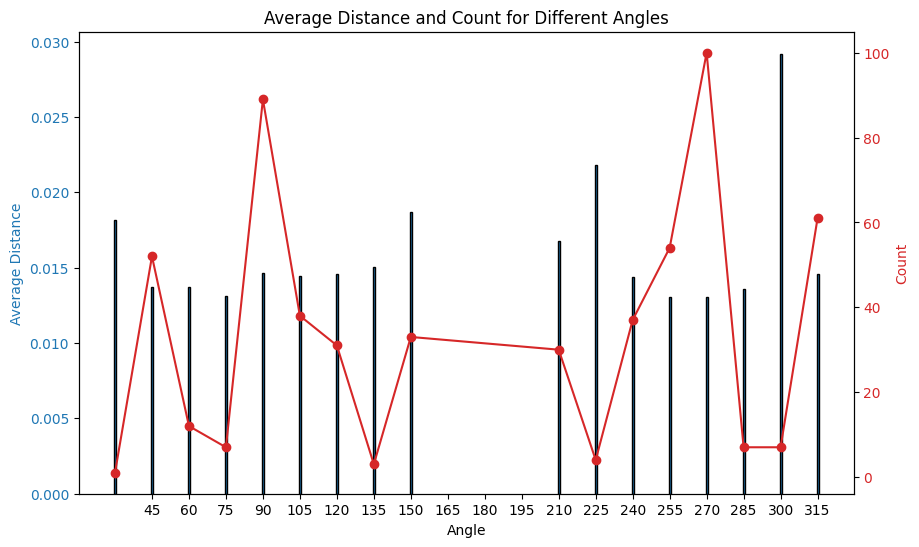

In [14]:
if 1:
    # Log model parameters if needed
    # Log the PyTorch model
    
    
    wandb.log({"test_avg_distance": dis})

    # Your plotting code
    summary_data = df.groupby('Angle')['Average Distance'].agg(['mean', 'count'])

    custom_ticks = list(range(45, 361, 15))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Angle')
    ax1.set_ylabel('Average Distance', color=color)
    ax1.bar(summary_data.index, summary_data['mean'], color=color, edgecolor='black')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(custom_ticks)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Count', color=color)
    ax2.plot(summary_data.index, summary_data['count'], color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Average Distance and Count for Different Angles')

    # Save the figure
    plt.savefig('plot.png')

    

    for angle, values in summary_data.iterrows():
        wandb.log({
            f"{angle}_avg_distance": values['mean']
        })

In [1]:
# DVC 
from dvclive import Live

In [7]:
train_no = 38
model_path = f'runs15Jan/train{train_no}/weights/best.pt'
import torch
device = torch.device('cpu')
model = YOLO(model_path)  # Or 'path/to/best.pt'
model.to(device)
dis = check_avg_dis(model)
# print(dis)
name = f"Train_No_{train_no}"



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230108161822.jpeg: 480x640 1 car, 127.1ms
Speed: 5.9ms preprocess, 127.1ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230108161822.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230822192008.jpeg: 480x640 1 car, 93.5ms
Speed: 4.6ms preprocess, 93.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230822192008.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221223114144.jpeg: 480x640 1 car, 116.2ms
Speed: 3.5ms preprocess, 116.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20221223114144.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230113131454.jpeg: 480x640 1 car, 108.9ms
Speed: 4.4ms preprocess, 108.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230113131454.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230424151412.jpg: 512x640 1 car, 117.8ms
Speed: 3.1ms preprocess, 117.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


left_side_view-20230424151412.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231202151813.jpeg: 480x640 1 car, 99.0ms
Speed: 3.3ms preprocess, 99.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20231202151813.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230524174344.jpeg: 384x640 1 car, 88.5ms
Speed: 3.0ms preprocess, 88.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230524174344.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230505154931.jpg: 480x640 1 car, 102.0ms
Speed: 3.8ms preprocess, 102.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230505154931.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230122230748.jpeg: 480x640 1 car, 92.4ms
Speed: 4.2ms preprocess, 92.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230122230748.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221210190446.jpeg: 480x640 1 car, 104.0ms
Speed: 2.9ms preprocess, 104.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20221210190446.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240103184831.jpg: 480x640 1 car, 123.6ms
Speed: 4.5ms preprocess, 123.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20240103184831.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230113131505.jpeg: 480x640 1 car, 93.6ms
Speed: 4.0ms preprocess, 93.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230113131505.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230113131528.jpeg: 480x640 1 car, 104.9ms
Speed: 4.7ms preprocess, 104.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230113131528.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230612171611.jpeg: 480x640 1 car, 96.6ms
Speed: 4.7ms preprocess, 96.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230612171611.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230424151425.jpg: 512x640 1 car, 110.0ms
Speed: 3.3ms preprocess, 110.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


front_right_view-20230424151425.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230819134348.jpg: 480x640 1 car, 102.7ms
Speed: 3.9ms preprocess, 102.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230819134348.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230612171512.jpeg: 480x640 1 car, 91.6ms
Speed: 4.3ms preprocess, 91.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230612171512.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230221182625.jpeg: 480x640 1 car, 103.6ms
Speed: 4.1ms preprocess, 103.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230221182625.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230822192036.jpeg: 480x640 1 car, 144.5ms
Speed: 19.8ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230822192036.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221223114154.jpeg: 480x640 1 car, 89.0ms
Speed: 3.3ms preprocess, 89.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20221223114154.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230819134335.jpg: 480x640 1 car, 100.4ms
Speed: 4.5ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230819134335.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221210190639.jpeg: 480x640 1 car, 93.5ms
Speed: 4.9ms preprocess, 93.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20221210190639.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230505154952.jpg: 480x640 1 car, 87.1ms
Speed: 3.2ms preprocess, 87.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230505154952.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230819134319.jpg: 480x640 1 car, 99.9ms
Speed: 3.9ms preprocess, 99.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230819134319.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240103184802.jpg: 480x640 1 car, 96.5ms
Speed: 10.8ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20240103184802.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230122230818.jpeg: 480x640 1 car, 94.3ms
Speed: 3.1ms preprocess, 94.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230122230818.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230302145907.jpg: 512x640 1 car, 161.4ms
Speed: 4.7ms preprocess, 161.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


left_side_view-20230302145907.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221210190629.jpeg: 480x640 1 car, 108.7ms
Speed: 4.1ms preprocess, 108.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20221210190629.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231202151725.jpeg: 480x640 1 car, 90.5ms
Speed: 2.9ms preprocess, 90.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20231202151725.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230927134157.jpeg: 640x480 1 car, 110.6ms
Speed: 3.9ms preprocess, 110.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


rear_left_view-20230927134157.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230108161943.jpeg: 480x640 1 car, 94.7ms
Speed: 3.1ms preprocess, 94.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230108161943.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230705185128.jpeg: 480x640 1 car, 94.0ms
Speed: 3.0ms preprocess, 94.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230705185128.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230822192017.jpeg: 480x640 1 car, 85.7ms
Speed: 7.0ms preprocess, 85.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230822192017.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230524174418.jpeg: 384x640 1 car, 79.9ms
Speed: 4.2ms preprocess, 79.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230524174418.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230307161432.jpg: 384x640 1 car, 134.8ms
Speed: 2.4ms preprocess, 134.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230307161432.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230302145940.jpg: 512x640 1 car, 112.1ms
Speed: 3.0ms preprocess, 112.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


rear_right_view-20230302145940.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230201172302.jpg: 480x640 1 car, 103.7ms
Speed: 3.9ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230201172302.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230302155603.jpeg: 384x640 1 car, 70.2ms
Speed: 3.4ms preprocess, 70.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230302155603.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230927134142.jpeg: 480x640 1 car, 103.4ms
Speed: 4.0ms preprocess, 103.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230927134142.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230612171440.jpeg: 480x640 1 car, 115.1ms
Speed: 7.6ms preprocess, 115.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230612171440.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221223114117.jpeg: 480x640 1 car, 99.1ms
Speed: 3.2ms preprocess, 99.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20221223114117.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231214125357.jpeg: 480x640 1 car, 106.8ms
Speed: 3.6ms preprocess, 106.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20231214125357.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230201172332.jpg: 480x640 1 car, 166.5ms
Speed: 3.4ms preprocess, 166.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230201172332.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230819134257.jpg: 480x640 1 car, 91.7ms
Speed: 4.5ms preprocess, 91.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230819134257.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231202151746.jpeg: 480x640 1 car, 83.4ms
Speed: 3.6ms preprocess, 83.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20231202151746.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230108161859.jpeg: 480x640 1 car, 90.0ms
Speed: 3.5ms preprocess, 90.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230108161859.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221210190611.jpeg: 480x640 1 car, 105.2ms
Speed: 4.6ms preprocess, 105.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20221210190611.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230108161928.jpeg: 480x640 1 car, 92.3ms
Speed: 3.1ms preprocess, 92.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230108161928.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221223114019.jpeg: 480x640 1 car, 92.1ms
Speed: 2.9ms preprocess, 92.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20221223114019.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230705185120.jpeg: 512x640 1 car, 94.1ms
Speed: 3.4ms preprocess, 94.1ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


rear_left_view-20230705185120.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230524174509.jpeg: 384x640 1 car, 100.0ms
Speed: 24.4ms preprocess, 100.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230524174509.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230221182537.jpeg: 480x640 1 car, 107.0ms
Speed: 2.8ms preprocess, 107.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230221182537.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230108161912.jpeg: 480x640 1 car, 94.2ms
Speed: 4.3ms preprocess, 94.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230108161912.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230307161424.jpg: 384x640 1 car, 82.6ms
Speed: 2.3ms preprocess, 82.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230307161424.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230302155640.jpeg: 384x640 1 car, 68.9ms
Speed: 3.2ms preprocess, 68.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230302155640.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230307161515.jpg: 384x640 1 car, 104.7ms
Speed: 2.2ms preprocess, 104.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230307161515.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230221182558.jpeg: 480x640 1 car, 107.9ms
Speed: 3.7ms preprocess, 107.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230221182558.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230705185101.jpeg: 480x640 1 car, 94.5ms
Speed: 3.1ms preprocess, 94.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230705185101.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221223114105.jpeg: 480x640 1 car, 117.4ms
Speed: 21.4ms preprocess, 117.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20221223114105.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230705185042.jpeg: 480x640 2 cars, 99.4ms
Speed: 3.8ms preprocess, 99.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230705185042.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230505154942.jpg: 480x640 1 car, 106.9ms
Speed: 2.9ms preprocess, 106.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230505154942.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230505154937.jpg: 480x640 1 car, 91.8ms
Speed: 5.9ms preprocess, 91.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230505154937.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231205165549.jpeg: 480x640 1 car, 97.8ms
Speed: 3.7ms preprocess, 97.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20231205165549.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230302145917.jpg: 512x640 1 car, 121.2ms
Speed: 4.2ms preprocess, 121.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


rear_left_view-20230302145917.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230424151441.jpg: 512x640 1 car, 114.4ms
Speed: 4.3ms preprocess, 114.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


rear_right_view-20230424151441.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221223114100.jpeg: 480x640 1 car, 82.6ms
Speed: 3.0ms preprocess, 82.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20221223114100.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231214125444.jpeg: 480x640 1 car, 102.1ms
Speed: 4.9ms preprocess, 102.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20231214125444.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230822191933.jpeg: 480x640 1 car, 95.8ms
Speed: 6.8ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230822191933.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231205165445.jpeg: 480x640 1 car, 96.4ms
Speed: 3.0ms preprocess, 96.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20231205165445.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230424151433.jpg: 512x640 1 car, 117.1ms
Speed: 3.5ms preprocess, 117.1ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)


rear_left_view-20230424151433.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240103184824.jpg: 480x640 1 car, 95.6ms
Speed: 4.3ms preprocess, 95.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20240103184824.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230302145952.jpg: 512x640 1 car, 123.4ms
Speed: 3.4ms preprocess, 123.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


right_side_view-20230302145952.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230705185113.jpeg: 480x640 1 car, 96.4ms
Speed: 3.8ms preprocess, 96.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230705185113.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230524174353.jpeg: 384x640 1 car, 65.2ms
Speed: 2.8ms preprocess, 65.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230524174353.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231214125428.jpeg: 480x640 1 car, 122.1ms
Speed: 4.5ms preprocess, 122.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20231214125428.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230524174505.jpeg: 384x640 1 car, 69.1ms
Speed: 4.4ms preprocess, 69.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230524174505.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230201172323.jpg: 480x640 1 car, 94.5ms
Speed: 3.2ms preprocess, 94.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230201172323.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230302145830.jpg: 512x640 1 car, 116.5ms
Speed: 4.1ms preprocess, 116.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


cover_image-20230302145830.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230201172315.jpg: 480x640 1 car, 90.0ms
Speed: 4.6ms preprocess, 90.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230201172315.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230302150003.jpg: 512x640 1 car, 116.7ms
Speed: 3.6ms preprocess, 116.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


front_right_view-20230302150003.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230822192049.jpeg: 480x640 1 car, 106.4ms
Speed: 2.8ms preprocess, 106.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230822192049.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231214125416.jpeg: 480x640 1 car, 102.4ms
Speed: 4.1ms preprocess, 102.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20231214125416.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20230612171643.jpeg: 480x640 1 car, 102.3ms
Speed: 4.7ms preprocess, 102.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


wheels_tyres-20230612171643.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231205165505.jpeg: 480x640 1 car, 85.5ms
Speed: 9.2ms preprocess, 85.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20231205165505.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231214125451.jpeg: 480x640 2 cars, 100.2ms
Speed: 3.6ms preprocess, 100.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20231214125451.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240103184924.jpg: 480x640 1 car, 101.6ms
Speed: 3.0ms preprocess, 101.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20240103184924.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231202151756.jpeg: 480x640 1 car, 89.0ms
Speed: 2.7ms preprocess, 89.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20231202151756.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240103184914.jpg: 480x640 1 car, 103.4ms
Speed: 3.1ms preprocess, 103.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20240103184914.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231214125438.jpeg: 480x640 1 car, 104.7ms
Speed: 5.0ms preprocess, 104.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20231214125438.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230122230433.jpeg: 480x640 1 car, 100.4ms
Speed: 3.0ms preprocess, 100.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230122230433.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230113131436.jpeg: 480x640 1 car, 137.9ms
Speed: 32.7ms preprocess, 137.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230113131436.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230612171549.jpeg: 480x640 1 car, 128.1ms
Speed: 3.9ms preprocess, 128.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230612171549.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240103184839.jpg: 480x640 1 car, 111.6ms
Speed: 4.2ms preprocess, 111.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20240103184839.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231205165530.jpeg: 480x640 1 car, 91.1ms
Speed: 3.9ms preprocess, 91.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20231205165530.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221210190605.jpeg: 480x640 1 car, 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20221210190605.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230612171532.jpeg: 480x640 1 car, 120.7ms
Speed: 5.0ms preprocess, 120.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230612171532.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230927134206.jpeg: 640x480 1 car, 93.5ms
Speed: 3.7ms preprocess, 93.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


front_right_view-20230927134206.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230612171623.jpeg: 480x640 1 car, 94.5ms
Speed: 2.7ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230612171623.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230505154915.jpg: 480x640 1 car, 126.3ms
Speed: 5.1ms preprocess, 126.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230505154915.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230822191952.jpeg: 480x640 1 car, 110.8ms
Speed: 3.0ms preprocess, 110.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230822191952.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230927134120.jpeg: 640x480 1 car, 97.5ms
Speed: 5.3ms preprocess, 97.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


cover_image-20230927134120.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230201172212.jpg: 480x640 1 car, 105.9ms
Speed: 3.7ms preprocess, 105.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230201172212.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230221182634.jpeg: 480x640 1 car, 109.2ms
Speed: 2.8ms preprocess, 109.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230221182634.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231205165516.jpeg: 480x640 1 car, 99.2ms
Speed: 3.1ms preprocess, 99.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20231205165516.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230705185137.jpeg: 512x640 1 car, 109.5ms
Speed: 3.5ms preprocess, 109.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


rear_right_view-20230705185137.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221210190621.jpeg: 480x640 1 car, 107.3ms
Speed: 2.9ms preprocess, 107.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20221210190621.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231205165540.jpeg: 480x640 1 car, 104.3ms
Speed: 35.0ms preprocess, 104.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20231205165540.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230221182606.jpeg: 480x640 1 car, 103.6ms
Speed: 3.3ms preprocess, 103.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230221182606.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230201172342.jpg: 480x640 1 car, 88.3ms
Speed: 3.3ms preprocess, 88.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230201172342.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230819134354.jpg: 480x640 1 car, 105.6ms
Speed: 3.8ms preprocess, 105.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


rear_right_view-20230819134354.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230122230340.jpeg: 480x640 1 car, 125.0ms
Speed: 3.7ms preprocess, 125.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


cover_image-20230122230340.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230424151418.jpg: 512x640 1 car, 115.6ms
Speed: 7.9ms preprocess, 115.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


right_side_view-20230424151418.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230221182616.jpeg: 480x640 1 car, 100.6ms
Speed: 4.9ms preprocess, 100.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230221182616.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231202151806.jpeg: 480x640 1 car, 79.9ms
Speed: 3.4ms preprocess, 79.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20231202151806.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230113131414.jpeg: 480x640 1 car, 115.3ms
Speed: 3.9ms preprocess, 115.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20230113131414.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230307161503.jpg: 384x640 1 car, 104.5ms
Speed: 12.1ms preprocess, 104.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230307161503.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230122230835.jpeg: 480x640 1 car, 85.1ms
Speed: 4.1ms preprocess, 85.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


front_right_view-20230122230835.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230424151340.jpg: 512x640 1 car, 113.5ms
Speed: 3.4ms preprocess, 113.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


cover_image-20230424151340.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230505154947.jpg: 480x640 1 car, 94.0ms
Speed: 4.2ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


rear_left_view-20230505154947.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231202151741.jpeg: 480x640 1 car, 120.2ms
Speed: 3.1ms preprocess, 120.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


left_side_view-20231202151741.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230927134215.jpeg: 640x480 1 car, 105.4ms
Speed: 4.0ms preprocess, 105.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


rear_right_view-20230927134215.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230927134146.jpeg: 480x640 1 car, 141.8ms
Speed: 33.3ms preprocess, 141.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


right_side_view-20230927134146.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477528098494460.jpg: 384x640 1 car, 91.5ms
Speed: 2.3ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


PART_1477528098494460.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477534685641985.jpg: 480x640 1 car, 111.5ms
Speed: 5.8ms preprocess, 111.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1477534685641985.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-3.jpg: 384x640 1 car, 98.3ms
Speed: 2.4ms preprocess, 98.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481212012786903.jpg: 448x640 1 car, 143.6ms
Speed: 2.7ms preprocess, 143.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


PART_1481212012786903.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-2.jpg: 384x640 1 car, 81.0ms
Speed: 23.5ms preprocess, 81.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in214320231205082545-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477281278514983.jpg: 480x640 1 car, 105.8ms
Speed: 3.4ms preprocess, 105.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1477281278514983.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in301020231219125953-2.jpg: 384x640 1 car, 85.7ms
Speed: 7.8ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in301020231219125953-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-2.jpg: 384x640 1 car, 181.9ms
Speed: 2.0ms preprocess, 181.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in502720231123120621-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481583051684227.jpg: 480x640 1 car, 106.9ms
Speed: 4.6ms preprocess, 106.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1481583051684227.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477441913947488.jpg: 480x640 1 car, 109.3ms
Speed: 8.5ms preprocess, 109.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1477441913947488.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-3.jpg: 384x640 1 car, 90.9ms
Speed: 2.9ms preprocess, 90.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


in826820231213123248-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478534944389907.jpg: 480x640 1 car, 113.0ms
Speed: 3.2ms preprocess, 113.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1478534944389907.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-2.jpg: 384x640 1 car, 93.3ms
Speed: 5.1ms preprocess, 93.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in873320231124095011-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016857709169136791652.jpg: 480x640 1 car, 112.2ms
Speed: 3.6ms preprocess, 112.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part160016857709169136791652.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477426201017406.jpg: 480x640 1 car, 154.2ms
Speed: 6.7ms preprocess, 154.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1477426201017406.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168907093361914891819.jpg: 480x640 1 car, 112.4ms
Speed: 3.5ms preprocess, 112.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


part1600168907093361914891819.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-9.jpg: 384x640 1 car, 96.4ms
Speed: 2.7ms preprocess, 96.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in243120231121121717-9.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016897900455272268222.jpg: 480x640 1 car, 112.4ms
Speed: 3.0ms preprocess, 112.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


part160016897900455272268222.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-7.jpg: 384x640 1 car, 107.0ms
Speed: 2.5ms preprocess, 107.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in975420231211105726-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-6.jpg: 384x640 1 car, 103.2ms
Speed: 1.9ms preprocess, 103.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in214320231205082545-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-4.jpg: 384x640 1 car, 93.2ms
Speed: 2.0ms preprocess, 93.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in745620231211145159-4.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481745169403126.jpg: 640x480 1 car, 107.0ms
Speed: 4.5ms preprocess, 107.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


PART_1481745169403126.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-1.jpg: 384x640 1 car, 131.3ms
Speed: 10.7ms preprocess, 131.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in214320231205082545-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481723760991902.jpg: 384x640 1 car, 96.5ms
Speed: 3.9ms preprocess, 96.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


PART_1481723760991902.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477934840240950.jpg: 480x640 1 car, 107.6ms
Speed: 2.7ms preprocess, 107.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1477934840240950.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479184799422426.jpg: 480x640 1 car, 101.4ms
Speed: 4.0ms preprocess, 101.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1479184799422426.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-1.jpg: 384x640 1 car, 89.5ms
Speed: 6.2ms preprocess, 89.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in265220231119103239-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-1.jpg: 384x640 1 car, 92.3ms
Speed: 3.0ms preprocess, 92.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


in799620231218081737-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-6.jpg: 384x640 1 car, 82.7ms
Speed: 2.8ms preprocess, 82.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-3.jpg: 384x640 1 car, 140.6ms
Speed: 2.1ms preprocess, 140.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in646920231218133357-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-7.jpg: 384x640 1 car, 82.2ms
Speed: 2.8ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in873320231124095011-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482487534261722.jpg: 480x640 1 car, 104.3ms
Speed: 4.2ms preprocess, 104.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1482487534261722.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482852216802389.jpg: 480x640 1 car, 103.9ms
Speed: 3.4ms preprocess, 103.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1482852216802389.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168252609604631156929.jpg: 480x640 1 car, 121.0ms
Speed: 2.7ms preprocess, 121.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


part1600168252609604631156929.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-2.jpg: 384x640 1 car, 90.9ms
Speed: 2.7ms preprocess, 90.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in292820231124100518-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-2.jpg: 384x640 1 car, 82.8ms
Speed: 2.8ms preprocess, 82.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in161920231119111435-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483803963334515.jpg: 384x640 1 car, 116.6ms
Speed: 3.1ms preprocess, 116.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


PART_1483803963334515.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-5.jpg: 384x640 1 car, 108.5ms
Speed: 2.7ms preprocess, 108.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168662435360421798415.jpg: 480x640 1 car, 99.8ms
Speed: 4.8ms preprocess, 99.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


part1600168662435360421798415.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482366796132742.jpg: 480x640 1 car, 104.0ms
Speed: 4.2ms preprocess, 104.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


PART_1482366796132742.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3558863405494105.jpg: 480x640 1 car, 113.3ms
Speed: 3.6ms preprocess, 113.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_3558863405494105.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-7.jpg: 384x640 1 car, 95.9ms
Speed: 3.4ms preprocess, 95.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in547220231123124841-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481545463689331.jpg: 480x640 1 car, 111.7ms
Speed: 4.4ms preprocess, 111.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1481545463689331.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168283154369834518600.jpg: 480x640 1 car, 114.9ms
Speed: 3.0ms preprocess, 114.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


part1600168283154369834518600.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-1.jpg: 384x640 1 car, 129.0ms
Speed: 2.2ms preprocess, 129.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477167228078692.jpg: 384x640 1 car, 86.1ms
Speed: 3.0ms preprocess, 86.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_1477167228078692.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-2.jpg: 384x640 1 car, 93.1ms
Speed: 6.3ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in547220231123124841-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479768679758253.jpg: 480x640 1 car, 110.4ms
Speed: 6.9ms preprocess, 110.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1479768679758253.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168923838974728586003.jpg: 480x640 1 car, 112.3ms
Speed: 5.3ms preprocess, 112.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part1600168923838974728586003.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482595858580953.jpg: 480x640 1 car, 101.3ms
Speed: 2.8ms preprocess, 101.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1482595858580953.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169062422420571213895.jpg: 480x640 1 car, 111.5ms
Speed: 3.5ms preprocess, 111.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part1600169062422420571213895.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-9.jpg: 384x640 1 car, 152.8ms
Speed: 3.4ms preprocess, 152.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in646920231218133357-9.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483788146793608.jpg: 480x640 1 car, 159.7ms
Speed: 2.7ms preprocess, 159.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1483788146793608.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-3.jpg: 384x640 1 car, 92.9ms
Speed: 2.9ms preprocess, 92.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


in975420231211105726-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479382118154593.jpg: 480x640 1 car, 111.1ms
Speed: 4.0ms preprocess, 111.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1479382118154593.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482640794032106.jpg: 480x640 1 car, 112.3ms
Speed: 4.3ms preprocess, 112.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1482640794032106.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016837502979981204271.jpg: 480x640 1 car, 106.7ms
Speed: 2.6ms preprocess, 106.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


part160016837502979981204271.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-2.jpg: 384x640 1 car, 93.8ms
Speed: 2.6ms preprocess, 93.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


in821820231219130304-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478464287971743.jpg: 480x640 1 car, 113.8ms
Speed: 3.2ms preprocess, 113.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1478464287971743.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-5.jpg: 384x640 1 car, 168.0ms
Speed: 3.6ms preprocess, 168.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in821820231219130304-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482847017922559.jpg: 480x640 1 car, 108.4ms
Speed: 2.5ms preprocess, 108.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


PART_1482847017922559.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-4.jpg: 384x640 1 car, 90.9ms
Speed: 4.3ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in646920231218133357-4.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480002566827727.jpg: 480x640 1 car, 113.5ms
Speed: 5.2ms preprocess, 113.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1480002566827727.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481908693906672.jpg: 480x640 1 car, 108.9ms
Speed: 5.0ms preprocess, 108.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1481908693906672.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-3.jpg: 384x640 1 car, 92.5ms
Speed: 3.1ms preprocess, 92.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in214320231205082545-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-5.jpg: 384x640 1 car, 91.4ms
Speed: 2.9ms preprocess, 91.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in745620231211145159-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-7.jpg: 384x640 2 cars, 181.2ms
Speed: 1.9ms preprocess, 181.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in292820231124100518-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478058867586331.jpg: 480x640 1 car, 115.3ms
Speed: 2.6ms preprocess, 115.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1478058867586331.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-6.jpg: 384x640 1 car, 85.5ms
Speed: 8.7ms preprocess, 85.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479466445456510.jpg: 480x640 1 car, 115.1ms
Speed: 4.4ms preprocess, 115.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1479466445456510.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-7.jpg: 384x640 1 car, 91.3ms
Speed: 12.8ms preprocess, 91.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3562436545529405.jpg: 480x640 1 car, 100.1ms
Speed: 3.0ms preprocess, 100.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_3562436545529405.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478189478050087.jpg: 480x640 1 car, 114.1ms
Speed: 3.1ms preprocess, 114.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1478189478050087.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478299856204165.jpg: 480x640 1 car, 196.5ms
Speed: 3.9ms preprocess, 196.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1478299856204165.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-2.jpg: 384x640 1 car, 94.4ms
Speed: 5.0ms preprocess, 94.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


in535020231211135109-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168588606433457854332.jpg: 480x640 1 car, 113.8ms
Speed: 3.6ms preprocess, 113.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


part1600168588606433457854332.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-1.jpg: 384x640 1 car, 87.2ms
Speed: 2.7ms preprocess, 87.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in502720231123120621-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-3.jpg: 384x640 1 car, 99.7ms
Speed: 2.3ms preprocess, 99.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in755420231116153659-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477405746854617.jpg: 480x640 1 car, 111.3ms
Speed: 3.3ms preprocess, 111.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1477405746854617.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168350220297825094927.jpg: 480x640 1 car, 108.3ms
Speed: 2.5ms preprocess, 108.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


part1600168350220297825094927.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-2.jpg: 384x640 1 car, 170.6ms
Speed: 3.0ms preprocess, 170.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in763620231121114511-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-7.jpg: 384x640 1 car, 104.9ms
Speed: 2.8ms preprocess, 104.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in957620231218121623-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-6.jpg: 384x640 1 car, 83.4ms
Speed: 2.5ms preprocess, 83.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in535020231211135109-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559764612050941.jpg: 480x640 1 car, 107.8ms
Speed: 3.7ms preprocess, 107.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


PART_3559764612050941.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480738532743538.jpg: 512x640 1 car, 119.8ms
Speed: 5.4ms preprocess, 119.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


PART_1480738532743538.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016877186097642093317.jpg: 480x640 1 car, 110.6ms
Speed: 3.4ms preprocess, 110.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


part160016877186097642093317.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168293598191588001496.jpg: 480x640 1 car, 110.4ms
Speed: 5.0ms preprocess, 110.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


part1600168293598191588001496.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480453911124456.jpg: 480x640 1 car, 180.1ms
Speed: 3.6ms preprocess, 180.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1480453911124456.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-6.jpg: 384x640 1 car, 96.6ms
Speed: 7.2ms preprocess, 96.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in265220231119103239-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-7.jpg: 384x640 1 car, 86.2ms
Speed: 2.0ms preprocess, 86.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in836320231214150909-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-6.jpg: 384x640 1 car, 93.6ms
Speed: 2.3ms preprocess, 93.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in161920231119111435-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-3.jpg: 384x640 1 car, 87.7ms
Speed: 3.4ms preprocess, 87.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


in502720231123120621-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part16001690477971644463261.jpg: 480x640 1 car, 99.0ms
Speed: 3.6ms preprocess, 99.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


part16001690477971644463261.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-7.jpg: 384x640 1 car, 95.0ms
Speed: 2.2ms preprocess, 95.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in265220231119103239-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4395181456302878.jpg: 480x640 1 car, 148.9ms
Speed: 50.7ms preprocess, 148.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_4395181456302878.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478870985931474.jpg: 480x640 1 car, 107.6ms
Speed: 2.8ms preprocess, 107.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


PART_1478870985931474.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-6.jpg: 384x640 2 cars, 95.1ms
Speed: 2.5ms preprocess, 95.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in957620231218121623-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-5.jpg: 384x640 1 car, 91.2ms
Speed: 2.6ms preprocess, 91.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


in763620231121114511-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1484079026295772.jpg: 480x640 1 car, 127.7ms
Speed: 3.8ms preprocess, 127.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


PART_1484079026295772.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168224745465570190870.jpg: 640x480 1 car, 115.8ms
Speed: 2.7ms preprocess, 115.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


part1600168224745465570190870.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478441604224371.jpg: 384x640 1 car, 98.2ms
Speed: 2.6ms preprocess, 98.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


PART_1478441604224371.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-2.jpg: 384x640 1 car, 158.0ms
Speed: 3.7ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-2.jpg: 384x640 1 car, 85.5ms
Speed: 1.8ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in799620231218081737-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477785823946919.jpg: 480x640 1 car, 101.2ms
Speed: 4.8ms preprocess, 101.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


PART_1477785823946919.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481910397927490.jpg: 480x640 1 car, 100.8ms
Speed: 3.6ms preprocess, 100.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


PART_1481910397927490.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-7.jpg: 384x640 1 car, 88.3ms
Speed: 2.1ms preprocess, 88.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


in646920231218133357-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479255219713006.jpg: 480x640 1 car, 107.7ms
Speed: 5.9ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1479255219713006.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-7.jpg: 384x640 1 car, 92.2ms
Speed: 2.0ms preprocess, 92.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in821820231219130304-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4495593076167055.jpg: 480x640 1 car, 153.2ms
Speed: 17.4ms preprocess, 153.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_4495593076167055.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-3.jpg: 384x640 1 car, 105.4ms
Speed: 6.4ms preprocess, 105.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479952879597662.jpg: 480x640 1 car, 102.6ms
Speed: 4.4ms preprocess, 102.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1479952879597662.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in547220231123124841-5.jpg: 384x640 1 car, 96.2ms
Speed: 3.7ms preprocess, 96.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in547220231123124841-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-2.jpg: 384x640 1 car, 94.4ms
Speed: 6.3ms preprocess, 94.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


in928020231220093827-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168487347574271567380.jpg: 480x640 1 car, 111.9ms
Speed: 3.2ms preprocess, 111.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


part1600168487347574271567380.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560588209651776.jpg: 352x640 1 car, 153.3ms
Speed: 2.9ms preprocess, 153.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


PART_3560588209651776.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478411529869910.jpg: 480x640 1 car, 132.9ms
Speed: 3.9ms preprocess, 132.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1478411529869910.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-2.jpg: 384x640 1 car, 112.7ms
Speed: 3.8ms preprocess, 112.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in957620231218121623-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-5.jpg: 384x640 1 car, 105.7ms
Speed: 2.6ms preprocess, 105.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in836320231214150909-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-2.jpg: 384x640 1 car, 88.4ms
Speed: 4.9ms preprocess, 88.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in755420231116153659-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-1.jpg: 384x640 1 car, 90.2ms
Speed: 2.8ms preprocess, 90.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in292820231124100518-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168263144558438189588.jpg: 480x640 1 car, 119.7ms
Speed: 3.8ms preprocess, 119.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


part1600168263144558438189588.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479354265937997.jpg: 480x640 1 car, 107.8ms
Speed: 4.7ms preprocess, 107.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1479354265937997.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482606483220424.jpg: 384x640 1 car, 198.0ms
Speed: 4.0ms preprocess, 198.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


PART_1482606483220424.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483210320995706.jpg: 512x640 1 car, 111.4ms
Speed: 4.9ms preprocess, 111.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


PART_1483210320995706.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-5.jpg: 384x640 1 car, 88.7ms
Speed: 9.1ms preprocess, 88.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in799620231218081737-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483841811166102.jpg: 320x640 1 car, 106.1ms
Speed: 1.6ms preprocess, 106.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


PART_1483841811166102.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559628291981744.jpg: 480x640 1 car, 111.5ms
Speed: 3.2ms preprocess, 111.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_3559628291981744.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483616823760075.jpg: 384x640 1 car, 99.5ms
Speed: 2.7ms preprocess, 99.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


PART_1483616823760075.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560577313968785.jpg: 480x640 1 car, 97.5ms
Speed: 4.0ms preprocess, 97.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_3560577313968785.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4408179695317297.jpg: 480x640 1 car, 91.5ms
Speed: 2.8ms preprocess, 91.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_4408179695317297.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4394079952521361.jpg: 384x640 1 car, 134.6ms
Speed: 2.2ms preprocess, 134.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


PART_4394079952521361.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-7.jpg: 384x640 1 car, 72.3ms
Speed: 2.0ms preprocess, 72.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in502720231123120621-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168470297537621523720.jpg: 480x640 1 car, 74.4ms
Speed: 4.3ms preprocess, 74.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part1600168470297537621523720.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-3.jpg: 384x640 2 cars, 75.8ms
Speed: 2.0ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in873320231124095011-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479475397923700.jpg: 480x640 1 car, 85.7ms
Speed: 5.5ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1479475397923700.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-7.jpg: 384x640 1 car, 75.8ms
Speed: 2.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in214320231205082545-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-6.jpg: 384x640 1 car, 64.4ms
Speed: 2.4ms preprocess, 64.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in975420231211105726-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-5.jpg: 384x640 1 car, 107.9ms
Speed: 2.5ms preprocess, 107.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


in646920231218133357-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-1.jpg: 384x640 1 car, 69.9ms
Speed: 2.0ms preprocess, 69.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in836320231214150909-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168340251687826694940.jpg: 480x640 1 car, 80.0ms
Speed: 3.0ms preprocess, 80.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


part1600168340251687826694940.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-5.jpg: 384x640 1 car, 68.6ms
Speed: 2.3ms preprocess, 68.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in502720231123120621-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483248120468209.jpg: 480x640 1 car, 89.6ms
Speed: 2.8ms preprocess, 89.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1483248120468209.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478558445769340.jpg: 480x640 1 car, 88.9ms
Speed: 2.8ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1478558445769340.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482225318351645.jpg: 320x640 1 car, 54.7ms
Speed: 1.7ms preprocess, 54.7ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 640)


PART_1482225318351645.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-3.jpg: 384x640 1 car, 112.1ms
Speed: 2.9ms preprocess, 112.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in799620231218081737-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483496885531519.jpg: 480x640 1 car, 92.4ms
Speed: 4.0ms preprocess, 92.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1483496885531519.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3561229220430928.jpg: 384x640 1 car, 73.6ms
Speed: 2.4ms preprocess, 73.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_3561229220430928.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168535186414285141985.jpg: 480x640 1 car, 85.6ms
Speed: 3.6ms preprocess, 85.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


part1600168535186414285141985.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016883371158994760719.jpg: 384x640 1 car, 76.4ms
Speed: 2.5ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


part160016883371158994760719.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478134314872619.jpg: 480x640 1 car, 94.7ms
Speed: 3.0ms preprocess, 94.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1478134314872619.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3496373593011785.jpg: 320x640 1 car, 64.5ms
Speed: 2.2ms preprocess, 64.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


PART_3496373593011785.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477414637212916.jpg: 480x640 1 car, 110.9ms
Speed: 3.2ms preprocess, 110.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1477414637212916.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168313507412441456967.jpg: 480x640 1 car, 89.3ms
Speed: 3.0ms preprocess, 89.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part1600168313507412441456967.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481117392640398.jpg: 480x640 1 car, 93.9ms
Speed: 2.6ms preprocess, 93.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1481117392640398.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480147557590644.jpg: 384x640 1 car, 64.1ms
Speed: 3.6ms preprocess, 64.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_1480147557590644.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4411723625968720.jpg: 480x640 1 car, 88.1ms
Speed: 2.8ms preprocess, 88.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_4411723625968720.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479099483545485.jpg: 480x640 1 car, 87.2ms
Speed: 3.4ms preprocess, 87.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1479099483545485.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483923120256926.jpg: 512x640 1 car, 90.6ms
Speed: 2.9ms preprocess, 90.6ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)


PART_1483923120256926.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in161920231119111435-7.jpg: 384x640 1 car, 76.7ms
Speed: 2.8ms preprocess, 76.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in161920231119111435-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016863579581974467775.jpg: 480x640 1 car, 136.2ms
Speed: 9.1ms preprocess, 136.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part160016863579581974467775.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480786645946999.jpg: 384x640 1 car, 76.4ms
Speed: 3.5ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_1480786645946999.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1484033936623199.jpg: 480x640 1 car, 87.5ms
Speed: 3.2ms preprocess, 87.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1484033936623199.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478701545065743.jpg: 480x640 1 car, 83.0ms
Speed: 6.0ms preprocess, 83.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1478701545065743.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4396074210422407.jpg: 320x640 1 car, 54.2ms
Speed: 2.2ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


PART_4396074210422407.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-3.jpg: 384x640 1 car, 67.1ms
Speed: 1.7ms preprocess, 67.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in292820231124100518-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-7.jpg: 384x640 1 car, 76.8ms
Speed: 1.6ms preprocess, 76.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


in799620231218081737-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-3.jpg: 384x640 1 car, 91.8ms
Speed: 2.0ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in957620231218121623-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481724691739913.jpg: 480x640 1 car, 84.5ms
Speed: 2.8ms preprocess, 84.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1481724691739913.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478705006293172.jpg: 448x640 1 car, 83.4ms
Speed: 2.6ms preprocess, 83.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


PART_1478705006293172.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478630273066489.jpg: 480x640 1 car, 87.9ms
Speed: 2.9ms preprocess, 87.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1478630273066489.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481478716227158.jpg: 480x640 1 car, 89.8ms
Speed: 2.3ms preprocess, 89.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1481478716227158.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-2.jpg: 384x640 1 car, 72.7ms
Speed: 3.1ms preprocess, 72.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


in836320231214150909-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3559026759844316.jpg: 480x640 1 car, 94.9ms
Speed: 3.0ms preprocess, 94.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_3559026759844316.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in799620231218081737-6.jpg: 384x640 1 car, 131.4ms
Speed: 2.5ms preprocess, 131.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in799620231218081737-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-3.jpg: 384x640 1 car, 77.4ms
Speed: 2.4ms preprocess, 77.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in821820231219130304-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in873320231124095011-6.jpg: 384x640 1 car, 76.0ms
Speed: 2.0ms preprocess, 76.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in873320231124095011-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482832106532585.jpg: 480x640 1 car, 94.2ms
Speed: 2.5ms preprocess, 94.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


PART_1482832106532585.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-7.jpg: 384x640 1 car, 70.0ms
Speed: 1.7ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in745620231211145159-7.jpg: 384x640 1 car, 75.7ms
Speed: 2.3ms preprocess, 75.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in745620231211145159-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477607400418254.jpg: 448x640 1 car, 85.2ms
Speed: 3.3ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


PART_1477607400418254.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4397024580852166.jpg: 480x640 1 car, 109.6ms
Speed: 3.1ms preprocess, 109.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_4397024580852166.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3558690236844843.jpg: 384x640 1 car, 82.0ms
Speed: 2.1ms preprocess, 82.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


PART_3558690236844843.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in502720231123120621-6.jpg: 384x640 1 car, 73.6ms
Speed: 1.6ms preprocess, 73.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in502720231123120621-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479759940598498.jpg: 480x640 1 car, 91.5ms
Speed: 2.6ms preprocess, 91.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1479759940598498.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in975420231211105726-2.jpg: 384x640 1 car, 77.1ms
Speed: 2.4ms preprocess, 77.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in975420231211105726-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-3.jpg: 384x640 1 car, 73.5ms
Speed: 3.2ms preprocess, 73.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in763620231121114511-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in957620231218121623-8.jpg: 384x640 1 car, 75.4ms
Speed: 2.4ms preprocess, 75.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in957620231218121623-8.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in646920231218133357-8.jpg: 384x640 1 car, 100.9ms
Speed: 2.5ms preprocess, 100.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in646920231218133357-8.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-6.jpg: 384x640 1 car, 74.7ms
Speed: 2.7ms preprocess, 74.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in928020231220093827-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-1.jpg: 384x640 1 car, 76.9ms
Speed: 2.6ms preprocess, 76.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in821820231219130304-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168555366341865634231.jpg: 320x640 1 car, 64.1ms
Speed: 2.0ms preprocess, 64.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


part1600168555366341865634231.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479562395975901.jpg: 480x640 1 car, 90.9ms
Speed: 2.8ms preprocess, 90.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


PART_1479562395975901.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-6.jpg: 384x640 1 car, 73.6ms
Speed: 2.6ms preprocess, 73.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in779120231119152124-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168503074404727423169.jpg: 480x640 1 car, 87.3ms
Speed: 2.6ms preprocess, 87.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


part1600168503074404727423169.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-5.jpg: 384x640 1 car, 135.4ms
Speed: 2.7ms preprocess, 135.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in755420231116153659-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481672883470520.jpg: 480x640 1 car, 88.9ms
Speed: 2.5ms preprocess, 88.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1481672883470520.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478486328015152.jpg: 480x640 1 car, 78.9ms
Speed: 3.4ms preprocess, 78.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1478486328015152.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-7.jpg: 384x640 1 car, 72.3ms
Speed: 2.7ms preprocess, 72.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in779120231119152124-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in928020231220093827-1.jpg: 384x640 1 car, 78.4ms
Speed: 2.4ms preprocess, 78.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in928020231220093827-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-6.jpg: 384x640 1 car, 75.2ms
Speed: 2.4ms preprocess, 75.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


in292820231124100518-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in642120231213085757-1.jpg: 384x640 1 car, 73.4ms
Speed: 1.8ms preprocess, 73.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in642120231213085757-1.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-3.jpg: 384x640 1 car, 91.7ms
Speed: 2.6ms preprocess, 91.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in265220231119103239-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016850320663952748547.jpg: 480x640 1 car, 81.9ms
Speed: 2.5ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


part160016850320663952748547.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-2.jpg: 384x640 1 car, 75.9ms
Speed: 2.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in826820231213123248-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-7.jpg: 384x640 1 car, 70.1ms
Speed: 2.0ms preprocess, 70.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in755420231116153659-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483040902570112.jpg: 512x640 1 car, 97.4ms
Speed: 3.2ms preprocess, 97.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


PART_1483040902570112.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168748451614186364646.jpg: 480x640 1 car, 94.6ms
Speed: 2.8ms preprocess, 94.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


part1600168748451614186364646.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_4409875392172994.jpg: 480x640 1 car, 110.3ms
Speed: 2.7ms preprocess, 110.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


PART_4409875392172994.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481902021627340.jpg: 480x640 1 car, 91.2ms
Speed: 3.0ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1481902021627340.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3564205062841876.jpg: 480x640 1 car, 89.3ms
Speed: 4.1ms preprocess, 89.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_3564205062841876.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480211880582672.jpg: 480x640 1 car, 83.3ms
Speed: 2.6ms preprocess, 83.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1480211880582672.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-8.jpg: 384x640 1 car, 71.4ms
Speed: 2.0ms preprocess, 71.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in243120231121121717-8.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in292820231124100518-5.jpg: 384x640 1 car, 75.7ms
Speed: 2.2ms preprocess, 75.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in292820231124100518-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-6.jpg: 384x640 1 car, 72.2ms
Speed: 1.7ms preprocess, 72.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in826820231213123248-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part160016854286321624513875.jpg: 480x640 1 car, 79.7ms
Speed: 3.1ms preprocess, 79.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


part160016854286321624513875.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479059081086908.jpg: 480x640 1 car, 87.1ms
Speed: 35.6ms preprocess, 87.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1479059081086908.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168366004084637756878.jpg: 480x640 1 car, 70.5ms
Speed: 3.2ms preprocess, 70.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


part1600168366004084637756878.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in755420231116153659-6.jpg: 384x640 1 car, 71.9ms
Speed: 2.1ms preprocess, 71.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in755420231116153659-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in821820231219130304-6.jpg: 384x640 1 car, 71.0ms
Speed: 1.6ms preprocess, 71.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in821820231219130304-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481593495821827.jpg: 480x640 1 car, 83.5ms
Speed: 3.7ms preprocess, 83.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1481593495821827.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-5.jpg: 384x640 1 car, 75.2ms
Speed: 1.7ms preprocess, 75.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478329502958288.jpg: 480x640 1 car, 130.1ms
Speed: 3.4ms preprocess, 130.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


PART_1478329502958288.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_3560027113760653.jpg: 480x640 1 car, 81.6ms
Speed: 2.9ms preprocess, 81.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_3560027113760653.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-7.jpg: 384x640 1 car, 68.4ms
Speed: 1.8ms preprocess, 68.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


in763620231121114511-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in826820231213123248-5.jpg: 384x640 1 car, 60.9ms
Speed: 2.4ms preprocess, 60.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in826820231213123248-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1480293754514517.jpg: 480x640 1 car, 82.5ms
Speed: 2.9ms preprocess, 82.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1480293754514517.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-6.jpg: 384x640 1 car, 83.4ms
Speed: 1.9ms preprocess, 83.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in836320231214150909-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481446473131123.jpg: 480x640 1 car, 115.9ms
Speed: 3.6ms preprocess, 115.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1481446473131123.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in265220231119103239-2.jpg: 384x640 1 car, 62.2ms
Speed: 2.0ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


in265220231119103239-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1478141726362045.jpg: 480x640 1 car, 85.4ms
Speed: 2.7ms preprocess, 85.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1478141726362045.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in763620231121114511-6.jpg: 384x640 1 car, 64.7ms
Speed: 2.4ms preprocess, 64.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


in763620231121114511-6.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-7.jpg: 384x640 1 car, 68.8ms
Speed: 1.9ms preprocess, 68.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in535020231211135109-7.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in411620231220133737-4.jpg: 384x640 1 car, 69.4ms
Speed: 2.0ms preprocess, 69.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in411620231220133737-4.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600168372784216486895332.jpg: 448x640 1 car, 138.5ms
Speed: 2.4ms preprocess, 138.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


part1600168372784216486895332.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in535020231211135109-3.jpg: 384x640 1 car, 63.9ms
Speed: 2.0ms preprocess, 63.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in535020231211135109-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477472546470809.jpg: 480x640 1 car, 78.2ms
Speed: 2.6ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


PART_1477472546470809.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in243120231121121717-4.jpg: 384x640 1 car, 59.8ms
Speed: 1.8ms preprocess, 59.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in243120231121121717-4.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483643331452636.jpg: 384x640 1 car, 71.5ms
Speed: 2.0ms preprocess, 71.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


PART_1483643331452636.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1479515160134545.jpg: 480x640 1 car, 87.0ms
Speed: 2.6ms preprocess, 87.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


PART_1479515160134545.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1482641886229208.jpg: 480x640 1 car, 97.9ms
Speed: 3.0ms preprocess, 97.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1482641886229208.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in779120231119152124-2.jpg: 384x640 2 cars, 74.3ms
Speed: 2.1ms preprocess, 74.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


in779120231119152124-2.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1477786870210365.jpg: 480x640 1 car, 83.8ms
Speed: 2.6ms preprocess, 83.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


PART_1477786870210365.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in214320231205082545-5.jpg: 384x640 1 car, 66.4ms
Speed: 1.8ms preprocess, 66.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


in214320231205082545-5.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1481664768556479.jpg: 448x640 1 car, 76.4ms
Speed: 4.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


PART_1481664768556479.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483441612726530.jpg: 320x640 1 car, 57.3ms
Speed: 2.2ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


PART_1483441612726530.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/in836320231214150909-3.jpg: 384x640 1 car, 71.0ms
Speed: 3.2ms preprocess, 71.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


in836320231214150909-3.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169077456680518725884.jpg: 480x640 1 car, 96.9ms
Speed: 2.9ms preprocess, 96.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


part1600169077456680518725884.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/PART_1483108249233619.jpg: 512x640 1 car, 93.8ms
Speed: 2.8ms preprocess, 93.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


PART_1483108249233619.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169090973281685103148.jpg: 480x640 1 car, 85.6ms
Speed: 3.4ms preprocess, 85.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


part1600169090973281685103148.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/part1600169008038940490818014.jpg: 480x640 1 car, 80.1ms
Speed: 4.3ms preprocess, 80.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


part1600169008038940490818014.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230803123236.jpeg: 384x640 1 car, 69.7ms
Speed: 2.6ms preprocess, 69.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230803123236.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231008101255.jpg: 384x640 1 car, 67.9ms
Speed: 1.7ms preprocess, 67.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231008101255.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230808130147.jpeg: 384x640 1 car, 68.6ms
Speed: 1.7ms preprocess, 68.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230808130147.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230922181923.jpeg: 384x640 1 car, 77.3ms
Speed: 21.9ms preprocess, 77.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230922181923.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231129110435.jpg: 384x640 1 car, 70.5ms
Speed: 2.0ms preprocess, 70.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231129110435.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230811143949.jpeg: 384x640 1 car, 69.2ms
Speed: 1.9ms preprocess, 69.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230811143949.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231010184313.jpg: 384x640 1 car, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231010184313.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231214103426.jpg: 384x640 1 car, 69.1ms
Speed: 1.6ms preprocess, 69.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231214103426.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230808130415.jpeg: 384x640 1 car, 60.6ms
Speed: 2.0ms preprocess, 60.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230808130415.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230611142129.jpg: 384x640 1 car, 72.9ms
Speed: 1.9ms preprocess, 72.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230611142129.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230910101658.jpg: 384x640 1 car, 88.8ms
Speed: 2.1ms preprocess, 88.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230910101658.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231006135947.jpeg: 384x640 1 car, 62.2ms
Speed: 2.0ms preprocess, 62.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231006135947.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231016185751.jpg: 384x640 1 car, 61.5ms
Speed: 2.5ms preprocess, 61.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231016185751.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240103130714.jpg: 384x640 1 car, 62.5ms
Speed: 1.8ms preprocess, 62.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20240103130714.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230929231239.jpg: 384x640 1 car, 65.4ms
Speed: 2.0ms preprocess, 65.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230929231239.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230522160751.jpg: 384x640 1 car, 70.1ms
Speed: 1.9ms preprocess, 70.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230522160751.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231010184240.jpg: 384x640 1 car, 84.1ms
Speed: 1.9ms preprocess, 84.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231010184240.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231005124746.jpeg: 384x640 1 car, 72.9ms
Speed: 3.2ms preprocess, 72.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231005124746.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230331174028.jpg: 384x640 1 car, 71.4ms
Speed: 1.8ms preprocess, 71.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230331174028.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231121170009.jpg: 384x640 1 car, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231121170009.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230611142059.jpg: 384x640 1 car, 75.5ms
Speed: 1.8ms preprocess, 75.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230611142059.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231129104249.jpg: 384x640 1 car, 67.5ms
Speed: 1.8ms preprocess, 67.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231129104249.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230519173548.jpeg: 384x640 1 car, 71.5ms
Speed: 1.9ms preprocess, 71.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230519173548.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230215190012.jpeg: 384x640 1 car, 72.9ms
Speed: 2.0ms preprocess, 72.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230215190012.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221104130948.jpeg: 384x640 1 car, 74.9ms
Speed: 2.4ms preprocess, 74.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20221104130948.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231219133353.jpeg: 384x640 1 car, 69.3ms
Speed: 2.1ms preprocess, 69.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231219133353.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231229091312.jpg: 384x640 1 car, 73.6ms
Speed: 1.9ms preprocess, 73.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231229091312.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231129110404.jpg: 384x640 1 car, 67.3ms
Speed: 1.6ms preprocess, 67.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231129110404.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230526143323.jpeg: 384x640 1 car, 67.6ms
Speed: 1.6ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230526143323.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240109213150.jpg: 384x640 1 car, 78.5ms
Speed: 2.6ms preprocess, 78.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20240109213150.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231229091423.jpg: 384x640 1 car, 109.9ms
Speed: 1.7ms preprocess, 109.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231229091423.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230623143227.jpg: 384x640 1 car, 71.0ms
Speed: 2.8ms preprocess, 71.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230623143227.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230903153432.jpg: 384x640 1 car, 73.9ms
Speed: 1.8ms preprocess, 73.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230903153432.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230922182127.jpeg: 384x640 1 car, 68.9ms
Speed: 2.0ms preprocess, 68.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230922182127.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231016185803.jpg: 384x640 1 car, 80.8ms
Speed: 1.7ms preprocess, 80.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231016185803.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231008101347.jpg: 384x640 1 car, 72.5ms
Speed: 2.0ms preprocess, 72.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231008101347.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230929231204.jpg: 384x640 1 car, 83.2ms
Speed: 2.1ms preprocess, 83.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230929231204.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221221130716.jpg: 384x640 1 car, 69.6ms
Speed: 2.4ms preprocess, 69.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20221221130716.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230307161432.jpg: 384x640 1 car, 65.1ms
Speed: 1.8ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230307161432.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230611142123.jpg: 384x640 1 car, 75.8ms
Speed: 2.3ms preprocess, 75.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230611142123.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230111141846.jpeg: 384x640 1 car, 68.1ms
Speed: 1.7ms preprocess, 68.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230111141846.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230215190023.jpeg: 384x640 1 car, 68.9ms
Speed: 1.7ms preprocess, 68.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230215190023.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240111121000.jpg: 384x640 1 car, 67.6ms
Speed: 2.7ms preprocess, 67.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20240111121000.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231129104342.jpg: 384x640 1 car, 83.1ms
Speed: 2.1ms preprocess, 83.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231129104342.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230331173829.jpg: 384x640 1 car, 78.9ms
Speed: 1.7ms preprocess, 78.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230331173829.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20230808130429.jpeg: 384x640 1 car, 69.6ms
Speed: 1.7ms preprocess, 69.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


wheels_tyres-20230808130429.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230808130406.jpeg: 384x640 1 car, 67.3ms
Speed: 1.6ms preprocess, 67.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230808130406.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240109213019.jpg: 384x640 1 car, 60.4ms
Speed: 1.6ms preprocess, 60.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20240109213019.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230623143216.jpg: 384x640 1 car, 67.4ms
Speed: 1.6ms preprocess, 67.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230623143216.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240103130638.jpg: 384x640 1 car, 132.0ms
Speed: 2.5ms preprocess, 132.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20240103130638.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230111141859.jpeg: 384x640 1 car, 68.0ms
Speed: 2.2ms preprocess, 68.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230111141859.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231129104301.jpg: 384x640 1 car, 56.8ms
Speed: 1.8ms preprocess, 56.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231129104301.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240103130705.jpg: 384x640 1 car, 70.0ms
Speed: 2.9ms preprocess, 70.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20240103130705.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231010184204.jpg: 384x640 1 car, 69.6ms
Speed: 1.7ms preprocess, 69.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231010184204.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20220502122645.jpg: 384x640 1 car, 71.6ms
Speed: 1.9ms preprocess, 71.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20220502122645.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231129110445.jpg: 384x640 1 car, 135.5ms
Speed: 1.9ms preprocess, 135.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231129110445.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231129104327.jpg: 384x640 1 car, 73.4ms
Speed: 1.8ms preprocess, 73.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231129104327.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230331173917.jpg: 384x640 1 car, 73.3ms
Speed: 2.0ms preprocess, 73.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230331173917.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231008101403.jpg: 384x640 1 car, 70.1ms
Speed: 1.8ms preprocess, 70.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231008101403.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230811143930.jpeg: 384x640 1 car, 78.1ms
Speed: 1.9ms preprocess, 78.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230811143930.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230522160726.jpg: 384x640 1 car, 72.8ms
Speed: 2.3ms preprocess, 72.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230522160726.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221224131311.jpeg: 384x640 1 car, 74.3ms
Speed: 1.8ms preprocess, 74.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20221224131311.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230519173630.jpeg: 384x640 1 car, 64.8ms
Speed: 2.1ms preprocess, 64.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230519173630.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230922182114.jpeg: 384x640 1 car, 64.3ms
Speed: 1.7ms preprocess, 64.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230922182114.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230522160746.jpg: 384x640 1 car, 73.2ms
Speed: 1.8ms preprocess, 73.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230522160746.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230531180130.jpg: 384x640 1 car, 61.1ms
Speed: 2.3ms preprocess, 61.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230531180130.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230803123121.jpeg: 384x640 1 car, 73.0ms
Speed: 1.8ms preprocess, 73.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230803123121.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230331155119.jpeg: 384x640 2 cars, 70.3ms
Speed: 2.1ms preprocess, 70.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230331155119.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20210922134927.jpg: 384x640 1 car, 69.5ms
Speed: 2.4ms preprocess, 69.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20210922134927.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231008101326.jpg: 384x640 1 car, 107.0ms
Speed: 6.5ms preprocess, 107.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231008101326.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231229091358.jpg: 384x640 1 car, 62.8ms
Speed: 1.7ms preprocess, 62.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231229091358.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230531180105.jpg: 384x640 1 car, 65.6ms
Speed: 1.8ms preprocess, 65.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230531180105.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230307161424.jpg: 384x640 1 car, 68.4ms
Speed: 1.6ms preprocess, 68.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230307161424.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231219133604.jpeg: 384x640 1 car, 69.6ms
Speed: 2.1ms preprocess, 69.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231219133604.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230331155111.jpeg: 384x640 1 car, 75.3ms
Speed: 1.8ms preprocess, 75.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230331155111.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230522160738.jpg: 384x640 1 car, 80.3ms
Speed: 1.7ms preprocess, 80.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230522160738.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231129104316.jpg: 384x640 1 car, 63.1ms
Speed: 3.8ms preprocess, 63.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231129104316.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231214103357.jpg: 384x640 1 car, 59.4ms
Speed: 2.0ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231214103357.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230307161515.jpg: 384x640 1 car, 72.9ms
Speed: 2.2ms preprocess, 72.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230307161515.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231121170053.jpg: 384x640 1 car, 71.3ms
Speed: 1.7ms preprocess, 71.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231121170053.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230803123208.jpeg: 384x640 1 car, 69.8ms
Speed: 1.9ms preprocess, 69.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230803123208.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20220502122742.jpg: 384x640 1 car, 90.1ms
Speed: 1.9ms preprocess, 90.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20220502122742.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240103130659.jpg: 384x640 1 car, 74.2ms
Speed: 1.9ms preprocess, 74.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20240103130659.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221104130944.jpeg: 384x640 1 car, 68.8ms
Speed: 2.4ms preprocess, 68.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20221104130944.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231219133614.jpeg: 384x640 1 car, 76.0ms
Speed: 1.8ms preprocess, 76.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231219133614.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240103130737.jpg: 384x640 1 car, 69.2ms
Speed: 1.9ms preprocess, 69.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20240103130737.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230215185956.jpeg: 384x640 1 car, 87.8ms
Speed: 2.8ms preprocess, 87.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230215185956.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221104130902.jpeg: 384x640 1 car, 71.0ms
Speed: 2.1ms preprocess, 71.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20221104130902.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221221130641.jpg: 384x640 1 car, 68.7ms
Speed: 1.7ms preprocess, 68.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20221221130641.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231214103315.jpg: 384x640 1 car, 72.7ms
Speed: 1.7ms preprocess, 72.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231214103315.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230526143234.jpeg: 384x640 1 car, 68.7ms
Speed: 1.9ms preprocess, 68.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230526143234.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230803123157.jpeg: 384x640 1 car, 61.9ms
Speed: 1.7ms preprocess, 61.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230803123157.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230910101650.jpg: 384x640 1 car, 122.4ms
Speed: 1.8ms preprocess, 122.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230910101650.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230611142105.jpg: 384x640 1 car, 66.1ms
Speed: 1.9ms preprocess, 66.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230611142105.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/wheels_tyres-20231219133652.jpeg: 384x640 1 car, 75.6ms
Speed: 1.8ms preprocess, 75.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


wheels_tyres-20231219133652.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20221224131231.jpeg: 384x640 1 car, 62.0ms
Speed: 2.9ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20221224131231.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230903153500.jpg: 384x640 1 car, 69.8ms
Speed: 3.0ms preprocess, 69.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230903153500.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20240111120936.jpg: 384x640 1 car, 66.4ms
Speed: 1.6ms preprocess, 66.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20240111120936.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230922182100.jpeg: 384x640 1 car, 84.9ms
Speed: 26.5ms preprocess, 84.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230922182100.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231102120437.jpg: 384x640 1 car, 73.4ms
Speed: 1.6ms preprocess, 73.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231102120437.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230111141949.jpeg: 384x640 1 car, 73.1ms
Speed: 1.9ms preprocess, 73.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230111141949.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230903153516.jpg: 384x640 1 car, 61.1ms
Speed: 2.3ms preprocess, 61.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230903153516.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231006140120.jpeg: 384x640 1 car, 70.6ms
Speed: 1.9ms preprocess, 70.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231006140120.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231121170028.jpg: 384x640 1 car, 64.6ms
Speed: 1.7ms preprocess, 64.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231121170028.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230611142028.jpg: 384x640 1 car, 104.6ms
Speed: 2.5ms preprocess, 104.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230611142028.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221221130554.jpg: 384x640 1 car, 74.7ms
Speed: 1.7ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20221221130554.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231010184251.jpg: 384x640 1 car, 60.5ms
Speed: 1.7ms preprocess, 60.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231010184251.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231102120441.jpg: 384x640 1 car, 74.8ms
Speed: 1.7ms preprocess, 74.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231102120441.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230623143209.jpg: 384x640 1 car, 64.1ms
Speed: 1.8ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230623143209.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231229091334.jpg: 384x640 1 car, 68.0ms
Speed: 2.1ms preprocess, 68.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231229091334.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231005125331.jpeg: 384x640 1 car, 69.3ms
Speed: 2.7ms preprocess, 69.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231005125331.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230903153523.jpg: 384x640 1 car, 76.5ms
Speed: 3.7ms preprocess, 76.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230903153523.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20240109213118.jpg: 384x640 1 car, 64.3ms
Speed: 1.6ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20240109213118.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231219133450.jpeg: 384x640 1 car, 70.3ms
Speed: 2.0ms preprocess, 70.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231219133450.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231129110331.jpg: 384x640 1 car, 71.5ms
Speed: 1.8ms preprocess, 71.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231129110331.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230929231222.jpg: 384x640 1 car, 70.3ms
Speed: 2.0ms preprocess, 70.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230929231222.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230811143939.jpeg: 384x640 1 car, 136.6ms
Speed: 2.1ms preprocess, 136.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230811143939.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20220502122711.jpg: 384x640 1 car, 71.6ms
Speed: 1.8ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20220502122711.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230611142053.jpg: 384x640 1 car, 74.8ms
Speed: 1.7ms preprocess, 74.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230611142053.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231006140051.jpeg: 384x640 1 car, 71.1ms
Speed: 1.9ms preprocess, 71.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231006140051.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230811143924.jpeg: 384x640 1 car, 62.3ms
Speed: 1.6ms preprocess, 62.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230811143924.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231006140031.jpeg: 384x640 1 car, 65.5ms
Speed: 1.8ms preprocess, 65.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231006140031.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231102120451.jpg: 384x640 1 car, 86.3ms
Speed: 2.1ms preprocess, 86.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231102120451.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231214103340.jpg: 384x640 1 car, 74.0ms
Speed: 2.2ms preprocess, 74.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231214103340.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230215185935.jpeg: 384x640 1 car, 75.5ms
Speed: 1.8ms preprocess, 75.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230215185935.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230215190038.jpeg: 384x640 1 car, 74.6ms
Speed: 1.7ms preprocess, 74.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230215190038.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230922182140.jpeg: 384x640 1 car, 69.9ms
Speed: 1.7ms preprocess, 69.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230922182140.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231129104222.jpg: 384x640 1 car, 74.2ms
Speed: 1.7ms preprocess, 74.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231129104222.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230526143254.jpeg: 384x640 1 car, 79.6ms
Speed: 1.8ms preprocess, 79.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230526143254.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240111121050.jpg: 384x640 1 car, 87.9ms
Speed: 2.4ms preprocess, 87.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20240111121050.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230526143302.jpeg: 384x640 1 car, 70.3ms
Speed: 1.7ms preprocess, 70.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230526143302.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230623143127.jpg: 384x640 1 car, 61.3ms
Speed: 1.9ms preprocess, 61.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230623143127.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221224131334.jpeg: 384x640 1 car, 71.8ms
Speed: 1.8ms preprocess, 71.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20221224131334.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20240109213215.jpg: 384x640 1 car, 69.8ms
Speed: 1.8ms preprocess, 69.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20240109213215.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230808130237.jpeg: 384x640 1 car, 132.8ms
Speed: 1.6ms preprocess, 132.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230808130237.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20221104130944.jpeg: 384x640 1 car, 69.2ms
Speed: 1.7ms preprocess, 69.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20221104130944.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230910101708.jpg: 384x640 1 car, 65.7ms
Speed: 2.9ms preprocess, 65.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230910101708.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221104131019.jpeg: 384x640 1 car, 67.7ms
Speed: 2.6ms preprocess, 67.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20221104131019.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230910101643.jpg: 384x640 1 car, 81.5ms
Speed: 5.0ms preprocess, 81.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230910101643.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230910101613.jpg: 384x640 1 car, 130.0ms
Speed: 2.3ms preprocess, 130.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230910101613.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231016185726.jpg: 384x640 1 car, 71.2ms
Speed: 2.0ms preprocess, 71.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231016185726.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240109213133.jpg: 384x640 1 car, 64.5ms
Speed: 1.6ms preprocess, 64.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20240109213133.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231102120422.jpg: 384x640 1 car, 67.4ms
Speed: 2.1ms preprocess, 67.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231102120422.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240111121017.jpg: 384x640 1 car, 67.5ms
Speed: 1.6ms preprocess, 67.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20240111121017.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231008101414.jpg: 384x640 1 car, 71.9ms
Speed: 1.7ms preprocess, 71.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231008101414.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230111141916.jpeg: 384x640 1 car, 84.4ms
Speed: 2.6ms preprocess, 84.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230111141916.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_view-20230903153427.jpg: 384x640 1 car, 73.4ms
Speed: 2.4ms preprocess, 73.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_view-20230903153427.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20240111121008.jpg: 384x640 1 car, 76.0ms
Speed: 1.6ms preprocess, 76.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20240111121008.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231005125343.jpeg: 384x640 1 car, 77.1ms
Speed: 1.8ms preprocess, 77.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231005125343.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231102120457.jpg: 384x640 1 car, 66.0ms
Speed: 1.7ms preprocess, 66.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231102120457.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20231010184301.jpg: 384x640 1 car, 74.7ms
Speed: 1.8ms preprocess, 74.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20231010184301.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231129110422.jpg: 384x640 1 car, 99.0ms
Speed: 15.5ms preprocess, 99.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231129110422.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231005125356.jpeg: 384x640 1 car, 71.0ms
Speed: 1.7ms preprocess, 71.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231005125356.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230215190002.jpeg: 384x640 1 car, 70.9ms
Speed: 1.8ms preprocess, 70.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230215190002.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230922182154.jpeg: 384x640 1 car, 70.8ms
Speed: 1.8ms preprocess, 70.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230922182154.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231006140020.jpeg: 384x640 1 car, 70.6ms
Speed: 2.5ms preprocess, 70.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231006140020.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230929231153.jpg: 384x640 1 car, 68.0ms
Speed: 2.7ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230929231153.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221221130603.jpg: 384x640 1 car, 71.7ms
Speed: 2.7ms preprocess, 71.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20221221130603.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230910101636.jpg: 384x640 1 car, 77.9ms
Speed: 1.7ms preprocess, 77.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230910101636.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231121165959.jpg: 384x640 1 car, 72.5ms
Speed: 2.5ms preprocess, 72.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231121165959.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231016185738.jpg: 384x640 1 car, 72.8ms
Speed: 1.7ms preprocess, 72.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231016185738.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231129110454.jpg: 384x640 1 car, 72.9ms
Speed: 1.8ms preprocess, 72.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231129110454.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230531180122.jpg: 384x640 1 car, 92.5ms
Speed: 1.9ms preprocess, 92.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230531180122.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230526143246.jpeg: 384x640 1 car, 79.6ms
Speed: 1.9ms preprocess, 79.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230526143246.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230903153440.jpg: 384x640 1 car, 69.0ms
Speed: 2.1ms preprocess, 69.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230903153440.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230811143910.jpeg: 384x640 1 car, 71.0ms
Speed: 1.6ms preprocess, 71.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230811143910.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20231219133504.jpeg: 384x640 1 car, 70.0ms
Speed: 1.6ms preprocess, 70.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20231219133504.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230522160731.jpg: 384x640 1 car, 74.6ms
Speed: 19.6ms preprocess, 74.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230522160731.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231005125319.jpeg: 384x640 1 car, 70.6ms
Speed: 2.3ms preprocess, 70.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231005125319.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20221224131258.jpeg: 384x640 1 car, 138.8ms
Speed: 2.0ms preprocess, 138.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20221224131258.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20221221130635.jpg: 384x640 1 car, 65.7ms
Speed: 1.6ms preprocess, 65.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20221221130635.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230111141706.jpeg: 384x640 1 car, 66.9ms
Speed: 1.8ms preprocess, 66.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230111141706.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20230331173857.jpg: 384x640 1 car, 78.4ms
Speed: 1.9ms preprocess, 78.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20230331173857.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20231006140106.jpeg: 384x640 1 car, 70.1ms
Speed: 1.7ms preprocess, 70.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20231006140106.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20231016185638.jpg: 384x640 1 car, 102.2ms
Speed: 1.6ms preprocess, 102.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20231016185638.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230803123230.jpeg: 384x640 1 car, 66.1ms
Speed: 2.4ms preprocess, 66.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230803123230.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230929231111.jpg: 384x640 1 car, 66.9ms
Speed: 2.3ms preprocess, 66.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230929231111.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230531180111.jpg: 384x640 1 car, 72.9ms
Speed: 1.8ms preprocess, 72.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230531180111.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20220502122718.jpg: 384x640 1 car, 72.6ms
Speed: 1.7ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20220502122718.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230519172809.jpeg: 384x640 1 car, 125.0ms
Speed: 1.9ms preprocess, 125.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230519172809.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20230307161503.jpg: 384x640 1 car, 75.4ms
Speed: 1.9ms preprocess, 75.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20230307161503.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230803123021.jpeg: 384x640 1 car, 69.1ms
Speed: 1.8ms preprocess, 69.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230803123021.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/left_side_view-20231016185714.jpg: 384x640 1 car, 73.0ms
Speed: 1.7ms preprocess, 73.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


left_side_view-20231016185714.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20240109213214.jpg: 384x640 1 car, 65.4ms
Speed: 2.2ms preprocess, 65.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20240109213214.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230811143856.jpeg: 384x640 1 car, 72.0ms
Speed: 1.9ms preprocess, 72.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230811143856.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20231005125408.jpeg: 384x640 1 car, 73.2ms
Speed: 3.3ms preprocess, 73.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20231005125408.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20221224131323.jpeg: 384x640 1 car, 68.4ms
Speed: 1.6ms preprocess, 68.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20221224131323.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/right_side_view-20230331173906.jpg: 384x640 1 car, 75.7ms
Speed: 1.7ms preprocess, 75.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


right_side_view-20230331173906.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20220502122727.jpg: 384x640 1 car, 68.9ms
Speed: 1.6ms preprocess, 68.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20220502122727.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20221224131344.jpeg: 384x640 1 car, 71.9ms
Speed: 1.7ms preprocess, 71.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20221224131344.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/cover_image-20230522160657.jpg: 384x640 1 car, 70.8ms
Speed: 1.9ms preprocess, 70.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


cover_image-20230522160657.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/front_right_view-20230526143309.jpeg: 384x640 1 car, 84.5ms
Speed: 1.9ms preprocess, 84.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


front_right_view-20230526143309.jpeg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_left_view-20240103130723.jpg: 384x640 1 car, 73.6ms
Speed: 2.3ms preprocess, 73.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


rear_left_view-20240103130723.jpg



image 1/1 /home/ishant/Desktop/KeypointModelTest/New_test_img_2/images/rear_right_view-20230331174019.jpg: 384x640 1 car, 68.7ms
Speed: 1.8ms preprocess, 68.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


rear_right_view-20230331174019.jpg


TypeError: __init__() got an unexpected keyword argument 'name'

Create a Git repo (`git init`) and commit (`git commit`).


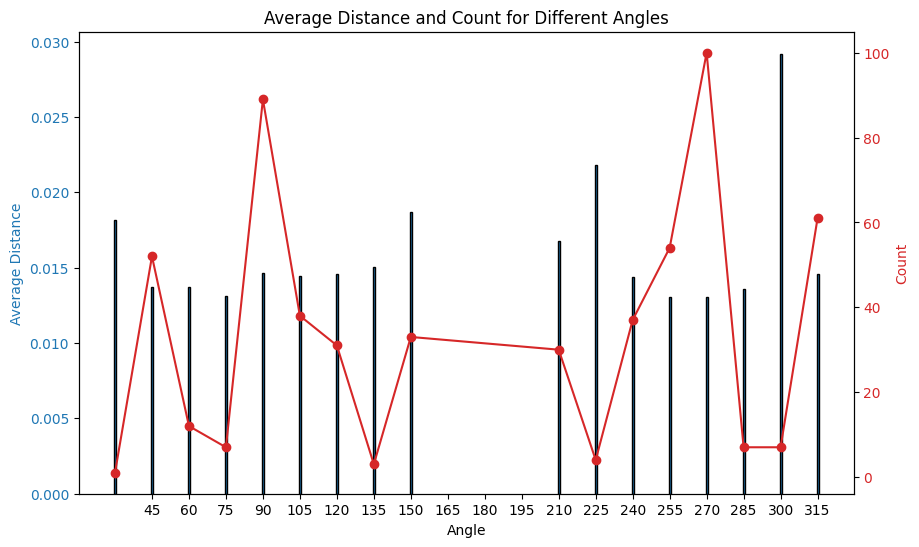

In [14]:
with Live(save_dvc_exp=True) as live:
    # Log model parameters if needed
    # Log the PyTorch model
    # live.log_artifact(model_path)
    
    live.log_metric(
        "test_avg_distance" ,dis 
    )

    # Your plotting code
    summary_data = df.groupby('Angle')['Average Distance'].agg(['mean', 'count'])

    custom_ticks = list(range(45, 361, 15))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Angle')
    ax1.set_ylabel('Average Distance', color=color)
    ax1.bar(summary_data.index, summary_data['mean'], color=color, edgecolor='black')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(custom_ticks)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Count', color=color)
    ax2.plot(summary_data.index, summary_data['count'], color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Average Distance and Count for Different Angles')

    # Save the figure
    plt.savefig('plot.png')

    # Log the figure
    # live.log_artifact('plot.png')

    for angle, values in summary_data.iterrows():
        live.log_metric(
            f"angle_{angle}_dis" ,values['mean']
        )